# Final Notebook

### Dataset used:

https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images?resource=download


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
import itertools
import psutil
# import google.colab

# torch module
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn as nn
import torch.nn.functional as F  # for activation functions

# sklearn metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# tqdm
from tqdm import tqdm

# torchcam
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image


In [2]:
# get num_workers, device, batch size
def count_workers() -> int:
	try:
		vCPUs = os.cpu_count()
		if vCPUs is None:
			vCPUs = psutil.cpu_count(logical = False)
		return vCPUs
	except Exception as e:
		return 1

def get_device() -> torch.device:
	if torch.cuda.is_available():
		return torch.device("cuda")
	elif torch.backends.mps.is_available():
		return torch.device("mps")
	else:
		return torch.device("cpu")

workers=count_workers()
device = get_device()

print(f"cores: {workers}, device: {device}")

cores: 12, device: cuda


### Load dataset

In [3]:
# # if using zipfile
# import zipfile

# # extract zipfile
# with zipfile.ZipFile('cifake.zip', 'r') as zip_ref:
#     zip_ref.extractall('dataset')

In [72]:
# standarise pixel size and shape for all images
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # resize all to 128 x 128 pixels
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip() # randomly flip the image horizontally; theres actually no need to flip for test images but for simplicaity we will
])

# get paths
train_dir = 'dataset/train'
test_dir = 'dataset/test'

# load images and convert to tensors aka matrix format
train_images = torchvision.datasets.ImageFolder(root = train_dir, transform = transform)
test_images = torchvision.datasets.ImageFolder(root = test_dir, transform = transform)

# Check class names assigned correctly ('FAKE': 0, 'REAL': 1)
print(train_images.classes)
print(train_images.class_to_idx)

['FAKE', 'REAL']
{'FAKE': 0, 'REAL': 1}


### Create train, validation split

In [73]:
# Get indexes for each class
fake_indices = [i for i, (_, label) in enumerate(train_images.samples) if label == 0]
real_indices = [i for i, (_, label) in enumerate(train_images.samples) if label == 1]

# Shuffle each sets
random.shuffle(fake_indices)
random.shuffle(real_indices)

# Split each class into 70% for training and 30% for validation
fake_train_size = int(0.7 * len(fake_indices))
real_train_size = int(0.7 * len(real_indices))
fake_train_indices, fake_val_indices = fake_indices[:fake_train_size], fake_indices[fake_train_size:]
real_train_indices, real_val_indices = real_indices[:real_train_size], real_indices[real_train_size:]

# Get balanced datasets for training and validation
train_indices = fake_train_indices + real_train_indices
val_indices = fake_val_indices + real_val_indices
train_data = Subset(train_images, train_indices)
val_data = Subset(train_images, val_indices)

# Create DataLoaders for training, validation & testing
# !!! DO ADJUST 'num_workers' DEPENDING ON YOUR COMPUTER !!!


### Create dataloaders

In [74]:
batch_size = 32

train_loader = DataLoader(
    train_data,
    batch_size = batch_size,
    shuffle = True,
    num_workers = workers,
    persistent_workers = True,
    pin_memory = True
    )

val_loader = DataLoader(
    val_data,
    batch_size = batch_size,
    shuffle = True,
    num_workers = workers,
    persistent_workers = True,
    pin_memory = True
    )

test_loader = DataLoader(
    test_images,
    batch_size = batch_size,
    shuffle = False,
    num_workers = workers,
    persistent_workers = True,
    pin_memory = True
    )

In [75]:
# Check how many images in the dataset
print(len(train_data))  # 70k
print(len(val_data))    # 30k
print(len(test_images)) # 20k


# Check the shape of the images
print(train_data[0][0].shape) # 3 channels, 128 x 128 px
print(train_data[0]) # 0 or 1, fake or real; prints RGB pixel values

70000
30000
20000
torch.Size([3, 128, 128])
(tensor([[[0.3804, 0.3804, 0.3804,  ..., 0.2667, 0.2784, 0.2784],
         [0.3804, 0.3804, 0.3804,  ..., 0.2667, 0.2784, 0.2784],
         [0.3804, 0.3804, 0.3804,  ..., 0.2588, 0.2706, 0.2706],
         ...,
         [0.1529, 0.1529, 0.1608,  ..., 0.3529, 0.3529, 0.3529],
         [0.1529, 0.1529, 0.1608,  ..., 0.3529, 0.3529, 0.3529],
         [0.1529, 0.1529, 0.1608,  ..., 0.3529, 0.3529, 0.3529]],

        [[0.2235, 0.2235, 0.2235,  ..., 0.2196, 0.2353, 0.2353],
         [0.2235, 0.2235, 0.2235,  ..., 0.2196, 0.2353, 0.2353],
         [0.2235, 0.2235, 0.2235,  ..., 0.2157, 0.2314, 0.2314],
         ...,
         [0.0784, 0.0784, 0.0824,  ..., 0.5451, 0.5451, 0.5451],
         [0.0784, 0.0784, 0.0824,  ..., 0.5451, 0.5451, 0.5451],
         [0.0784, 0.0784, 0.0824,  ..., 0.5451, 0.5451, 0.5451]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.1490, 0.1647, 0.1647],
         [0.0196, 0.0196, 0.0196,  ..., 0.1490, 0.1647, 0.1647],
         [0.0

### Print samples of dataset images with labels

Training set:


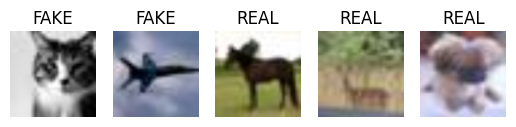


Validation set:


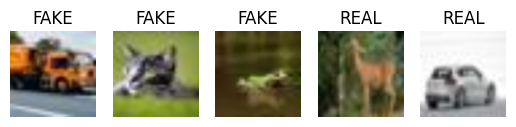

In [76]:
# get class names from dataset
class_names = train_images.classes  # ['FAKE', 'REAL']

# print n images in train_data starting from starting_index
n_images = 5

print('Training set:')
starting_index = 34998
for i in range(n_images):
	plt.subplot(1, 5, i + 1) # subplot with 1 row and 5 columns
	plt.imshow(train_data[starting_index + i][0].permute(1, 2, 0)) # permute to get channels last aka make into matplotlib format
	label_idx = train_data[starting_index + i][1]  # Get number label (0 or 1)
	plt.title(class_names[label_idx])  # Convert number to 'FAKE' or 'REAL'
	plt.axis('off') # remove axis
plt.show()

print('\nValidation set:')
starting_index = 14997
for j in range(n_images):
	plt.subplot(1, 5, j + 1) # subplot with 1 row and 5 columns
	plt.imshow(val_data[starting_index + j][0].permute(1, 2, 0)) # permute to get channels last aka make into matplotlib format
	label_idx = val_data[starting_index + j][1]  # Get numeric label (0 or 1)
	plt.title(class_names[label_idx])  # Convert number to 'FAKE' or 'REAL'
	plt.axis('off') # remove axis
plt.show()

# Why Dropout rate for more effective regularisation

https://www.geeksforgeeks.org/training-neural-networks-with-dropout-for-effective-regularization/


### Model architecture

In [77]:
class CNN(nn.Module):
    def __init__(self, dropout_rate):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 29 * 29, 120)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)  # binary classification

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten dynamically
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Define training loop

In [78]:
# Training loop
def train_cnn(model: nn.Module, train_loader, test_loader, optimizer, criterion, epochs: int = 1000):
    print(f"Training on {device}")
    # Convert everything to tensors first
    loss_ls = []
    f1_ls = []
    accuracy_score_ls = []
    model = model.to(device)


    for epoch in tqdm(range(epochs)):
        model.train()
        for features, target in train_loader:
            features, target = features.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

        model.eval()
        total_loss = 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for features, target in test_loader:
                features, target = features.to(device), target.to(device)
                output = model(features)
                loss = criterion(output, target)
                total_loss += loss.item()
                label_out = torch.argmax(output, dim = 1)  # Argmax returns the index of the maximum value in the tensor

                all_preds.extend(label_out.cpu().numpy()) # store predictions
                all_labels.extend(target.cpu().numpy()) # store true labels

        # Compute binary F1 score
        f1 = f1_score(all_labels, all_preds, average = "binary")
        # Compute accuracy
        accuracy = accuracy_score(all_labels, all_preds)  # Compare predictions to true labels

        loss_ls.append(total_loss / len(test_loader))
        f1_ls.append(f1)
        accuracy_score_ls.append(accuracy)

        print(f"Epoch {epoch + 1} - Loss: {total_loss / len(test_loader)} - F1 Score: {f1}")

    return loss_ls, f1_ls, accuracy_score_ls


In [79]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute evaluation metrics
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average = "binary")
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Test Accuracy: {acc}")
    print(f"F1 Score: {f1}")

    return acc, f1, cm


### Hyperparameter tuning

Commented out, please do not re-run unless necessary, long time taken.

In [ ]:
# lrs = [0.0001, 0.0005, 0.001]
# weight_decays = [0.0001, 0.0005, 0.001]
# batch_sizes = [32, 64, 128, 256]

# # randomly disables a bunch of neurons to ensure it does not memorise data
# dropout_rates = [0.2, 0.35, 0.5]

# hyperparam_dict = {}


In [ ]:
# # Generate all possible hyperparameter combinations aka using a bunch of for loops
# param_grid = list(itertools.product(lrs, weight_decays, dropout_rates, batch_sizes))

# for lr, weight_decay, dropout_rate, batch_size in param_grid:
#     print(f"Training with: lr = {lr}, weight_decay = {weight_decay}, dropout_rate = {dropout_rate}, batch_size = {batch_size}")

#     # Initialize model with current dropout rate
#     model = CNN(dropout_rate=dropout_rate).to(device)

#     optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
#     criterion = nn.CrossEntropyLoss()

#     # Update DataLoader for current batch size
#     # !!! DO ADJUST 'num_workers' DEPENDING ON YOUR COMPUTER !!!
#     train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 8, persistent_workers = True, pin_memory = True)
#     val_loader = DataLoader(val_data, batch_size = batch_size, shuffle = True, num_workers = 4, persistent_workers = True, pin_memory = True)

#     # Train model
#     loss_ls, f1_ls, accuracy_score_ls = train_cnn(model, train_loader, val_loader, optimizer, criterion, epochs = 12)

#     # Evaluate model on validation set
#     val_accuracy, f1, _ = evaluate_model(model, val_loader)

#     # Store results
#     hyperparam_dict[(lr, weight_decay, dropout_rate, batch_size)] = [f1, loss_ls, f1_ls]


Training with: lr = 0.0001, weight_decay = 0.0001, dropout_rate = 0.2, batch_size = 32
Training on cuda


  8%|▊         | 1/12 [00:18<03:20, 18.26s/it]

Epoch 1 - Loss: 0.3847738038311635 - F1 Score: 0.8190217002076917


 17%|█▋        | 2/12 [00:35<02:57, 17.70s/it]

Epoch 2 - Loss: 0.30566888613137866 - F1 Score: 0.8712037097511593


 25%|██▌       | 3/12 [00:52<02:37, 17.52s/it]

Epoch 3 - Loss: 0.2713590690981287 - F1 Score: 0.8848627715103553


 33%|███▎      | 4/12 [01:10<02:19, 17.44s/it]

Epoch 4 - Loss: 0.23456268260346802 - F1 Score: 0.9042531882219403


 42%|████▏     | 5/12 [01:27<02:01, 17.42s/it]

Epoch 5 - Loss: 0.22603701284604033 - F1 Score: 0.9112991795335617


 50%|█████     | 6/12 [01:44<01:44, 17.36s/it]

Epoch 6 - Loss: 0.21817619665694643 - F1 Score: 0.9130203130203131


 58%|█████▊    | 7/12 [02:01<01:26, 17.29s/it]

Epoch 7 - Loss: 0.21223418258511817 - F1 Score: 0.918409236690186


 67%|██████▋   | 8/12 [02:19<01:08, 17.24s/it]

Epoch 8 - Loss: 0.1941293314623553 - F1 Score: 0.925546582627536


 75%|███████▌  | 9/12 [02:36<00:51, 17.29s/it]

Epoch 9 - Loss: 0.2252780757904021 - F1 Score: 0.9053098279320173


 83%|████████▎ | 10/12 [02:53<00:34, 17.23s/it]

Epoch 10 - Loss: 0.1896873347774974 - F1 Score: 0.9264527944013866


 92%|█████████▏| 11/12 [03:11<00:17, 17.29s/it]

Epoch 11 - Loss: 0.2352953813285001 - F1 Score: 0.9144490873103145


100%|██████████| 12/12 [03:28<00:00, 17.35s/it]

Epoch 12 - Loss: 0.1986096494539238 - F1 Score: 0.9257028759138192


Test Accuracy: 0.9235666666666666
F1 Score: 0.9260966255197086
Training with: lr = 0.0001, weight_decay = 0.0001, dropout_rate = 0.2, batch_size = 64
Training on cuda


  8%|▊         | 1/12 [00:17<03:09, 17.18s/it]

Epoch 1 - Loss: 0.4138602887008236 - F1 Score: 0.8115071419036177


 17%|█▋        | 2/12 [00:33<02:47, 16.79s/it]

Epoch 2 - Loss: 0.37602558268158676 - F1 Score: 0.8400495202723615


 25%|██▌       | 3/12 [00:50<02:30, 16.71s/it]

Epoch 3 - Loss: 0.3876069481375375 - F1 Score: 0.8004973437323386


 33%|███▎      | 4/12 [01:06<02:13, 16.66s/it]

Epoch 4 - Loss: 0.3359639828583833 - F1 Score: 0.8657022227741215


 42%|████▏     | 5/12 [01:23<01:56, 16.65s/it]

Epoch 5 - Loss: 0.2785704905576289 - F1 Score: 0.8856931441624039


 50%|█████     | 6/12 [01:40<01:39, 16.66s/it]

Epoch 6 - Loss: 0.26341372412214403 - F1 Score: 0.8864946472687346


 58%|█████▊    | 7/12 [01:57<01:23, 16.77s/it]

Epoch 7 - Loss: 0.2482263813140804 - F1 Score: 0.8954285907355475


 67%|██████▋   | 8/12 [02:13<01:06, 16.73s/it]

Epoch 8 - Loss: 0.24371877388913493 - F1 Score: 0.9023294615927614


 75%|███████▌  | 9/12 [02:30<00:50, 16.76s/it]

Epoch 9 - Loss: 0.23457151627553297 - F1 Score: 0.9039477158700818


 83%|████████▎ | 10/12 [02:47<00:33, 16.71s/it]

Epoch 10 - Loss: 0.21637240685284265 - F1 Score: 0.9114493712772997


 92%|█████████▏| 11/12 [03:03<00:16, 16.64s/it]

Epoch 11 - Loss: 0.21462774530116682 - F1 Score: 0.9126853377265239


100%|██████████| 12/12 [03:20<00:00, 16.70s/it]

Epoch 12 - Loss: 0.20971383777127336 - F1 Score: 0.9157786409056203


Test Accuracy: 0.9153666666666667
F1 Score: 0.9157569926009489
Training with: lr = 0.0001, weight_decay = 0.0001, dropout_rate = 0.2, batch_size = 128
Training on cuda


  8%|▊         | 1/12 [00:16<03:06, 16.97s/it]

Epoch 1 - Loss: 0.44615175546483793 - F1 Score: 0.810377924415117


 17%|█▋        | 2/12 [00:33<02:46, 16.67s/it]

Epoch 2 - Loss: 0.3690289723112228 - F1 Score: 0.834755624515128


 25%|██▌       | 3/12 [00:49<02:29, 16.57s/it]

Epoch 3 - Loss: 0.33272699808820766 - F1 Score: 0.853099039349082


 33%|███▎      | 4/12 [01:06<02:11, 16.44s/it]

Epoch 4 - Loss: 0.3001785817932575 - F1 Score: 0.8750855021009087


 42%|████▏     | 5/12 [01:22<01:55, 16.44s/it]

Epoch 5 - Loss: 0.2974765205636938 - F1 Score: 0.8813548690606868


 50%|█████     | 6/12 [01:38<01:38, 16.39s/it]

Epoch 6 - Loss: 0.29050983374423167 - F1 Score: 0.8821650065777109


 58%|█████▊    | 7/12 [01:55<01:21, 16.39s/it]

Epoch 7 - Loss: 0.25277385635578886 - F1 Score: 0.8941381156316917


 67%|██████▋   | 8/12 [02:11<01:05, 16.35s/it]

Epoch 8 - Loss: 0.23676312236075706 - F1 Score: 0.9044990248256256


 75%|███████▌  | 9/12 [02:28<00:49, 16.40s/it]

Epoch 9 - Loss: 0.2387411816323057 - F1 Score: 0.8990335184042771


 83%|████████▎ | 10/12 [02:44<00:32, 16.45s/it]

Epoch 10 - Loss: 0.22718514099400094 - F1 Score: 0.9068637375987042


 92%|█████████▏| 11/12 [03:01<00:16, 16.49s/it]

Epoch 11 - Loss: 0.22791934045071296 - F1 Score: 0.9043860251218341


100%|██████████| 12/12 [03:17<00:00, 16.46s/it]

Epoch 12 - Loss: 0.21422904127455772 - F1 Score: 0.9111883158498331


Test Accuracy: 0.9132333333333333
F1 Score: 0.9122357463164638
Training with: lr = 0.0001, weight_decay = 0.0001, dropout_rate = 0.2, batch_size = 256
Training on cuda


  8%|▊         | 1/12 [00:16<03:01, 16.53s/it]

Epoch 1 - Loss: 0.49437870842925574 - F1 Score: 0.7822363953110698


 17%|█▋        | 2/12 [00:32<02:43, 16.36s/it]

Epoch 2 - Loss: 0.392908158948866 - F1 Score: 0.817477096546864


 25%|██▌       | 3/12 [00:48<02:25, 16.19s/it]

Epoch 3 - Loss: 0.36394231981140074 - F1 Score: 0.8478349481077352


 33%|███▎      | 4/12 [01:04<02:08, 16.12s/it]

Epoch 4 - Loss: 0.3282067135481511 - F1 Score: 0.8626904376012966


 42%|████▏     | 5/12 [01:20<01:52, 16.12s/it]

Epoch 5 - Loss: 0.3106010158435773 - F1 Score: 0.8700075980311189


 50%|█████     | 6/12 [01:37<01:37, 16.21s/it]

Epoch 6 - Loss: 0.2977672488255016 - F1 Score: 0.874686297473649


 58%|█████▊    | 7/12 [01:53<01:20, 16.18s/it]

Epoch 7 - Loss: 0.2849451239078732 - F1 Score: 0.8784233775059463


 67%|██████▋   | 8/12 [02:09<01:04, 16.17s/it]

Epoch 8 - Loss: 0.2862827208335117 - F1 Score: 0.8841346766994006


 75%|███████▌  | 9/12 [02:25<00:48, 16.12s/it]

Epoch 9 - Loss: 0.2684553259257543 - F1 Score: 0.889538661468486


 83%|████████▎ | 10/12 [02:41<00:32, 16.08s/it]

Epoch 10 - Loss: 0.2797173350039175 - F1 Score: 0.8890220442145763


 92%|█████████▏| 11/12 [02:57<00:16, 16.12s/it]

Epoch 11 - Loss: 0.2509325496473555 - F1 Score: 0.8968932615801116


100%|██████████| 12/12 [03:13<00:00, 16.14s/it]

Epoch 12 - Loss: 0.2442218774961213 - F1 Score: 0.8983011091378212


Test Accuracy: 0.8992333333333333
F1 Score: 0.8988184891388025
Training with: lr = 0.0001, weight_decay = 0.0001, dropout_rate = 0.35, batch_size = 32
Training on cuda


  8%|▊         | 1/12 [00:17<03:14, 17.72s/it]

Epoch 1 - Loss: 0.4076753353862874 - F1 Score: 0.8129949786000742


 17%|█▋        | 2/12 [00:35<02:55, 17.51s/it]

Epoch 2 - Loss: 0.36068598032474264 - F1 Score: 0.8363152550680999


 25%|██▌       | 3/12 [00:52<02:36, 17.36s/it]

Epoch 3 - Loss: 0.3150171409649 - F1 Score: 0.8704524180967239


 33%|███▎      | 4/12 [01:09<02:18, 17.35s/it]

Epoch 4 - Loss: 0.30985488246149345 - F1 Score: 0.8611436066503598


 42%|████▏     | 5/12 [01:26<02:01, 17.29s/it]

Epoch 5 - Loss: 0.27708593428309664 - F1 Score: 0.8921348314606742


 50%|█████     | 6/12 [01:44<01:43, 17.28s/it]

Epoch 6 - Loss: 0.23983460714790358 - F1 Score: 0.9039210594650741


 58%|█████▊    | 7/12 [02:01<01:26, 17.36s/it]

Epoch 7 - Loss: 0.2264112166996831 - F1 Score: 0.908265824061313


 67%|██████▋   | 8/12 [02:18<01:09, 17.34s/it]

Epoch 8 - Loss: 0.22671382564471473 - F1 Score: 0.9102836069318887


 75%|███████▌  | 9/12 [02:36<00:52, 17.34s/it]

Epoch 9 - Loss: 0.21541561284013142 - F1 Score: 0.9144337673411826


 83%|████████▎ | 10/12 [02:53<00:34, 17.38s/it]

Epoch 10 - Loss: 0.20803766406035976 - F1 Score: 0.9187211601845748


 92%|█████████▏| 11/12 [03:11<00:17, 17.49s/it]

Epoch 11 - Loss: 0.20818549891842453 - F1 Score: 0.9191580728065324


100%|██████████| 12/12 [03:28<00:00, 17.39s/it]

Epoch 12 - Loss: 0.196196890418241 - F1 Score: 0.923041444290703


Test Accuracy: 0.9224333333333333
F1 Score: 0.9233303680274126
Training with: lr = 0.0001, weight_decay = 0.0001, dropout_rate = 0.35, batch_size = 64
Training on cuda


  8%|▊         | 1/12 [00:16<03:06, 16.97s/it]

Epoch 1 - Loss: 0.40455605118259436 - F1 Score: 0.8115435965903256


 17%|█▋        | 2/12 [00:33<02:46, 16.65s/it]

Epoch 2 - Loss: 0.36394651424783125 - F1 Score: 0.8355207090506221


 25%|██▌       | 3/12 [00:50<02:30, 16.75s/it]

Epoch 3 - Loss: 0.32735479780351684 - F1 Score: 0.8590306892503773


 33%|███▎      | 4/12 [01:06<02:13, 16.68s/it]

Epoch 4 - Loss: 0.2976053380318034 - F1 Score: 0.8753190653838602


 42%|████▏     | 5/12 [01:23<01:56, 16.67s/it]

Epoch 5 - Loss: 0.2639766081309776 - F1 Score: 0.892705266601243


 50%|█████     | 6/12 [01:40<01:39, 16.64s/it]

Epoch 6 - Loss: 0.2625424638390541 - F1 Score: 0.8848371836044062


 58%|█████▊    | 7/12 [01:56<01:23, 16.61s/it]

Epoch 7 - Loss: 0.23342506542229957 - F1 Score: 0.9039506584430739


 67%|██████▋   | 8/12 [02:13<01:06, 16.56s/it]

Epoch 8 - Loss: 0.22612620405614503 - F1 Score: 0.9084869622986215


 75%|███████▌  | 9/12 [02:29<00:49, 16.55s/it]

Epoch 9 - Loss: 0.2341042700320927 - F1 Score: 0.9009052256206281


 83%|████████▎ | 10/12 [02:46<00:33, 16.51s/it]

Epoch 10 - Loss: 0.22067864861950945 - F1 Score: 0.912065306122449


 92%|█████████▏| 11/12 [03:02<00:16, 16.49s/it]

Epoch 11 - Loss: 0.21083909071394122 - F1 Score: 0.9143474559622814


100%|██████████| 12/12 [03:19<00:00, 16.59s/it]

Epoch 12 - Loss: 0.21177157283083461 - F1 Score: 0.9163699915852159


Test Accuracy: 0.9135333333333333
F1 Score: 0.916057213125364
Training with: lr = 0.0001, weight_decay = 0.0001, dropout_rate = 0.35, batch_size = 128
Training on cuda


  8%|▊         | 1/12 [00:16<03:01, 16.53s/it]

Epoch 1 - Loss: 0.43036443591117857 - F1 Score: 0.7984739977243825


 17%|█▋        | 2/12 [00:32<02:43, 16.37s/it]

Epoch 2 - Loss: 0.3576362795652227 - F1 Score: 0.8463085506682237


 25%|██▌       | 3/12 [00:49<02:26, 16.31s/it]

Epoch 3 - Loss: 0.32665267402821396 - F1 Score: 0.8556013745704467


 33%|███▎      | 4/12 [01:05<02:09, 16.20s/it]

Epoch 4 - Loss: 0.2981868696339587 - F1 Score: 0.8751989389920425


 42%|████▏     | 5/12 [01:21<01:53, 16.19s/it]

Epoch 5 - Loss: 0.28985261035726423 - F1 Score: 0.884792336295456


 50%|█████     | 6/12 [01:37<01:37, 16.20s/it]

Epoch 6 - Loss: 0.2591152434653424 - F1 Score: 0.8947162170988179


 58%|█████▊    | 7/12 [01:53<01:20, 16.15s/it]

Epoch 7 - Loss: 0.24854710343036246 - F1 Score: 0.8973941368078175


 67%|██████▋   | 8/12 [02:09<01:04, 16.15s/it]

Epoch 8 - Loss: 0.23501612702582744 - F1 Score: 0.9040156050312773


 75%|███████▌  | 9/12 [02:25<00:48, 16.17s/it]

Epoch 9 - Loss: 0.29472646218665105 - F1 Score: 0.8819864505202032


 83%|████████▎ | 10/12 [02:42<00:32, 16.17s/it]

Epoch 10 - Loss: 0.2202781725754129 - F1 Score: 0.9106553753018399


 92%|█████████▏| 11/12 [02:58<00:16, 16.22s/it]

Epoch 11 - Loss: 0.24741250416065785 - F1 Score: 0.9034661990794376


100%|██████████| 12/12 [03:14<00:00, 16.20s/it]

Epoch 12 - Loss: 0.22316099614539045 - F1 Score: 0.9079178885630499


Test Accuracy: 0.9111333333333334
F1 Score: 0.9080816439111846
Training with: lr = 0.0001, weight_decay = 0.0001, dropout_rate = 0.35, batch_size = 256
Training on cuda


  8%|▊         | 1/12 [00:16<03:01, 16.49s/it]

Epoch 1 - Loss: 0.46285839101015513 - F1 Score: 0.7958623734586395


 17%|█▋        | 2/12 [00:32<02:41, 16.19s/it]

Epoch 2 - Loss: 0.40730203183020575 - F1 Score: 0.7995129288732898


 25%|██▌       | 3/12 [00:48<02:24, 16.09s/it]

Epoch 3 - Loss: 0.3569386904522524 - F1 Score: 0.8447078857741682


 33%|███▎      | 4/12 [01:04<02:07, 15.99s/it]

Epoch 4 - Loss: 0.3433611136624369 - F1 Score: 0.857664467362757


 42%|████▏     | 5/12 [01:20<01:51, 15.97s/it]

Epoch 5 - Loss: 0.31986134423542834 - F1 Score: 0.8672030227028436


 50%|█████     | 6/12 [01:36<01:35, 15.94s/it]

Epoch 6 - Loss: 0.3104601408970558 - F1 Score: 0.8717035151900747


 58%|█████▊    | 7/12 [01:51<01:19, 15.91s/it]

Epoch 7 - Loss: 0.3465886241046049 - F1 Score: 0.8361486486486487


 67%|██████▋   | 8/12 [02:07<01:03, 15.91s/it]

Epoch 8 - Loss: 0.28664733229552286 - F1 Score: 0.8844745455134645


 75%|███████▌  | 9/12 [02:23<00:47, 15.91s/it]

Epoch 9 - Loss: 0.2880971232208155 - F1 Score: 0.8724077328646749


 83%|████████▎ | 10/12 [02:39<00:31, 15.89s/it]

Epoch 10 - Loss: 0.2957387181409335 - F1 Score: 0.8661428571428571


 92%|█████████▏| 11/12 [02:55<00:15, 15.94s/it]

Epoch 11 - Loss: 0.25349113193608946 - F1 Score: 0.8942692438114616


100%|██████████| 12/12 [03:11<00:00, 15.98s/it]

Epoch 12 - Loss: 0.2601753537685184 - F1 Score: 0.8973642813573469


Test Accuracy: 0.8914
F1 Score: 0.8955099422706864
Training with: lr = 0.0001, weight_decay = 0.0001, dropout_rate = 0.5, batch_size = 32
Training on cuda


  8%|▊         | 1/12 [00:17<03:16, 17.88s/it]

Epoch 1 - Loss: 0.4123198556969923 - F1 Score: 0.8000427411312153


 17%|█▋        | 2/12 [00:35<02:54, 17.47s/it]

Epoch 2 - Loss: 0.3230859963402057 - F1 Score: 0.8625150020002667


 25%|██▌       | 3/12 [00:52<02:36, 17.44s/it]

Epoch 3 - Loss: 0.2864908589355981 - F1 Score: 0.8768388052502842


 33%|███▎      | 4/12 [01:09<02:18, 17.32s/it]

Epoch 4 - Loss: 0.27488142375085656 - F1 Score: 0.8810107356139322


 42%|████▏     | 5/12 [01:27<02:01, 17.42s/it]

Epoch 5 - Loss: 0.28128730017604475 - F1 Score: 0.8766056011791956


 50%|█████     | 6/12 [01:44<01:44, 17.42s/it]

Epoch 6 - Loss: 0.25314231879357846 - F1 Score: 0.8970538890007382


 58%|█████▊    | 7/12 [02:01<01:26, 17.38s/it]

Epoch 7 - Loss: 0.23548006781859437 - F1 Score: 0.9057654075546719


 67%|██████▋   | 8/12 [02:19<01:09, 17.39s/it]

Epoch 8 - Loss: 0.23262986385110598 - F1 Score: 0.9042401143401619


 75%|███████▌  | 9/12 [02:36<00:52, 17.36s/it]

Epoch 9 - Loss: 0.21708609904847673 - F1 Score: 0.9158151493176874


 83%|████████▎ | 10/12 [02:54<00:34, 17.36s/it]

Epoch 10 - Loss: 0.21454833933650685 - F1 Score: 0.9146042067546944


 92%|█████████▏| 11/12 [03:11<00:17, 17.50s/it]

Epoch 11 - Loss: 0.2242843260261804 - F1 Score: 0.9116363283649649


100%|██████████| 12/12 [03:29<00:00, 17.45s/it]

Epoch 12 - Loss: 0.20777250404185704 - F1 Score: 0.917165902473309


Test Accuracy: 0.9167
F1 Score: 0.9164744810989672
Training with: lr = 0.0001, weight_decay = 0.0001, dropout_rate = 0.5, batch_size = 64
Training on cuda


  8%|▊         | 1/12 [00:17<03:07, 17.08s/it]

Epoch 1 - Loss: 0.447869786257937 - F1 Score: 0.7935813274981766


 17%|█▋        | 2/12 [00:33<02:48, 16.82s/it]

Epoch 2 - Loss: 0.4353033905344477 - F1 Score: 0.8157674548328117


 25%|██▌       | 3/12 [00:50<02:29, 16.66s/it]

Epoch 3 - Loss: 0.37685936365300404 - F1 Score: 0.8221158883727429


 33%|███▎      | 4/12 [01:06<02:13, 16.63s/it]

Epoch 4 - Loss: 0.3556066543372201 - F1 Score: 0.8505878614553543


 42%|████▏     | 5/12 [01:23<01:56, 16.62s/it]

Epoch 5 - Loss: 0.33085805190397477 - F1 Score: 0.8530560935004926


 50%|█████     | 6/12 [01:40<01:39, 16.63s/it]

Epoch 6 - Loss: 0.3175277518692301 - F1 Score: 0.8542801898400422


 58%|█████▊    | 7/12 [01:56<01:23, 16.66s/it]

Epoch 7 - Loss: 0.29658138427907216 - F1 Score: 0.8789405684754522


 67%|██████▋   | 8/12 [02:13<01:06, 16.61s/it]

Epoch 8 - Loss: 0.2912162728687085 - F1 Score: 0.87042777433354


 75%|███████▌  | 9/12 [02:29<00:49, 16.61s/it]

Epoch 9 - Loss: 0.26895663656913904 - F1 Score: 0.8875586151850743


 83%|████████▎ | 10/12 [02:46<00:33, 16.60s/it]

Epoch 10 - Loss: 0.26591023960029647 - F1 Score: 0.8861224489795918


 92%|█████████▏| 11/12 [03:02<00:16, 16.54s/it]

Epoch 11 - Loss: 0.2580058761497042 - F1 Score: 0.8972749045245647


100%|██████████| 12/12 [03:19<00:00, 16.62s/it]

Epoch 12 - Loss: 0.2540895992727168 - F1 Score: 0.8920902419135635


Test Accuracy: 0.8942333333333333
F1 Score: 0.8922470879885896
Training with: lr = 0.0001, weight_decay = 0.0001, dropout_rate = 0.5, batch_size = 128
Training on cuda


  8%|▊         | 1/12 [00:16<03:03, 16.69s/it]

Epoch 1 - Loss: 0.4375814359238807 - F1 Score: 0.8009484916348307


 17%|█▋        | 2/12 [00:32<02:43, 16.35s/it]

Epoch 2 - Loss: 0.3844473370846282 - F1 Score: 0.8306671484413494


 25%|██▌       | 3/12 [00:49<02:26, 16.29s/it]

Epoch 3 - Loss: 0.3563940008904072 - F1 Score: 0.8419632315736212


 33%|███▎      | 4/12 [01:05<02:10, 16.32s/it]

Epoch 4 - Loss: 0.328766397846506 - F1 Score: 0.8608543915207135


 42%|████▏     | 5/12 [01:21<01:54, 16.33s/it]

Epoch 5 - Loss: 0.3061277820074812 - F1 Score: 0.8696412360041693


 50%|█████     | 6/12 [01:38<01:37, 16.33s/it]

Epoch 6 - Loss: 0.2860756703513734 - F1 Score: 0.8815276435498384


 58%|█████▊    | 7/12 [01:54<01:21, 16.33s/it]

Epoch 7 - Loss: 0.2661738463538758 - F1 Score: 0.8911589771161665


 67%|██████▋   | 8/12 [02:10<01:05, 16.33s/it]

Epoch 8 - Loss: 0.2534302113538093 - F1 Score: 0.89917688778996


 75%|███████▌  | 9/12 [02:26<00:48, 16.31s/it]

Epoch 9 - Loss: 0.2391535905764458 - F1 Score: 0.9047031765607813


 83%|████████▎ | 10/12 [02:43<00:32, 16.28s/it]

Epoch 10 - Loss: 0.234931022182424 - F1 Score: 0.9042433345850545


 92%|█████████▏| 11/12 [02:59<00:16, 16.24s/it]

Epoch 11 - Loss: 0.22383758990054434 - F1 Score: 0.912575877540248


100%|██████████| 12/12 [03:15<00:00, 16.31s/it]

Epoch 12 - Loss: 0.21841230500251688 - F1 Score: 0.914863762440855


Test Accuracy: 0.9125333333333333
F1 Score: 0.914432922454836
Training with: lr = 0.0001, weight_decay = 0.0001, dropout_rate = 0.5, batch_size = 256
Training on cuda


  8%|▊         | 1/12 [00:16<03:01, 16.49s/it]

Epoch 1 - Loss: 0.48476042787907486 - F1 Score: 0.7571193866374589


 17%|█▋        | 2/12 [00:32<02:42, 16.20s/it]

Epoch 2 - Loss: 0.4249440956923921 - F1 Score: 0.8114092211513415


 25%|██▌       | 3/12 [00:48<02:24, 16.10s/it]

Epoch 3 - Loss: 0.3970633664373624 - F1 Score: 0.8287187925196975


 33%|███▎      | 4/12 [01:04<02:08, 16.06s/it]

Epoch 4 - Loss: 0.3714232884221158 - F1 Score: 0.8379196840026333


 42%|████▏     | 5/12 [01:20<01:52, 16.09s/it]

Epoch 5 - Loss: 0.36732281517174287 - F1 Score: 0.8469544019751851


 50%|█████     | 6/12 [01:36<01:36, 16.05s/it]

Epoch 6 - Loss: 0.33207293056835563 - F1 Score: 0.8589121887287025


 58%|█████▊    | 7/12 [01:52<01:20, 16.04s/it]

Epoch 7 - Loss: 0.3209464346705857 - F1 Score: 0.8641128637209758


 67%|██████▋   | 8/12 [02:08<01:04, 16.02s/it]

Epoch 8 - Loss: 0.32548593110957386 - F1 Score: 0.8654074676339983


 75%|███████▌  | 9/12 [02:24<00:48, 16.00s/it]

Epoch 9 - Loss: 0.3071877552291094 - F1 Score: 0.8741687312557048


 83%|████████▎ | 10/12 [02:40<00:31, 15.98s/it]

Epoch 10 - Loss: 0.29144016830092767 - F1 Score: 0.8790738728951657


 92%|█████████▏| 11/12 [02:56<00:15, 15.97s/it]

Epoch 11 - Loss: 0.28207271962852803 - F1 Score: 0.8849423891277943


100%|██████████| 12/12 [03:12<00:00, 16.03s/it]

Epoch 12 - Loss: 0.27519216224298637 - F1 Score: 0.8883308329528407


Test Accuracy: 0.8868
F1 Score: 0.8893378519290928
Training with: lr = 0.0001, weight_decay = 0.0005, dropout_rate = 0.2, batch_size = 32
Training on cuda


  8%|▊         | 1/12 [00:17<03:17, 17.98s/it]

Epoch 1 - Loss: 0.4288888793351299 - F1 Score: 0.775438987266585


 17%|█▋        | 2/12 [00:35<02:55, 17.58s/it]

Epoch 2 - Loss: 0.34302690252661705 - F1 Score: 0.8555807182141701


 25%|██▌       | 3/12 [00:52<02:36, 17.38s/it]

Epoch 3 - Loss: 0.2957653694394936 - F1 Score: 0.8740485803163677


 33%|███▎      | 4/12 [01:09<02:19, 17.43s/it]

Epoch 4 - Loss: 0.2582892923991182 - F1 Score: 0.8959490627943995


 42%|████▏     | 5/12 [01:27<02:01, 17.37s/it]

Epoch 5 - Loss: 0.24830189610182096 - F1 Score: 0.8943948009748173


 50%|█████     | 6/12 [01:44<01:44, 17.40s/it]

Epoch 6 - Loss: 0.21763058117966153 - F1 Score: 0.9133664190787063


 58%|█████▊    | 7/12 [02:02<01:26, 17.39s/it]

Epoch 7 - Loss: 0.21400214436608972 - F1 Score: 0.9151256837936705


 67%|██████▋   | 8/12 [02:19<01:09, 17.32s/it]

Epoch 8 - Loss: 0.2011307396256784 - F1 Score: 0.9205317973276179


 75%|███████▌  | 9/12 [02:36<00:51, 17.32s/it]

Epoch 9 - Loss: 0.20372842171235378 - F1 Score: 0.9172034669994267


 83%|████████▎ | 10/12 [02:53<00:34, 17.33s/it]

Epoch 10 - Loss: 0.19581185445499255 - F1 Score: 0.9247543498841119


 92%|█████████▏| 11/12 [03:11<00:17, 17.39s/it]

Epoch 11 - Loss: 0.2032722897176295 - F1 Score: 0.9179508252859393


100%|██████████| 12/12 [03:28<00:00, 17.39s/it]

Epoch 12 - Loss: 0.1942187856628633 - F1 Score: 0.9210643776824035


Test Accuracy: 0.9227
F1 Score: 0.9204268606526439
Training with: lr = 0.0001, weight_decay = 0.0005, dropout_rate = 0.2, batch_size = 64
Training on cuda


  8%|▊         | 1/12 [00:16<03:06, 16.95s/it]

Epoch 1 - Loss: 0.4908179525119155 - F1 Score: 0.7119910047385752


 17%|█▋        | 2/12 [00:33<02:48, 16.81s/it]

Epoch 2 - Loss: 0.37318638357907724 - F1 Score: 0.8344539220605453


 25%|██▌       | 3/12 [00:50<02:31, 16.88s/it]

Epoch 3 - Loss: 0.3703933080503427 - F1 Score: 0.8274651595464598


 33%|███▎      | 4/12 [01:07<02:14, 16.87s/it]

Epoch 4 - Loss: 0.3460966008050101 - F1 Score: 0.8583821434225107


 42%|████▏     | 5/12 [01:24<01:57, 16.80s/it]

Epoch 5 - Loss: 0.3147274241137352 - F1 Score: 0.8713834491471889


 50%|█████     | 6/12 [01:40<01:40, 16.71s/it]

Epoch 6 - Loss: 0.3121290917017821 - F1 Score: 0.8588172992056488


 58%|█████▊    | 7/12 [01:57<01:23, 16.71s/it]

Epoch 7 - Loss: 0.26756597183215847 - F1 Score: 0.8893118498342796


 67%|██████▋   | 8/12 [02:14<01:07, 16.82s/it]

Epoch 8 - Loss: 0.26224779092998646 - F1 Score: 0.8951678156455319


 75%|███████▌  | 9/12 [02:30<00:50, 16.72s/it]

Epoch 9 - Loss: 0.2439559933695712 - F1 Score: 0.8991505999730349


 83%|████████▎ | 10/12 [02:47<00:33, 16.65s/it]

Epoch 10 - Loss: 0.23584014950975427 - F1 Score: 0.9032432250008438


 92%|█████████▏| 11/12 [03:03<00:16, 16.60s/it]

Epoch 11 - Loss: 0.24894863626024108 - F1 Score: 0.8937667677084422


100%|██████████| 12/12 [03:20<00:00, 16.72s/it]

Epoch 12 - Loss: 0.24422912318696346 - F1 Score: 0.8943316029683308


Test Accuracy: 0.8988666666666667
F1 Score: 0.8943593314763231
Training with: lr = 0.0001, weight_decay = 0.0005, dropout_rate = 0.2, batch_size = 128
Training on cuda


  8%|▊         | 1/12 [00:16<03:02, 16.56s/it]

Epoch 1 - Loss: 0.44068085817580527 - F1 Score: 0.7962713755867004


 17%|█▋        | 2/12 [00:32<02:43, 16.31s/it]

Epoch 2 - Loss: 0.4094217876170544 - F1 Score: 0.8270864567716142


 25%|██▌       | 3/12 [00:48<02:25, 16.18s/it]

Epoch 3 - Loss: 0.37589030633581444 - F1 Score: 0.831991375534818


 33%|███▎      | 4/12 [01:05<02:10, 16.27s/it]

Epoch 4 - Loss: 0.3698637802550133 - F1 Score: 0.8457910354521319


 42%|████▏     | 5/12 [01:21<01:53, 16.27s/it]

Epoch 5 - Loss: 0.34157156918911225 - F1 Score: 0.8555979022117984


 50%|█████     | 6/12 [01:37<01:37, 16.23s/it]

Epoch 6 - Loss: 0.32625756219346475 - F1 Score: 0.8560356256586328


 58%|█████▊    | 7/12 [01:53<01:21, 16.25s/it]

Epoch 7 - Loss: 0.30288315580246294 - F1 Score: 0.8759475314745238


 67%|██████▋   | 8/12 [02:10<01:04, 16.22s/it]

Epoch 8 - Loss: 0.2924658499499585 - F1 Score: 0.8746938775510205


 75%|███████▌  | 9/12 [02:26<00:48, 16.25s/it]

Epoch 9 - Loss: 0.2704735540329142 - F1 Score: 0.8875289447568641


 83%|████████▎ | 10/12 [02:42<00:32, 16.26s/it]

Epoch 10 - Loss: 0.2769136442783031 - F1 Score: 0.8897268521452564


 92%|█████████▏| 11/12 [02:58<00:16, 16.23s/it]

Epoch 11 - Loss: 0.281955293962296 - F1 Score: 0.8901947300972087


100%|██████████| 12/12 [03:15<00:00, 16.25s/it]

Epoch 12 - Loss: 0.24874494221616297 - F1 Score: 0.9020911320511166


Test Accuracy: 0.8975666666666666
F1 Score: 0.9009316870305297
Training with: lr = 0.0001, weight_decay = 0.0005, dropout_rate = 0.2, batch_size = 256
Training on cuda


  8%|▊         | 1/12 [00:16<03:01, 16.50s/it]

Epoch 1 - Loss: 0.5119497505790096 - F1 Score: 0.7551614697510061


 17%|█▋        | 2/12 [00:32<02:42, 16.24s/it]

Epoch 2 - Loss: 0.43958979188385655 - F1 Score: 0.7846655791190864


 25%|██▌       | 3/12 [00:48<02:24, 16.10s/it]

Epoch 3 - Loss: 0.39108393808542674 - F1 Score: 0.8281034142490625


 33%|███▎      | 4/12 [01:04<02:08, 16.02s/it]

Epoch 4 - Loss: 0.37083217905739607 - F1 Score: 0.8298789817777159


 42%|████▏     | 5/12 [01:20<01:51, 15.99s/it]

Epoch 5 - Loss: 0.346078914353403 - F1 Score: 0.8520109332292073


 50%|█████     | 6/12 [01:36<01:36, 16.00s/it]

Epoch 6 - Loss: 0.3369625367350497 - F1 Score: 0.8583198183587415


 58%|█████▊    | 7/12 [01:52<01:20, 16.00s/it]

Epoch 7 - Loss: 0.3204680802458424 - F1 Score: 0.863165462923625


 67%|██████▋   | 8/12 [02:08<01:04, 16.01s/it]

Epoch 8 - Loss: 0.3097014689849595 - F1 Score: 0.8658536585365854


 75%|███████▌  | 9/12 [02:24<00:47, 15.95s/it]

Epoch 9 - Loss: 0.3023079949415336 - F1 Score: 0.8759331674369001


 83%|████████▎ | 10/12 [02:40<00:31, 15.93s/it]

Epoch 10 - Loss: 0.29794186088493313 - F1 Score: 0.8791088854648177


 92%|█████████▏| 11/12 [02:56<00:15, 15.96s/it]

Epoch 11 - Loss: 0.2775194381000632 - F1 Score: 0.8843264897346019


100%|██████████| 12/12 [03:12<00:00, 16.01s/it]

Epoch 12 - Loss: 0.2738378622521788 - F1 Score: 0.8836877019901344


Test Accuracy: 0.8861666666666667
F1 Score: 0.88379215299282
Training with: lr = 0.0001, weight_decay = 0.0005, dropout_rate = 0.35, batch_size = 32
Training on cuda


  8%|▊         | 1/12 [00:17<03:16, 17.83s/it]

Epoch 1 - Loss: 0.3965617548555199 - F1 Score: 0.8340930645210635


 17%|█▋        | 2/12 [00:35<02:55, 17.58s/it]

Epoch 2 - Loss: 0.3218469752399906 - F1 Score: 0.8611796067977341


 25%|██▌       | 3/12 [00:52<02:38, 17.56s/it]

Epoch 3 - Loss: 0.29816035159837717 - F1 Score: 0.8794604692397809


 33%|███▎      | 4/12 [01:10<02:20, 17.59s/it]

Epoch 4 - Loss: 0.28668283798229466 - F1 Score: 0.8862019018829901


 42%|████▏     | 5/12 [01:27<02:03, 17.57s/it]

Epoch 5 - Loss: 0.2618290719343846 - F1 Score: 0.8871842714488096


 50%|█████     | 6/12 [01:45<01:44, 17.49s/it]

Epoch 6 - Loss: 0.2332868689953137 - F1 Score: 0.9068979006389359


 58%|█████▊    | 7/12 [02:02<01:27, 17.55s/it]

Epoch 7 - Loss: 0.2375441683428501 - F1 Score: 0.8989365399318829


 67%|██████▋   | 8/12 [02:20<01:09, 17.47s/it]

Epoch 8 - Loss: 0.22791001514823578 - F1 Score: 0.9062191510365252


 75%|███████▌  | 9/12 [02:37<00:52, 17.46s/it]

Epoch 9 - Loss: 0.21012293092652298 - F1 Score: 0.9158727486955058


 83%|████████▎ | 10/12 [02:54<00:34, 17.40s/it]

Epoch 10 - Loss: 0.22938814343038652 - F1 Score: 0.9031010477462907


 92%|█████████▏| 11/12 [03:12<00:17, 17.47s/it]

Epoch 11 - Loss: 0.23268375956991524 - F1 Score: 0.9117423281765153


100%|██████████| 12/12 [03:29<00:00, 17.49s/it]

Epoch 12 - Loss: 0.19416172668012158 - F1 Score: 0.9247592622817039


Test Accuracy: 0.9225
F1 Score: 0.9241757166617748
Training with: lr = 0.0001, weight_decay = 0.0005, dropout_rate = 0.35, batch_size = 64
Training on cuda


  8%|▊         | 1/12 [00:17<03:07, 17.06s/it]

Epoch 1 - Loss: 0.42518668756810335 - F1 Score: 0.8122309445429222


 17%|█▋        | 2/12 [00:33<02:48, 16.81s/it]

Epoch 2 - Loss: 0.3642588897681694 - F1 Score: 0.8370405214703313


 25%|██▌       | 3/12 [00:50<02:31, 16.85s/it]

Epoch 3 - Loss: 0.3336957813516609 - F1 Score: 0.8602123115177405


 33%|███▎      | 4/12 [01:07<02:13, 16.73s/it]

Epoch 4 - Loss: 0.31186624942049546 - F1 Score: 0.8704993814701478


 42%|████▏     | 5/12 [01:23<01:57, 16.73s/it]

Epoch 5 - Loss: 0.28553671245254686 - F1 Score: 0.8796426892336624


 50%|█████     | 6/12 [01:40<01:40, 16.72s/it]

Epoch 6 - Loss: 0.28218739042912466 - F1 Score: 0.8863122171945701


 58%|█████▊    | 7/12 [01:57<01:23, 16.72s/it]

Epoch 7 - Loss: 0.2485535888275358 - F1 Score: 0.8995406824146982


 67%|██████▋   | 8/12 [02:13<01:06, 16.70s/it]

Epoch 8 - Loss: 0.24103609612310872 - F1 Score: 0.8988832281790884


 75%|███████▌  | 9/12 [02:30<00:50, 16.72s/it]

Epoch 9 - Loss: 0.22889578064431004 - F1 Score: 0.9080508613081424


 83%|████████▎ | 10/12 [02:47<00:33, 16.67s/it]

Epoch 10 - Loss: 0.2258554846366077 - F1 Score: 0.9076653879803486


 92%|█████████▏| 11/12 [03:04<00:16, 16.69s/it]

Epoch 11 - Loss: 0.21778943202198187 - F1 Score: 0.9145377929944694


100%|██████████| 12/12 [03:20<00:00, 16.74s/it]

Epoch 12 - Loss: 0.21256054821870982 - F1 Score: 0.914168350614503


Test Accuracy: 0.9130333333333334
F1 Score: 0.9136635891326649
Training with: lr = 0.0001, weight_decay = 0.0005, dropout_rate = 0.35, batch_size = 128
Training on cuda


  8%|▊         | 1/12 [00:16<03:02, 16.57s/it]

Epoch 1 - Loss: 0.44777408533907953 - F1 Score: 0.7809868466838332


 17%|█▋        | 2/12 [00:32<02:43, 16.38s/it]

Epoch 2 - Loss: 0.39020425499753747 - F1 Score: 0.8304496084869917


 25%|██▌       | 3/12 [00:48<02:26, 16.27s/it]

Epoch 3 - Loss: 0.36152761045922627 - F1 Score: 0.8467194748635087


 33%|███▎      | 4/12 [01:05<02:10, 16.27s/it]

Epoch 4 - Loss: 0.34008291712466704 - F1 Score: 0.8562993389384507


 42%|████▏     | 5/12 [01:21<01:53, 16.20s/it]

Epoch 5 - Loss: 0.34974191905336177 - F1 Score: 0.8377606398171951


 50%|█████     | 6/12 [01:37<01:37, 16.19s/it]

Epoch 6 - Loss: 0.3070718861006676 - F1 Score: 0.8701401745569955


 58%|█████▊    | 7/12 [01:53<01:20, 16.11s/it]

Epoch 7 - Loss: 0.2942450287494254 - F1 Score: 0.8774540329717151


 67%|██████▋   | 8/12 [02:09<01:04, 16.14s/it]

Epoch 8 - Loss: 0.2810776752360324 - F1 Score: 0.8831370017750525


 75%|███████▌  | 9/12 [02:25<00:48, 16.16s/it]

Epoch 9 - Loss: 0.2656927074523682 - F1 Score: 0.8918848167539267


 83%|████████▎ | 10/12 [02:42<00:32, 16.20s/it]

Epoch 10 - Loss: 0.2585483083382566 - F1 Score: 0.8946363362256692


 92%|█████████▏| 11/12 [02:58<00:16, 16.21s/it]

Epoch 11 - Loss: 0.2465859796772612 - F1 Score: 0.8998158137087225


100%|██████████| 12/12 [03:14<00:00, 16.21s/it]

Epoch 12 - Loss: 0.24083096990559963 - F1 Score: 0.9029093596721092


Test Accuracy: 0.9021333333333333
F1 Score: 0.9014037208677547
Training with: lr = 0.0001, weight_decay = 0.0005, dropout_rate = 0.35, batch_size = 256
Training on cuda


  8%|▊         | 1/12 [00:16<03:01, 16.47s/it]

Epoch 1 - Loss: 0.5210563118680048 - F1 Score: 0.7560152628425467


 17%|█▋        | 2/12 [00:32<02:41, 16.11s/it]

Epoch 2 - Loss: 0.45462593234191506 - F1 Score: 0.7927730984376005


 25%|██▌       | 3/12 [00:48<02:24, 16.05s/it]

Epoch 3 - Loss: 0.4109393062732987 - F1 Score: 0.8192887826620587


 33%|███▎      | 4/12 [01:04<02:08, 16.01s/it]

Epoch 4 - Loss: 0.382448864437766 - F1 Score: 0.8334192218500387


 42%|████▏     | 5/12 [01:20<01:52, 16.05s/it]

Epoch 5 - Loss: 0.363435816209195 - F1 Score: 0.8376645291933851


 50%|█████     | 6/12 [01:36<01:36, 16.04s/it]

Epoch 6 - Loss: 0.34866190689094995 - F1 Score: 0.8459893411181643


 58%|█████▊    | 7/12 [01:52<01:19, 15.99s/it]

Epoch 7 - Loss: 0.339443802075871 - F1 Score: 0.8528158700572493


 67%|██████▋   | 8/12 [02:08<01:04, 16.04s/it]

Epoch 8 - Loss: 0.3345827770940328 - F1 Score: 0.8507214206437292


 75%|███████▌  | 9/12 [02:24<00:48, 16.10s/it]

Epoch 9 - Loss: 0.32774183330899576 - F1 Score: 0.852132267493045


 83%|████████▎ | 10/12 [02:40<00:32, 16.03s/it]

Epoch 10 - Loss: 0.30749268892963055 - F1 Score: 0.8743126981046639


 92%|█████████▏| 11/12 [02:56<00:16, 16.03s/it]

Epoch 11 - Loss: 0.2863792822522632 - F1 Score: 0.8809268684703991


100%|██████████| 12/12 [03:12<00:00, 16.04s/it]

Epoch 12 - Loss: 0.27492043906349245 - F1 Score: 0.8882954170787999


Test Accuracy: 0.8867
F1 Score: 0.887988136431043
Training with: lr = 0.0001, weight_decay = 0.0005, dropout_rate = 0.5, batch_size = 32
Training on cuda


  8%|▊         | 1/12 [00:17<03:15, 17.79s/it]

Epoch 1 - Loss: 0.4054643556094373 - F1 Score: 0.8171738772824477


 17%|█▋        | 2/12 [00:35<02:55, 17.53s/it]

Epoch 2 - Loss: 0.3688728634450736 - F1 Score: 0.8306586659224113


 25%|██▌       | 3/12 [00:52<02:36, 17.43s/it]

Epoch 3 - Loss: 0.318991183408542 - F1 Score: 0.8698963266350953


 33%|███▎      | 4/12 [01:09<02:18, 17.35s/it]

Epoch 4 - Loss: 0.3069972097238244 - F1 Score: 0.86608442503639


 42%|████▏     | 5/12 [01:27<02:01, 17.38s/it]

Epoch 5 - Loss: 0.2776991687794484 - F1 Score: 0.8848241762041423


 50%|█████     | 6/12 [01:44<01:44, 17.43s/it]

Epoch 6 - Loss: 0.2601109297910352 - F1 Score: 0.8968193865959864


 58%|█████▊    | 7/12 [02:02<01:27, 17.43s/it]

Epoch 7 - Loss: 0.23186688044908713 - F1 Score: 0.9090197868109658


 67%|██████▋   | 8/12 [02:19<01:09, 17.40s/it]

Epoch 8 - Loss: 0.2266459443223184 - F1 Score: 0.9119948478505877


 75%|███████▌  | 9/12 [02:36<00:52, 17.42s/it]

Epoch 9 - Loss: 0.2351158302523561 - F1 Score: 0.9021645617536735


 83%|████████▎ | 10/12 [02:54<00:34, 17.44s/it]

Epoch 10 - Loss: 0.21752828319491482 - F1 Score: 0.9144276655553376


 92%|█████████▏| 11/12 [03:11<00:17, 17.44s/it]

Epoch 11 - Loss: 0.23941582925855986 - F1 Score: 0.8996818070561908


100%|██████████| 12/12 [03:29<00:00, 17.46s/it]

Epoch 12 - Loss: 0.22429645749758173 - F1 Score: 0.9126644578119472


Test Accuracy: 0.9103666666666667
F1 Score: 0.9134562775578514
Training with: lr = 0.0001, weight_decay = 0.0005, dropout_rate = 0.5, batch_size = 64
Training on cuda


  8%|▊         | 1/12 [00:17<03:07, 17.09s/it]

Epoch 1 - Loss: 0.4407604446670394 - F1 Score: 0.78311591897338


 17%|█▋        | 2/12 [00:33<02:49, 16.93s/it]

Epoch 2 - Loss: 0.37033261628801634 - F1 Score: 0.8377177333030588


 25%|██▌       | 3/12 [00:50<02:32, 16.92s/it]

Epoch 3 - Loss: 0.34331785031219025 - F1 Score: 0.8563142298720131


 33%|███▎      | 4/12 [01:07<02:15, 16.90s/it]

Epoch 4 - Loss: 0.3121993189046124 - F1 Score: 0.8646365556236801


 42%|████▏     | 5/12 [01:24<01:57, 16.83s/it]

Epoch 5 - Loss: 0.287817767322826 - F1 Score: 0.8798953862660944


 50%|█████     | 6/12 [01:41<01:40, 16.82s/it]

Epoch 6 - Loss: 0.26847279079750913 - F1 Score: 0.888156788919891


 58%|█████▊    | 7/12 [01:57<01:23, 16.77s/it]

Epoch 7 - Loss: 0.26226035775596906 - F1 Score: 0.8910857682704636


 67%|██████▋   | 8/12 [02:14<01:07, 16.77s/it]

Epoch 8 - Loss: 0.2542458294169989 - F1 Score: 0.8981928312310713


 75%|███████▌  | 9/12 [02:31<00:50, 16.74s/it]

Epoch 9 - Loss: 0.2552943394573004 - F1 Score: 0.8996384247043878


 83%|████████▎ | 10/12 [02:47<00:33, 16.65s/it]

Epoch 10 - Loss: 0.25363037622432466 - F1 Score: 0.8985849056603774


 92%|█████████▏| 11/12 [03:04<00:16, 16.63s/it]

Epoch 11 - Loss: 0.2825313553627112 - F1 Score: 0.8913790434917196


100%|██████████| 12/12 [03:21<00:00, 16.75s/it]

Epoch 12 - Loss: 0.23503289382849166 - F1 Score: 0.9022633393643532


Test Accuracy: 0.9047
F1 Score: 0.9024398566797475
Training with: lr = 0.0001, weight_decay = 0.0005, dropout_rate = 0.5, batch_size = 128
Training on cuda


  8%|▊         | 1/12 [00:16<03:01, 16.53s/it]

Epoch 1 - Loss: 0.44549238301338034 - F1 Score: 0.7889275695406767


 17%|█▋        | 2/12 [00:32<02:43, 16.40s/it]

Epoch 2 - Loss: 0.3745974311169158 - F1 Score: 0.8377130116260552


 25%|██▌       | 3/12 [00:49<02:27, 16.39s/it]

Epoch 3 - Loss: 0.3369101398168726 - F1 Score: 0.8547947028681706


 33%|███▎      | 4/12 [01:05<02:10, 16.34s/it]

Epoch 4 - Loss: 0.31222717952220996 - F1 Score: 0.8689367063426279


 42%|████▏     | 5/12 [01:21<01:54, 16.36s/it]

Epoch 5 - Loss: 0.302092493594961 - F1 Score: 0.8669062262455947


 50%|█████     | 6/12 [01:38<01:37, 16.30s/it]

Epoch 6 - Loss: 0.2680753504976313 - F1 Score: 0.8907026493335527


 58%|█████▊    | 7/12 [01:54<01:21, 16.27s/it]

Epoch 7 - Loss: 0.31269065718701544 - F1 Score: 0.8538545853123858


 67%|██████▋   | 8/12 [02:10<01:05, 16.25s/it]

Epoch 8 - Loss: 0.25564717472867765 - F1 Score: 0.8918881696735986


 75%|███████▌  | 9/12 [02:26<00:48, 16.27s/it]

Epoch 9 - Loss: 0.23917891319761886 - F1 Score: 0.9045148766692326


 83%|████████▎ | 10/12 [02:42<00:32, 16.25s/it]

Epoch 10 - Loss: 0.23290081480716138 - F1 Score: 0.9036452128926857


 92%|█████████▏| 11/12 [02:59<00:16, 16.26s/it]

Epoch 11 - Loss: 0.22456656767332808 - F1 Score: 0.9099535567509773


100%|██████████| 12/12 [03:15<00:00, 16.29s/it]

Epoch 12 - Loss: 0.23448035178032328 - F1 Score: 0.9075838414634146


Test Accuracy: 0.9024666666666666
F1 Score: 0.9071464838791572
Training with: lr = 0.0001, weight_decay = 0.0005, dropout_rate = 0.5, batch_size = 256
Training on cuda


  8%|▊         | 1/12 [00:16<03:01, 16.55s/it]

Epoch 1 - Loss: 0.4826205877934472 - F1 Score: 0.7556433995630917


 17%|█▋        | 2/12 [00:32<02:42, 16.27s/it]

Epoch 2 - Loss: 0.4501961689379256 - F1 Score: 0.8040665997017015


 25%|██▌       | 3/12 [00:48<02:24, 16.08s/it]

Epoch 3 - Loss: 0.3931625755661625 - F1 Score: 0.8298007361340272


 33%|███▎      | 4/12 [01:04<02:08, 16.07s/it]

Epoch 4 - Loss: 0.3859684770390139 - F1 Score: 0.8412942989214176


 42%|████▏     | 5/12 [01:20<01:51, 15.97s/it]

Epoch 5 - Loss: 0.3317364663895914 - F1 Score: 0.8612097367495122


 50%|█████     | 6/12 [01:36<01:35, 15.97s/it]

Epoch 6 - Loss: 0.3173276331212561 - F1 Score: 0.8684004692999608


 58%|█████▊    | 7/12 [01:52<01:19, 15.99s/it]

Epoch 7 - Loss: 0.31136654115329354 - F1 Score: 0.8728786626835314


 67%|██████▋   | 8/12 [02:08<01:03, 16.00s/it]

Epoch 8 - Loss: 0.2928827562827175 - F1 Score: 0.8806877615062761


 75%|███████▌  | 9/12 [02:24<00:47, 15.96s/it]

Epoch 9 - Loss: 0.3184149083444628 - F1 Score: 0.851083849021098


 83%|████████▎ | 10/12 [02:40<00:32, 16.02s/it]

Epoch 10 - Loss: 0.2707355853359578 - F1 Score: 0.8859287308134425


 92%|█████████▏| 11/12 [02:56<00:16, 16.01s/it]

Epoch 11 - Loss: 0.28548342671434757 - F1 Score: 0.8720019839161087


100%|██████████| 12/12 [03:12<00:00, 16.03s/it]

Epoch 12 - Loss: 0.26865614319251757 - F1 Score: 0.8938572430949799


Test Accuracy: 0.8892
F1 Score: 0.8939983417309777
Training with: lr = 0.0001, weight_decay = 0.001, dropout_rate = 0.2, batch_size = 32
Training on cuda


  8%|▊         | 1/12 [00:17<03:17, 17.97s/it]

Epoch 1 - Loss: 0.40023451071304045 - F1 Score: 0.8189113864544508


 17%|█▋        | 2/12 [00:35<02:56, 17.66s/it]

Epoch 2 - Loss: 0.3484968669982607 - F1 Score: 0.8473360995850623


 25%|██▌       | 3/12 [00:52<02:37, 17.49s/it]

Epoch 3 - Loss: 0.30983166689716424 - F1 Score: 0.8695136417556346


 33%|███▎      | 4/12 [01:10<02:19, 17.45s/it]

Epoch 4 - Loss: 0.27888430095811895 - F1 Score: 0.8848132558294916


 42%|████▏     | 5/12 [01:27<02:01, 17.42s/it]

Epoch 5 - Loss: 0.27076264883059936 - F1 Score: 0.8798747608279701


 50%|█████     | 6/12 [01:45<01:44, 17.48s/it]

Epoch 6 - Loss: 0.2723778092594289 - F1 Score: 0.891538237859843


 58%|█████▊    | 7/12 [02:02<01:27, 17.43s/it]

Epoch 7 - Loss: 0.23148488932485772 - F1 Score: 0.9083641843855453


 67%|██████▋   | 8/12 [02:19<01:09, 17.45s/it]

Epoch 8 - Loss: 0.22218875109609257 - F1 Score: 0.9106635941622416


 75%|███████▌  | 9/12 [02:37<00:52, 17.43s/it]

Epoch 9 - Loss: 0.21794848335879063 - F1 Score: 0.9113646190175275


 83%|████████▎ | 10/12 [02:54<00:34, 17.37s/it]

Epoch 10 - Loss: 0.21422774791479238 - F1 Score: 0.9140568099053168


 92%|█████████▏| 11/12 [03:12<00:17, 17.46s/it]

Epoch 11 - Loss: 0.2104546943905829 - F1 Score: 0.9150173056890353


100%|██████████| 12/12 [03:29<00:00, 17.48s/it]

Epoch 12 - Loss: 0.22514230385621284 - F1 Score: 0.9068448341858928


Test Accuracy: 0.9099333333333334
F1 Score: 0.905886450714037
Training with: lr = 0.0001, weight_decay = 0.001, dropout_rate = 0.2, batch_size = 64
Training on cuda


  8%|▊         | 1/12 [00:16<03:05, 16.85s/it]

Epoch 1 - Loss: 0.42115538321070073 - F1 Score: 0.7946307768995229


 17%|█▋        | 2/12 [00:33<02:48, 16.81s/it]

Epoch 2 - Loss: 0.35582701512364184 - F1 Score: 0.8425603217158177


 25%|██▌       | 3/12 [00:50<02:31, 16.83s/it]

Epoch 3 - Loss: 0.32940976016684126 - F1 Score: 0.8595837615621789


 33%|███▎      | 4/12 [01:07<02:14, 16.83s/it]

Epoch 4 - Loss: 0.2963516557140391 - F1 Score: 0.8749835591213995


 42%|████▏     | 5/12 [01:24<01:57, 16.79s/it]

Epoch 5 - Loss: 0.2738379573008653 - F1 Score: 0.8916784384230128


 50%|█████     | 6/12 [01:40<01:41, 16.85s/it]

Epoch 6 - Loss: 0.2500861815012086 - F1 Score: 0.8988197851743801


 58%|█████▊    | 7/12 [01:57<01:24, 16.81s/it]

Epoch 7 - Loss: 0.23825105031860916 - F1 Score: 0.9057021831215379


 67%|██████▋   | 8/12 [02:14<01:06, 16.72s/it]

Epoch 8 - Loss: 0.22263150128410825 - F1 Score: 0.9101856497742097


 75%|███████▌  | 9/12 [02:30<00:49, 16.66s/it]

Epoch 9 - Loss: 0.23616593588453366 - F1 Score: 0.9074026802807913


 83%|████████▎ | 10/12 [02:47<00:33, 16.66s/it]

Epoch 10 - Loss: 0.20716330300230207 - F1 Score: 0.9183847669074195


 92%|█████████▏| 11/12 [03:04<00:16, 16.71s/it]

Epoch 11 - Loss: 0.22608100295638733 - F1 Score: 0.912684914802811


100%|██████████| 12/12 [03:20<00:00, 16.75s/it]

Epoch 12 - Loss: 0.19656584894002627 - F1 Score: 0.9219824994990314


Test Accuracy: 0.9221333333333334
F1 Score: 0.9219407872752791
Training with: lr = 0.0001, weight_decay = 0.001, dropout_rate = 0.2, batch_size = 128
Training on cuda


  8%|▊         | 1/12 [00:16<03:03, 16.70s/it]

Epoch 1 - Loss: 0.5119900418088791 - F1 Score: 0.781644665409452


 17%|█▋        | 2/12 [00:32<02:43, 16.35s/it]

Epoch 2 - Loss: 0.4208745644447651 - F1 Score: 0.814744382111502


 25%|██▌       | 3/12 [00:49<02:26, 16.29s/it]

Epoch 3 - Loss: 0.38001012396305167 - F1 Score: 0.8360194423126119


 33%|███▎      | 4/12 [01:05<02:10, 16.26s/it]

Epoch 4 - Loss: 0.34811613832382443 - F1 Score: 0.8497425997425997


 42%|████▏     | 5/12 [01:21<01:53, 16.25s/it]

Epoch 5 - Loss: 0.3365795476639524 - F1 Score: 0.8518807448360072


 50%|█████     | 6/12 [01:37<01:37, 16.22s/it]

Epoch 6 - Loss: 0.3471634508447444 - F1 Score: 0.8553343729933034


 58%|█████▊    | 7/12 [01:54<01:21, 16.29s/it]

Epoch 7 - Loss: 0.3132880579917989 - F1 Score: 0.868354513512626


 67%|██████▋   | 8/12 [02:10<01:05, 16.28s/it]

Epoch 8 - Loss: 0.3028470127506459 - F1 Score: 0.8712352684417285


 75%|███████▌  | 9/12 [02:26<00:48, 16.28s/it]

Epoch 9 - Loss: 0.30369394966896546 - F1 Score: 0.8685591932587374


 83%|████████▎ | 10/12 [02:42<00:32, 16.25s/it]

Epoch 10 - Loss: 0.27987650296789535 - F1 Score: 0.8833193347891819


 92%|█████████▏| 11/12 [02:58<00:16, 16.17s/it]

Epoch 11 - Loss: 0.27432466548808077 - F1 Score: 0.8840940903349152


100%|██████████| 12/12 [03:14<00:00, 16.24s/it]

Epoch 12 - Loss: 0.25979258766833774 - F1 Score: 0.8945813447615337


Test Accuracy: 0.8927
F1 Score: 0.8953613106654097
Training with: lr = 0.0001, weight_decay = 0.001, dropout_rate = 0.2, batch_size = 256
Training on cuda


  8%|▊         | 1/12 [00:16<02:59, 16.32s/it]

Epoch 1 - Loss: 0.48854339526871504 - F1 Score: 0.7608777258301198


 17%|█▋        | 2/12 [00:32<02:41, 16.12s/it]

Epoch 2 - Loss: 0.4281070510209617 - F1 Score: 0.8130288998882325


 25%|██▌       | 3/12 [00:48<02:24, 16.01s/it]

Epoch 3 - Loss: 0.3872847635362108 - F1 Score: 0.8323127803791873


 33%|███▎      | 4/12 [01:03<02:07, 15.93s/it]

Epoch 4 - Loss: 0.36313185979754237 - F1 Score: 0.8439188967866619


 42%|████▏     | 5/12 [01:20<01:52, 16.02s/it]

Epoch 5 - Loss: 0.34279469842627897 - F1 Score: 0.8530790155015895


 50%|█████     | 6/12 [01:36<01:35, 15.99s/it]

Epoch 6 - Loss: 0.3276393956552118 - F1 Score: 0.8623761717970879


 58%|█████▊    | 7/12 [01:52<01:19, 15.96s/it]

Epoch 7 - Loss: 0.314603972611791 - F1 Score: 0.8670485175202156


 67%|██████▋   | 8/12 [02:07<01:03, 15.97s/it]

Epoch 8 - Loss: 0.3064722572847948 - F1 Score: 0.865069270170855


 75%|███████▌  | 9/12 [02:23<00:47, 15.96s/it]

Epoch 9 - Loss: 0.3405751716029846 - F1 Score: 0.8608551140655688


 83%|████████▎ | 10/12 [02:40<00:32, 16.02s/it]

Epoch 10 - Loss: 0.2817741257406898 - F1 Score: 0.8801534681789116


 92%|█████████▏| 11/12 [02:56<00:16, 16.06s/it]

Epoch 11 - Loss: 0.278010830283165 - F1 Score: 0.879086877299137


100%|██████████| 12/12 [03:12<00:00, 16.02s/it]

Epoch 12 - Loss: 0.26628045965049224 - F1 Score: 0.8892873746430232


Test Accuracy: 0.8889666666666667
F1 Score: 0.8894347263252232
Training with: lr = 0.0001, weight_decay = 0.001, dropout_rate = 0.35, batch_size = 32
Training on cuda


  8%|▊         | 1/12 [00:17<03:16, 17.90s/it]

Epoch 1 - Loss: 0.38520985690833154 - F1 Score: 0.8349285270354257


 17%|█▋        | 2/12 [00:35<02:57, 17.72s/it]

Epoch 2 - Loss: 0.33808926152966934 - F1 Score: 0.8520925753980536


 25%|██▌       | 3/12 [00:52<02:38, 17.61s/it]

Epoch 3 - Loss: 0.31020994685383746 - F1 Score: 0.863405225320007


 33%|███▎      | 4/12 [01:10<02:21, 17.63s/it]

Epoch 4 - Loss: 0.2785974350263442 - F1 Score: 0.8809580838323353


 42%|████▏     | 5/12 [01:28<02:03, 17.61s/it]

Epoch 5 - Loss: 0.2519028381243952 - F1 Score: 0.8972087581480862


 50%|█████     | 6/12 [01:45<01:45, 17.53s/it]

Epoch 6 - Loss: 0.2567499688486936 - F1 Score: 0.8887503463563314


 58%|█████▊    | 7/12 [02:03<01:27, 17.52s/it]

Epoch 7 - Loss: 0.2538141876316147 - F1 Score: 0.8893140392375122


 67%|██████▋   | 8/12 [02:20<01:10, 17.51s/it]

Epoch 8 - Loss: 0.22558140307108857 - F1 Score: 0.9081099195710456


 75%|███████▌  | 9/12 [02:37<00:52, 17.48s/it]

Epoch 9 - Loss: 0.24974352219846965 - F1 Score: 0.889250583822801


 83%|████████▎ | 10/12 [02:55<00:34, 17.41s/it]

Epoch 10 - Loss: 0.22791228841728112 - F1 Score: 0.9048818683189215


 92%|█████████▏| 11/12 [03:12<00:17, 17.44s/it]

Epoch 11 - Loss: 0.2259562848362206 - F1 Score: 0.9071679574221282


100%|██████████| 12/12 [03:30<00:00, 17.51s/it]

Epoch 12 - Loss: 0.22332021049154338 - F1 Score: 0.9133203378817414


Test Accuracy: 0.9119
F1 Score: 0.9142300827519065
Training with: lr = 0.0001, weight_decay = 0.001, dropout_rate = 0.35, batch_size = 64
Training on cuda


  8%|▊         | 1/12 [00:17<03:07, 17.04s/it]

Epoch 1 - Loss: 0.41838817530349376 - F1 Score: 0.8114428350904851


 17%|█▋        | 2/12 [00:33<02:48, 16.88s/it]

Epoch 2 - Loss: 0.3635869759486428 - F1 Score: 0.840540189585768


 25%|██▌       | 3/12 [00:50<02:31, 16.88s/it]

Epoch 3 - Loss: 0.33030954159017817 - F1 Score: 0.8553514242373167


 33%|███▎      | 4/12 [01:07<02:14, 16.84s/it]

Epoch 4 - Loss: 0.3034684151283968 - F1 Score: 0.8736669937847563


 42%|████▏     | 5/12 [01:24<01:58, 16.90s/it]

Epoch 5 - Loss: 0.2885081586298912 - F1 Score: 0.8845187232973108


 50%|█████     | 6/12 [01:41<01:41, 16.88s/it]

Epoch 6 - Loss: 0.2556579970061652 - F1 Score: 0.8946430372936073


 58%|█████▊    | 7/12 [01:58<01:24, 16.84s/it]

Epoch 7 - Loss: 0.24693410150976833 - F1 Score: 0.8960726508759446


 67%|██████▋   | 8/12 [02:14<01:07, 16.82s/it]

Epoch 8 - Loss: 0.24385359028636266 - F1 Score: 0.8991540217537264


 75%|███████▌  | 9/12 [02:31<00:50, 16.85s/it]

Epoch 9 - Loss: 0.23101668747693999 - F1 Score: 0.9044517195990415


 83%|████████▎ | 10/12 [02:48<00:33, 16.75s/it]

Epoch 10 - Loss: 0.22106377882108505 - F1 Score: 0.9101048105348025


 92%|█████████▏| 11/12 [03:04<00:16, 16.70s/it]

Epoch 11 - Loss: 0.21788918179299024 - F1 Score: 0.9139862905351964


100%|██████████| 12/12 [03:21<00:00, 16.78s/it]

Epoch 12 - Loss: 0.21892195573048806 - F1 Score: 0.9130047799571452


Test Accuracy: 0.9104333333333333
F1 Score: 0.911474977761671
Training with: lr = 0.0001, weight_decay = 0.001, dropout_rate = 0.35, batch_size = 128
Training on cuda


  8%|▊         | 1/12 [00:16<03:03, 16.72s/it]

Epoch 1 - Loss: 0.45284197292429335 - F1 Score: 0.8047590941567518


 17%|█▋        | 2/12 [00:32<02:44, 16.43s/it]

Epoch 2 - Loss: 0.4038570003306612 - F1 Score: 0.8292563450999602


 25%|██▌       | 3/12 [00:49<02:27, 16.35s/it]

Epoch 3 - Loss: 0.3586361308047112 - F1 Score: 0.8442423258080234


 33%|███▎      | 4/12 [01:05<02:10, 16.31s/it]

Epoch 4 - Loss: 0.345158318572856 - F1 Score: 0.8539382641938643


 42%|████▏     | 5/12 [01:21<01:53, 16.28s/it]

Epoch 5 - Loss: 0.32520458292453847 - F1 Score: 0.8602271598397297


 50%|█████     | 6/12 [01:37<01:37, 16.29s/it]

Epoch 6 - Loss: 0.31053651216182304 - F1 Score: 0.862440766430877


 58%|█████▊    | 7/12 [01:54<01:21, 16.26s/it]

Epoch 7 - Loss: 0.3168346976346158 - F1 Score: 0.8731817758893403


 67%|██████▋   | 8/12 [02:10<01:05, 16.31s/it]

Epoch 8 - Loss: 0.27258914556909114 - F1 Score: 0.8883813306852035


 75%|███████▌  | 9/12 [02:26<00:48, 16.22s/it]

Epoch 9 - Loss: 0.26612505982530876 - F1 Score: 0.890373176486226


 83%|████████▎ | 10/12 [02:42<00:32, 16.23s/it]

Epoch 10 - Loss: 0.2510752968331601 - F1 Score: 0.8987973012613669


 92%|█████████▏| 11/12 [02:59<00:16, 16.25s/it]

Epoch 11 - Loss: 0.2532836422007135 - F1 Score: 0.8923931301635185


100%|██████████| 12/12 [03:15<00:00, 16.28s/it]

Epoch 12 - Loss: 0.24060960938321782 - F1 Score: 0.9038780353021487


Test Accuracy: 0.9017666666666667
F1 Score: 0.9041906433889269
Training with: lr = 0.0001, weight_decay = 0.001, dropout_rate = 0.35, batch_size = 256
Training on cuda


  8%|▊         | 1/12 [00:16<03:00, 16.38s/it]

Epoch 1 - Loss: 0.5017053272764561 - F1 Score: 0.7565010233869074


 17%|█▋        | 2/12 [00:32<02:40, 16.06s/it]

Epoch 2 - Loss: 0.44263134214837674 - F1 Score: 0.7989930286599535


 25%|██▌       | 3/12 [00:48<02:23, 16.00s/it]

Epoch 3 - Loss: 0.41157809884871466 - F1 Score: 0.8060432829726419


 33%|███▎      | 4/12 [01:04<02:07, 15.98s/it]

Epoch 4 - Loss: 0.3927104743355412 - F1 Score: 0.8197040367772893


 42%|████▏     | 5/12 [01:20<01:51, 15.99s/it]

Epoch 5 - Loss: 0.40438815976603554 - F1 Score: 0.7963945627680453


 50%|█████     | 6/12 [01:36<01:36, 16.00s/it]

Epoch 6 - Loss: 0.3798196267778591 - F1 Score: 0.8384079236977257


 58%|█████▊    | 7/12 [01:52<01:19, 15.98s/it]

Epoch 7 - Loss: 0.3983702619197005 - F1 Score: 0.801031877648793


 67%|██████▋   | 8/12 [02:08<01:03, 15.97s/it]

Epoch 8 - Loss: 0.34004302840616746 - F1 Score: 0.8511293290948636


 75%|███████▌  | 9/12 [02:23<00:47, 15.96s/it]

Epoch 9 - Loss: 0.33216119507106684 - F1 Score: 0.8532169086540089


 83%|████████▎ | 10/12 [02:39<00:31, 15.93s/it]

Epoch 10 - Loss: 0.3254599252999839 - F1 Score: 0.8578590287757762


 92%|█████████▏| 11/12 [02:55<00:15, 15.98s/it]

Epoch 11 - Loss: 0.33048670562142035 - F1 Score: 0.8642237343155004


100%|██████████| 12/12 [03:12<00:00, 16.01s/it]

Epoch 12 - Loss: 0.3146683420922797 - F1 Score: 0.86895065445441


Test Accuracy: 0.8630333333333333
F1 Score: 0.8697829187133577
Training with: lr = 0.0001, weight_decay = 0.001, dropout_rate = 0.5, batch_size = 32
Training on cuda


  8%|▊         | 1/12 [00:17<03:16, 17.83s/it]

Epoch 1 - Loss: 0.4059940280913036 - F1 Score: 0.8260033496681347


 17%|█▋        | 2/12 [00:35<02:56, 17.60s/it]

Epoch 2 - Loss: 0.36066616963603093 - F1 Score: 0.8489859111317541


 25%|██▌       | 3/12 [00:52<02:37, 17.48s/it]

Epoch 3 - Loss: 0.31835241632452654 - F1 Score: 0.8699345361647772


 33%|███▎      | 4/12 [01:10<02:20, 17.51s/it]

Epoch 4 - Loss: 0.2957445322228139 - F1 Score: 0.8780423801089025


 42%|████▏     | 5/12 [01:27<02:02, 17.46s/it]

Epoch 5 - Loss: 0.27603477199893517 - F1 Score: 0.8856905985740342


 50%|█████     | 6/12 [01:44<01:44, 17.40s/it]

Epoch 6 - Loss: 0.26276420773283 - F1 Score: 0.8917434924078091


 58%|█████▊    | 7/12 [02:02<01:27, 17.41s/it]

Epoch 7 - Loss: 0.25567893080238596 - F1 Score: 0.8997521964406398


 67%|██████▋   | 8/12 [02:19<01:09, 17.42s/it]

Epoch 8 - Loss: 0.2477325191582317 - F1 Score: 0.8996736292428198


 75%|███████▌  | 9/12 [02:37<00:52, 17.46s/it]

Epoch 9 - Loss: 0.2248019744465346 - F1 Score: 0.9094937558748489


 83%|████████▎ | 10/12 [02:54<00:34, 17.40s/it]

Epoch 10 - Loss: 0.2261868717351448 - F1 Score: 0.9085788997284522


 92%|█████████▏| 11/12 [03:11<00:17, 17.41s/it]

Epoch 11 - Loss: 0.21977420543223175 - F1 Score: 0.9123735512829102


100%|██████████| 12/12 [03:29<00:00, 17.44s/it]

Epoch 12 - Loss: 0.25044721817331655 - F1 Score: 0.8899444092604321


Test Accuracy: 0.8954
F1 Score: 0.889639164380671
Training with: lr = 0.0001, weight_decay = 0.001, dropout_rate = 0.5, batch_size = 64
Training on cuda


  8%|▊         | 1/12 [00:17<03:09, 17.19s/it]

Epoch 1 - Loss: 0.43341053961944986 - F1 Score: 0.7938926106029177


 17%|█▋        | 2/12 [00:33<02:48, 16.83s/it]

Epoch 2 - Loss: 0.3845156606262935 - F1 Score: 0.8273968978403943


 25%|██▌       | 3/12 [00:50<02:31, 16.86s/it]

Epoch 3 - Loss: 0.3814527049565366 - F1 Score: 0.8444133142491701


 33%|███▎      | 4/12 [01:07<02:13, 16.73s/it]

Epoch 4 - Loss: 0.3136014784894772 - F1 Score: 0.869921875


 42%|████▏     | 5/12 [01:23<01:56, 16.69s/it]

Epoch 5 - Loss: 0.29349302548144673 - F1 Score: 0.880360592401803


 50%|█████     | 6/12 [01:40<01:39, 16.65s/it]

Epoch 6 - Loss: 0.2699045303629151 - F1 Score: 0.8840142582944887


 58%|█████▊    | 7/12 [01:57<01:23, 16.64s/it]

Epoch 7 - Loss: 0.2604828319951161 - F1 Score: 0.8884111242111103


 67%|██████▋   | 8/12 [02:13<01:06, 16.61s/it]

Epoch 8 - Loss: 0.2547840968505152 - F1 Score: 0.8887878575925019


 75%|███████▌  | 9/12 [02:30<00:49, 16.60s/it]

Epoch 9 - Loss: 0.2387935856003751 - F1 Score: 0.8991252050300711


 83%|████████▎ | 10/12 [02:46<00:33, 16.58s/it]

Epoch 10 - Loss: 0.22997683955471654 - F1 Score: 0.9044777137400676


 92%|█████████▏| 11/12 [03:03<00:16, 16.57s/it]

Epoch 11 - Loss: 0.22501515687655793 - F1 Score: 0.9111111111111111


100%|██████████| 12/12 [03:19<00:00, 16.65s/it]

Epoch 12 - Loss: 0.2183648359451467 - F1 Score: 0.9138737077763877


Test Accuracy: 0.9134666666666666
F1 Score: 0.9144871203636603
Training with: lr = 0.0001, weight_decay = 0.001, dropout_rate = 0.5, batch_size = 128
Training on cuda


  8%|▊         | 1/12 [00:16<03:04, 16.77s/it]

Epoch 1 - Loss: 0.4626704086648657 - F1 Score: 0.7474465427290764


 17%|█▋        | 2/12 [00:33<02:45, 16.53s/it]

Epoch 2 - Loss: 0.40556230418225553 - F1 Score: 0.8140747468631211


 25%|██▌       | 3/12 [00:49<02:27, 16.44s/it]

Epoch 3 - Loss: 0.38920339599568793 - F1 Score: 0.8081479341230858


 33%|███▎      | 4/12 [01:05<02:11, 16.41s/it]

Epoch 4 - Loss: 0.35335762595876735 - F1 Score: 0.8387877949214696


 42%|████▏     | 5/12 [01:22<01:54, 16.42s/it]

Epoch 5 - Loss: 0.3379823194539293 - F1 Score: 0.8453866203301477


 50%|█████     | 6/12 [01:38<01:38, 16.38s/it]

Epoch 6 - Loss: 0.3130577209148001 - F1 Score: 0.8651043251834568


 58%|█████▊    | 7/12 [01:54<01:21, 16.30s/it]

Epoch 7 - Loss: 0.2996733919737187 - F1 Score: 0.8776661264181523


 67%|██████▋   | 8/12 [02:11<01:05, 16.31s/it]

Epoch 8 - Loss: 0.28010821653173323 - F1 Score: 0.8829319090328865


 75%|███████▌  | 9/12 [02:27<00:48, 16.27s/it]

Epoch 9 - Loss: 0.2908553826682111 - F1 Score: 0.8692410494478441


 83%|████████▎ | 10/12 [02:43<00:32, 16.31s/it]

Epoch 10 - Loss: 0.26824540159803756 - F1 Score: 0.8899195017722861


 92%|█████████▏| 11/12 [02:59<00:16, 16.31s/it]

Epoch 11 - Loss: 0.28623663199708815 - F1 Score: 0.8699907136224015


100%|██████████| 12/12 [03:16<00:00, 16.36s/it]

Epoch 12 - Loss: 0.25312051119956563 - F1 Score: 0.8988734522284626


Test Accuracy: 0.8968666666666667
F1 Score: 0.898397477998161
Training with: lr = 0.0001, weight_decay = 0.001, dropout_rate = 0.5, batch_size = 256
Training on cuda


  8%|▊         | 1/12 [00:16<03:02, 16.58s/it]

Epoch 1 - Loss: 0.4905106591976295 - F1 Score: 0.7454750334530601


 17%|█▋        | 2/12 [00:32<02:43, 16.31s/it]

Epoch 2 - Loss: 0.4376264936843161 - F1 Score: 0.7783067836047969


 25%|██▌       | 3/12 [00:49<02:27, 16.36s/it]

Epoch 3 - Loss: 0.3876491545115487 - F1 Score: 0.8275234131113424


 33%|███▎      | 4/12 [01:05<02:10, 16.34s/it]

Epoch 4 - Loss: 0.36157340998366727 - F1 Score: 0.8403631239143972


 42%|████▏     | 5/12 [01:21<01:53, 16.22s/it]

Epoch 5 - Loss: 0.3562681085224879 - F1 Score: 0.8354287328718746


 50%|█████     | 6/12 [01:37<01:36, 16.08s/it]

Epoch 6 - Loss: 0.33706582337617874 - F1 Score: 0.8476043059171181


 58%|█████▊    | 7/12 [01:53<01:21, 16.25s/it]

Epoch 7 - Loss: 0.30514587373551677 - F1 Score: 0.8721287873830247


 67%|██████▋   | 8/12 [02:10<01:05, 16.35s/it]

Epoch 8 - Loss: 0.2930731196272171 - F1 Score: 0.8801272066458983


 75%|███████▌  | 9/12 [02:26<00:49, 16.36s/it]

Epoch 9 - Loss: 0.2795633378170304 - F1 Score: 0.8835820895522388


 83%|████████▎ | 10/12 [02:42<00:32, 16.27s/it]

Epoch 10 - Loss: 0.2722055822358293 - F1 Score: 0.8909851899549259


 92%|█████████▏| 11/12 [02:58<00:16, 16.16s/it]

Epoch 11 - Loss: 0.2585640472628303 - F1 Score: 0.8963813115713496


100%|██████████| 12/12 [03:14<00:00, 16.24s/it]

Epoch 12 - Loss: 0.2598378550955805 - F1 Score: 0.8899965385946694


Test Accuracy: 0.8942
F1 Score: 0.8900893413671307
Training with: lr = 0.0005, weight_decay = 0.0001, dropout_rate = 0.2, batch_size = 32
Training on cuda


  8%|▊         | 1/12 [00:18<03:20, 18.20s/it]

Epoch 1 - Loss: 0.3272502895261941 - F1 Score: 0.8498774727421246


 17%|█▋        | 2/12 [00:35<02:57, 17.75s/it]

Epoch 2 - Loss: 0.2421769248976954 - F1 Score: 0.9032975660821775


 25%|██▌       | 3/12 [00:53<02:38, 17.62s/it]

Epoch 3 - Loss: 0.23016159207240414 - F1 Score: 0.9039667393675027


 33%|███▎      | 4/12 [01:10<02:20, 17.55s/it]

Epoch 4 - Loss: 0.23177749825629598 - F1 Score: 0.9101853318549026


 42%|████▏     | 5/12 [01:27<02:02, 17.51s/it]

Epoch 5 - Loss: 0.2005921539975636 - F1 Score: 0.9213868637218355


 50%|█████     | 6/12 [01:46<01:47, 17.84s/it]

Epoch 6 - Loss: 0.20554510312579843 - F1 Score: 0.9207792207792208


 58%|█████▊    | 7/12 [02:04<01:28, 17.79s/it]

Epoch 7 - Loss: 0.19725834424180516 - F1 Score: 0.9241679950551417


 67%|██████▋   | 8/12 [02:21<01:11, 17.78s/it]

Epoch 8 - Loss: 0.254803386550627 - F1 Score: 0.8900602409638554


 75%|███████▌  | 9/12 [02:39<00:53, 17.73s/it]

Epoch 9 - Loss: 0.2195357882630215 - F1 Score: 0.9142627937293177


 83%|████████▎ | 10/12 [02:57<00:35, 17.67s/it]

Epoch 10 - Loss: 0.20828313237306342 - F1 Score: 0.9205247171133883


 92%|█████████▏| 11/12 [03:14<00:17, 17.65s/it]

Epoch 11 - Loss: 0.21376660723449675 - F1 Score: 0.9209430435780569


100%|██████████| 12/12 [03:32<00:00, 17.67s/it]

Epoch 12 - Loss: 0.19670413134655337 - F1 Score: 0.9247000821692687


Test Accuracy: 0.9238666666666666
F1 Score: 0.924903005194976
Training with: lr = 0.0005, weight_decay = 0.0001, dropout_rate = 0.2, batch_size = 64
Training on cuda


  8%|▊         | 1/12 [00:17<03:07, 17.04s/it]

Epoch 1 - Loss: 0.340862910725923 - F1 Score: 0.8437632433959599


 17%|█▋        | 2/12 [00:34<02:50, 17.03s/it]

Epoch 2 - Loss: 0.2803182087219092 - F1 Score: 0.8719332504881946


 25%|██▌       | 3/12 [00:51<02:33, 17.00s/it]

Epoch 3 - Loss: 0.2576833153679681 - F1 Score: 0.8877897117015263


 33%|███▎      | 4/12 [01:07<02:15, 16.91s/it]

Epoch 4 - Loss: 0.231374489894109 - F1 Score: 0.9115315776016364


 42%|████▏     | 5/12 [01:25<01:59, 17.06s/it]

Epoch 5 - Loss: 0.2028985937743553 - F1 Score: 0.9181143129640984


 50%|█████     | 6/12 [01:42<01:42, 17.06s/it]

Epoch 6 - Loss: 0.19162174462795512 - F1 Score: 0.9234569572279372


 58%|█████▊    | 7/12 [01:59<01:25, 17.10s/it]

Epoch 7 - Loss: 0.20180739332109626 - F1 Score: 0.9219050099287086


 67%|██████▋   | 8/12 [02:16<01:08, 17.13s/it]

Epoch 8 - Loss: 0.1998961033827778 - F1 Score: 0.9234056987788332


 75%|███████▌  | 9/12 [02:33<00:51, 17.07s/it]

Epoch 9 - Loss: 0.19185367174970824 - F1 Score: 0.9253381893860562


 83%|████████▎ | 10/12 [02:50<00:33, 16.98s/it]

Epoch 10 - Loss: 0.18608311933876354 - F1 Score: 0.9268539781169796


 92%|█████████▏| 11/12 [03:07<00:17, 17.03s/it]

Epoch 11 - Loss: 0.18375677625730094 - F1 Score: 0.9291229914895015


100%|██████████| 12/12 [03:24<00:00, 17.05s/it]

Epoch 12 - Loss: 0.19130476993887918 - F1 Score: 0.9269082141559599


Test Accuracy: 0.9262333333333334
F1 Score: 0.926956464336403
Training with: lr = 0.0005, weight_decay = 0.0001, dropout_rate = 0.2, batch_size = 128
Training on cuda


  8%|▊         | 1/12 [00:17<03:08, 17.13s/it]

Epoch 1 - Loss: 0.3496735029398127 - F1 Score: 0.8508280130926532


 17%|█▋        | 2/12 [00:33<02:45, 16.59s/it]

Epoch 2 - Loss: 0.2748523584071626 - F1 Score: 0.886804913485669


 25%|██▌       | 3/12 [00:49<02:28, 16.45s/it]

Epoch 3 - Loss: 0.24535412896186748 - F1 Score: 0.8978476486067067


 33%|███▎      | 4/12 [01:05<02:11, 16.38s/it]

Epoch 4 - Loss: 0.22481539068703957 - F1 Score: 0.9093903340727297


 42%|████▏     | 5/12 [01:22<01:54, 16.33s/it]

Epoch 5 - Loss: 0.20779188769928952 - F1 Score: 0.9168679549114331


 50%|█████     | 6/12 [01:38<01:37, 16.32s/it]

Epoch 6 - Loss: 0.20412891288387014 - F1 Score: 0.9208623721748193


 58%|█████▊    | 7/12 [01:55<01:22, 16.48s/it]

Epoch 7 - Loss: 0.2176480363024042 - F1 Score: 0.9177659811182809


 67%|██████▋   | 8/12 [02:11<01:06, 16.50s/it]

Epoch 8 - Loss: 0.20928447344835768 - F1 Score: 0.915859255481897


 75%|███████▌  | 9/12 [02:28<00:49, 16.59s/it]

Epoch 9 - Loss: 0.18747649766663288 - F1 Score: 0.9267443769495978


 83%|████████▎ | 10/12 [02:45<00:33, 16.57s/it]

Epoch 10 - Loss: 0.19412988620869656 - F1 Score: 0.9238114316239316


 92%|█████████▏| 11/12 [03:01<00:16, 16.55s/it]

Epoch 11 - Loss: 0.19472543961824254 - F1 Score: 0.9283480979676915


100%|██████████| 12/12 [03:18<00:00, 16.51s/it]

Epoch 12 - Loss: 0.19223769931717122 - F1 Score: 0.924880561108664


Test Accuracy: 0.9258333333333333
F1 Score: 0.9245225414701991
Training with: lr = 0.0005, weight_decay = 0.0001, dropout_rate = 0.2, batch_size = 256
Training on cuda


  8%|▊         | 1/12 [00:17<03:11, 17.42s/it]

Epoch 1 - Loss: 0.40808718260061944 - F1 Score: 0.8173462018252249


 17%|█▋        | 2/12 [00:34<02:50, 17.05s/it]

Epoch 2 - Loss: 0.34014189546391116 - F1 Score: 0.8549519105796725


 25%|██▌       | 3/12 [00:51<02:33, 17.05s/it]

Epoch 3 - Loss: 0.29845025352502275 - F1 Score: 0.8705549568965517


 33%|███▎      | 4/12 [01:07<02:14, 16.87s/it]

Epoch 4 - Loss: 0.29616377553192236 - F1 Score: 0.865139046538025


 42%|████▏     | 5/12 [01:24<01:57, 16.75s/it]

Epoch 5 - Loss: 0.24974671536583012 - F1 Score: 0.8955385920271417


 50%|█████     | 6/12 [01:40<01:39, 16.57s/it]

Epoch 6 - Loss: 0.23447706045235617 - F1 Score: 0.9022013221563416


 58%|█████▊    | 7/12 [01:56<01:22, 16.49s/it]

Epoch 7 - Loss: 0.21594062990556329 - F1 Score: 0.9119361973058105


 67%|██████▋   | 8/12 [02:13<01:06, 16.51s/it]

Epoch 8 - Loss: 0.24320101649579356 - F1 Score: 0.9095546274747346


 75%|███████▌  | 9/12 [02:30<00:49, 16.60s/it]

Epoch 9 - Loss: 0.224592336406142 - F1 Score: 0.9058479938808149


 83%|████████▎ | 10/12 [02:46<00:33, 16.60s/it]

Epoch 10 - Loss: 0.21221306673803572 - F1 Score: 0.9132688320663441


 92%|█████████▏| 11/12 [03:03<00:16, 16.54s/it]

Epoch 11 - Loss: 0.21140600210529262 - F1 Score: 0.9141806293420515


100%|██████████| 12/12 [03:19<00:00, 16.64s/it]

Epoch 12 - Loss: 0.19192689436219507 - F1 Score: 0.9228642707841683


Test Accuracy: 0.9234666666666667
F1 Score: 0.9226831896551724
Training with: lr = 0.0005, weight_decay = 0.0001, dropout_rate = 0.35, batch_size = 32
Training on cuda


  8%|▊         | 1/12 [00:18<03:22, 18.44s/it]

Epoch 1 - Loss: 0.3331761130217169 - F1 Score: 0.8597594052139507


 17%|█▋        | 2/12 [00:36<03:05, 18.51s/it]

Epoch 2 - Loss: 0.256031228634499 - F1 Score: 0.8969072164948454


 25%|██▌       | 3/12 [00:55<02:44, 18.30s/it]

Epoch 3 - Loss: 0.24023644354091142 - F1 Score: 0.9064906490649065


 33%|███▎      | 4/12 [01:13<02:27, 18.40s/it]

Epoch 4 - Loss: 0.23316562754203324 - F1 Score: 0.911017490105962


 42%|████▏     | 5/12 [01:32<02:08, 18.42s/it]

Epoch 5 - Loss: 0.21403698820565173 - F1 Score: 0.9160453375238222


 50%|█████     | 6/12 [01:50<01:50, 18.45s/it]

Epoch 6 - Loss: 0.209709072662299 - F1 Score: 0.9176761103880936


 58%|█████▊    | 7/12 [02:08<01:31, 18.25s/it]

Epoch 7 - Loss: 0.20094790870049742 - F1 Score: 0.9213587100185038


 67%|██████▋   | 8/12 [02:26<01:12, 18.18s/it]

Epoch 8 - Loss: 0.19030730834187093 - F1 Score: 0.9265929366166594


 75%|███████▌  | 9/12 [02:43<00:53, 17.98s/it]

Epoch 9 - Loss: 0.1927875083233756 - F1 Score: 0.9242170209912145


 83%|████████▎ | 10/12 [03:01<00:35, 17.93s/it]

Epoch 10 - Loss: 0.19727520286234648 - F1 Score: 0.924703118882944


 92%|█████████▏| 11/12 [03:19<00:17, 17.90s/it]

Epoch 11 - Loss: 0.1870390328912259 - F1 Score: 0.9271780677474628


100%|██████████| 12/12 [03:37<00:00, 18.15s/it]

Epoch 12 - Loss: 0.18059269570783257 - F1 Score: 0.9292175258078618


Test Accuracy: 0.9279333333333334
F1 Score: 0.927361913721274
Training with: lr = 0.0005, weight_decay = 0.0001, dropout_rate = 0.35, batch_size = 64
Training on cuda


  8%|▊         | 1/12 [00:17<03:10, 17.27s/it]

Epoch 1 - Loss: 0.31966872163800036 - F1 Score: 0.8682832460558354


 17%|█▋        | 2/12 [00:34<02:51, 17.11s/it]

Epoch 2 - Loss: 0.27958600691704355 - F1 Score: 0.8759345464804627


 25%|██▌       | 3/12 [00:51<02:32, 16.97s/it]

Epoch 3 - Loss: 0.22408277206202307 - F1 Score: 0.909862423338306


 33%|███▎      | 4/12 [01:07<02:15, 16.92s/it]

Epoch 4 - Loss: 0.2058415389232544 - F1 Score: 0.9213232154002825


 42%|████▏     | 5/12 [01:24<01:58, 16.89s/it]

Epoch 5 - Loss: 0.1958739107796378 - F1 Score: 0.9240306960222513


 50%|█████     | 6/12 [01:41<01:41, 16.87s/it]

Epoch 6 - Loss: 0.2070770171373638 - F1 Score: 0.9199560695135345


 58%|█████▊    | 7/12 [01:58<01:24, 16.91s/it]

Epoch 7 - Loss: 0.1870340246047928 - F1 Score: 0.9278794402583423


 67%|██████▋   | 8/12 [02:15<01:07, 16.91s/it]

Epoch 8 - Loss: 0.18384369939311482 - F1 Score: 0.9287929739789089


 75%|███████▌  | 9/12 [02:32<00:50, 16.84s/it]

Epoch 9 - Loss: 0.17712154199700875 - F1 Score: 0.9314536051912118


 83%|████████▎ | 10/12 [02:48<00:33, 16.78s/it]

Epoch 10 - Loss: 0.17729450853616952 - F1 Score: 0.9309877318871731


 92%|█████████▏| 11/12 [03:05<00:16, 16.82s/it]

Epoch 11 - Loss: 0.20235351172845756 - F1 Score: 0.9212609077994994


100%|██████████| 12/12 [03:22<00:00, 16.90s/it]

Epoch 12 - Loss: 0.1764393899756581 - F1 Score: 0.9321179338208287


Test Accuracy: 0.9323666666666667
F1 Score: 0.9322650642630612
Training with: lr = 0.0005, weight_decay = 0.0001, dropout_rate = 0.35, batch_size = 128
Training on cuda


  8%|▊         | 1/12 [00:16<03:05, 16.84s/it]

Epoch 1 - Loss: 0.3616444802030604 - F1 Score: 0.8387877158793092


 17%|█▋        | 2/12 [00:33<02:45, 16.58s/it]

Epoch 2 - Loss: 0.304025947413546 - F1 Score: 0.8772445523675634


 25%|██▌       | 3/12 [00:49<02:28, 16.47s/it]

Epoch 3 - Loss: 0.25324986221942497 - F1 Score: 0.8954962833406209


 33%|███▎      | 4/12 [01:05<02:11, 16.40s/it]

Epoch 4 - Loss: 0.25166105228535673 - F1 Score: 0.8918527927737201


 42%|████▏     | 5/12 [01:22<01:54, 16.40s/it]

Epoch 5 - Loss: 0.22338812579499914 - F1 Score: 0.9090043525571273


 50%|█████     | 6/12 [01:38<01:38, 16.37s/it]

Epoch 6 - Loss: 0.20947899745499834 - F1 Score: 0.9172902456790941


 58%|█████▊    | 7/12 [01:54<01:21, 16.22s/it]

Epoch 7 - Loss: 0.2702519288088413 - F1 Score: 0.8985525291828794


 67%|██████▋   | 8/12 [02:10<01:04, 16.20s/it]

Epoch 8 - Loss: 0.1984672983910175 - F1 Score: 0.9208725262128721


 75%|███████▌  | 9/12 [02:26<00:48, 16.19s/it]

Epoch 9 - Loss: 0.1929345523423337 - F1 Score: 0.9269386812679354


 83%|████████▎ | 10/12 [02:42<00:32, 16.17s/it]

Epoch 10 - Loss: 0.19496706235916056 - F1 Score: 0.925199709513435


 92%|█████████▏| 11/12 [02:59<00:16, 16.27s/it]

Epoch 11 - Loss: 0.18598354221024413 - F1 Score: 0.9276643840170201


100%|██████████| 12/12 [03:15<00:00, 16.33s/it]

Epoch 12 - Loss: 0.19106762526517218 - F1 Score: 0.9263723306694616


Test Accuracy: 0.9256666666666666
F1 Score: 0.9268948334644637
Training with: lr = 0.0005, weight_decay = 0.0001, dropout_rate = 0.35, batch_size = 256
Training on cuda


  8%|▊         | 1/12 [00:16<03:03, 16.64s/it]

Epoch 1 - Loss: 0.44463190461619423 - F1 Score: 0.7613809506113196


 17%|█▋        | 2/12 [00:33<02:45, 16.58s/it]

Epoch 2 - Loss: 0.35296512458284024 - F1 Score: 0.8520698941566982


 25%|██▌       | 3/12 [00:49<02:27, 16.43s/it]

Epoch 3 - Loss: 0.30207574178101654 - F1 Score: 0.8769783474123701


 33%|███▎      | 4/12 [01:05<02:11, 16.39s/it]

Epoch 4 - Loss: 0.2997544638938823 - F1 Score: 0.8772229065984396


 42%|████▏     | 5/12 [01:22<01:55, 16.47s/it]

Epoch 5 - Loss: 0.2563655276672315 - F1 Score: 0.8939404266921137


 50%|█████     | 6/12 [01:39<01:39, 16.60s/it]

Epoch 6 - Loss: 0.26142285233837065 - F1 Score: 0.8877887788778878


 58%|█████▊    | 7/12 [01:55<01:22, 16.48s/it]

Epoch 7 - Loss: 0.23897019862118413 - F1 Score: 0.9031620553359684


 67%|██████▋   | 8/12 [02:11<01:05, 16.36s/it]

Epoch 8 - Loss: 0.23521759941921397 - F1 Score: 0.9032612804563731


 75%|███████▌  | 9/12 [02:27<00:49, 16.37s/it]

Epoch 9 - Loss: 0.23836029371467687 - F1 Score: 0.8992768416317775


 83%|████████▎ | 10/12 [02:43<00:32, 16.27s/it]

Epoch 10 - Loss: 0.21289610824847627 - F1 Score: 0.9161446889450038


 92%|█████████▏| 11/12 [03:00<00:16, 16.29s/it]

Epoch 11 - Loss: 0.22017936181213896 - F1 Score: 0.9089225069465885


100%|██████████| 12/12 [03:16<00:00, 16.37s/it]

Epoch 12 - Loss: 0.2130693289435516 - F1 Score: 0.9185723165505284


Test Accuracy: 0.9173
F1 Score: 0.9189030170300395
Training with: lr = 0.0005, weight_decay = 0.0001, dropout_rate = 0.5, batch_size = 32
Training on cuda


  8%|▊         | 1/12 [00:17<03:17, 17.98s/it]

Epoch 1 - Loss: 0.3158969415037998 - F1 Score: 0.8689449236894492


 17%|█▋        | 2/12 [00:35<02:56, 17.66s/it]

Epoch 2 - Loss: 0.28533280662286764 - F1 Score: 0.890176322418136


 25%|██▌       | 3/12 [00:52<02:38, 17.60s/it]

Epoch 3 - Loss: 0.24507931035274128 - F1 Score: 0.896025415242239


 33%|███▎      | 4/12 [01:10<02:19, 17.49s/it]

Epoch 4 - Loss: 0.2572276342763448 - F1 Score: 0.8872359834397586


 42%|████▏     | 5/12 [01:27<02:02, 17.53s/it]

Epoch 5 - Loss: 0.2311607414741379 - F1 Score: 0.9128937799658912


 50%|█████     | 6/12 [01:45<01:45, 17.51s/it]

Epoch 6 - Loss: 0.20545263881527032 - F1 Score: 0.9181949725746206


 58%|█████▊    | 7/12 [02:03<01:27, 17.56s/it]

Epoch 7 - Loss: 0.20050646338079656 - F1 Score: 0.9227903937265153


 67%|██████▋   | 8/12 [02:20<01:10, 17.65s/it]

Epoch 8 - Loss: 0.24596272899445568 - F1 Score: 0.8909097393102956


 75%|███████▌  | 9/12 [02:38<00:53, 17.67s/it]

Epoch 9 - Loss: 0.1910082641552125 - F1 Score: 0.9239182120779839


 83%|████████▎ | 10/12 [02:56<00:35, 17.68s/it]

Epoch 10 - Loss: 0.19602334290854076 - F1 Score: 0.9236321541656736


 92%|█████████▏| 11/12 [03:14<00:17, 17.76s/it]

Epoch 11 - Loss: 0.18739548659941027 - F1 Score: 0.9267773379021258


100%|██████████| 12/12 [03:31<00:00, 17.64s/it]

Epoch 12 - Loss: 0.1882176518972431 - F1 Score: 0.924334678798659


Test Accuracy: 0.9253333333333333
F1 Score: 0.9234030912323895
Training with: lr = 0.0005, weight_decay = 0.0001, dropout_rate = 0.5, batch_size = 64
Training on cuda


  8%|▊         | 1/12 [00:17<03:09, 17.23s/it]

Epoch 1 - Loss: 0.36399096098027506 - F1 Score: 0.8272269986800328


 17%|█▋        | 2/12 [00:33<02:48, 16.87s/it]

Epoch 2 - Loss: 0.3043924975814596 - F1 Score: 0.867959884790228


 25%|██▌       | 3/12 [00:50<02:31, 16.82s/it]

Epoch 3 - Loss: 0.24912319767640342 - F1 Score: 0.8953058710825236


 33%|███▎      | 4/12 [01:07<02:14, 16.81s/it]

Epoch 4 - Loss: 0.23353584009065811 - F1 Score: 0.9075063071327938


 42%|████▏     | 5/12 [01:24<01:57, 16.81s/it]

Epoch 5 - Loss: 0.2212481291722387 - F1 Score: 0.91416920189009


 50%|█████     | 6/12 [01:40<01:40, 16.79s/it]

Epoch 6 - Loss: 0.22319214443153917 - F1 Score: 0.9088252285316206


 58%|█████▊    | 7/12 [01:57<01:23, 16.74s/it]

Epoch 7 - Loss: 0.20258181251442509 - F1 Score: 0.919544914246901


 67%|██████▋   | 8/12 [02:14<01:06, 16.71s/it]

Epoch 8 - Loss: 0.19865514957574384 - F1 Score: 0.9231700346323257


 75%|███████▌  | 9/12 [02:30<00:50, 16.67s/it]

Epoch 9 - Loss: 0.19320883033181557 - F1 Score: 0.9221154172752284


 83%|████████▎ | 10/12 [02:47<00:33, 16.76s/it]

Epoch 10 - Loss: 0.21258282763109024 - F1 Score: 0.9195719931878795


 92%|█████████▏| 11/12 [03:04<00:16, 16.73s/it]

Epoch 11 - Loss: 0.20948094060457845 - F1 Score: 0.9192257406167289


100%|██████████| 12/12 [03:21<00:00, 16.76s/it]

Epoch 12 - Loss: 0.18184315274233248 - F1 Score: 0.9268226883388413


Test Accuracy: 0.9275
F1 Score: 0.9267553460178481
Training with: lr = 0.0005, weight_decay = 0.0001, dropout_rate = 0.5, batch_size = 128
Training on cuda


  8%|▊         | 1/12 [00:16<03:04, 16.74s/it]

Epoch 1 - Loss: 0.3849642089072694 - F1 Score: 0.8382854816994897


 17%|█▋        | 2/12 [00:33<02:45, 16.51s/it]

Epoch 2 - Loss: 0.3376512424742922 - F1 Score: 0.858806404657933


 25%|██▌       | 3/12 [00:49<02:27, 16.34s/it]

Epoch 3 - Loss: 0.2863203909168852 - F1 Score: 0.8793462909408837


 33%|███▎      | 4/12 [01:05<02:10, 16.31s/it]

Epoch 4 - Loss: 0.27034334768640234 - F1 Score: 0.8903766778250837


 42%|████▏     | 5/12 [01:21<01:53, 16.28s/it]

Epoch 5 - Loss: 0.26693895750857416 - F1 Score: 0.8952387026820168


 50%|█████     | 6/12 [01:37<01:37, 16.21s/it]

Epoch 6 - Loss: 0.2373685765773692 - F1 Score: 0.9022792594077936


 58%|█████▊    | 7/12 [01:53<01:21, 16.21s/it]

Epoch 7 - Loss: 0.23898630833372156 - F1 Score: 0.907365538324364


 67%|██████▋   | 8/12 [02:10<01:04, 16.24s/it]

Epoch 8 - Loss: 0.23495622169464192 - F1 Score: 0.9002589331952356


 75%|███████▌  | 9/12 [02:26<00:48, 16.22s/it]

Epoch 9 - Loss: 0.2116435353426223 - F1 Score: 0.9148313261028678


 83%|████████▎ | 10/12 [02:42<00:32, 16.25s/it]

Epoch 10 - Loss: 0.21257056689008752 - F1 Score: 0.9179410424936553


 92%|█████████▏| 11/12 [02:59<00:16, 16.30s/it]

Epoch 11 - Loss: 0.2069584180382972 - F1 Score: 0.9198070152562263


100%|██████████| 12/12 [03:15<00:00, 16.30s/it]

Epoch 12 - Loss: 0.2213395453513937 - F1 Score: 0.9131106391195212


Test Accuracy: 0.9104
F1 Score: 0.9134745380802163
Training with: lr = 0.0005, weight_decay = 0.0001, dropout_rate = 0.5, batch_size = 256
Training on cuda


  8%|▊         | 1/12 [00:16<03:00, 16.44s/it]

Epoch 1 - Loss: 0.3789832013643394 - F1 Score: 0.8277114511518413


 17%|█▋        | 2/12 [00:32<02:41, 16.14s/it]

Epoch 2 - Loss: 0.3369871520642507 - F1 Score: 0.8454949127652879


 25%|██▌       | 3/12 [00:48<02:25, 16.12s/it]

Epoch 3 - Loss: 0.30692474203089537 - F1 Score: 0.8697481798143076


 33%|███▎      | 4/12 [01:04<02:08, 16.09s/it]

Epoch 4 - Loss: 0.2801142579923242 - F1 Score: 0.8876933422999328


 42%|████▏     | 5/12 [01:20<01:52, 16.13s/it]

Epoch 5 - Loss: 0.25199964629896615 - F1 Score: 0.893845574903356


 50%|█████     | 6/12 [01:36<01:36, 16.12s/it]

Epoch 6 - Loss: 0.2333583815370576 - F1 Score: 0.9035159443990188


 58%|█████▊    | 7/12 [01:52<01:20, 16.14s/it]

Epoch 7 - Loss: 0.2386632436665438 - F1 Score: 0.9069215472448522


 67%|██████▋   | 8/12 [02:09<01:04, 16.12s/it]

Epoch 8 - Loss: 0.2094013959927074 - F1 Score: 0.9153722549544724


 75%|███████▌  | 9/12 [02:24<00:48, 16.05s/it]

Epoch 9 - Loss: 0.20368126034736633 - F1 Score: 0.9190759164051546


 83%|████████▎ | 10/12 [02:40<00:32, 16.01s/it]

Epoch 10 - Loss: 0.20821774170055227 - F1 Score: 0.9148717948717948


 92%|█████████▏| 11/12 [02:57<00:16, 16.08s/it]

Epoch 11 - Loss: 0.210177219899024 - F1 Score: 0.9159404745944496


100%|██████████| 12/12 [03:13<00:00, 16.12s/it]

Epoch 12 - Loss: 0.22185430372670545 - F1 Score: 0.9085188605040867


Test Accuracy: 0.9099666666666667
F1 Score: 0.9076360154566905
Training with: lr = 0.0005, weight_decay = 0.0005, dropout_rate = 0.2, batch_size = 32
Training on cuda


  8%|▊         | 1/12 [00:17<03:16, 17.90s/it]

Epoch 1 - Loss: 0.33808640007779545 - F1 Score: 0.8554655472106524


 17%|█▋        | 2/12 [00:35<02:56, 17.68s/it]

Epoch 2 - Loss: 0.28684315432522345 - F1 Score: 0.8864324746291959


 25%|██▌       | 3/12 [00:53<02:38, 17.64s/it]

Epoch 3 - Loss: 0.23285418777053418 - F1 Score: 0.9078428121372907


 33%|███▎      | 4/12 [01:10<02:20, 17.61s/it]

Epoch 4 - Loss: 0.22589679632975318 - F1 Score: 0.9118739303129137


 42%|████▏     | 5/12 [01:28<02:03, 17.62s/it]

Epoch 5 - Loss: 0.24409322090335747 - F1 Score: 0.892925702097405


 50%|█████     | 6/12 [01:45<01:45, 17.60s/it]

Epoch 6 - Loss: 0.19477349762786936 - F1 Score: 0.9237484293366841


 58%|█████▊    | 7/12 [02:03<01:28, 17.64s/it]

Epoch 7 - Loss: 0.18780834034585686 - F1 Score: 0.9261518064302287


 67%|██████▋   | 8/12 [02:21<01:10, 17.66s/it]

Epoch 8 - Loss: 0.2143551543899087 - F1 Score: 0.9135541861019373


 75%|███████▌  | 9/12 [02:38<00:52, 17.62s/it]

Epoch 9 - Loss: 0.19776400055950766 - F1 Score: 0.9217980295566502


 83%|████████▎ | 10/12 [02:56<00:35, 17.61s/it]

Epoch 10 - Loss: 0.1946525200724856 - F1 Score: 0.9247437016914072


 92%|█████████▏| 11/12 [03:13<00:17, 17.62s/it]

Epoch 11 - Loss: 0.1970252653361479 - F1 Score: 0.9204843936551254


100%|██████████| 12/12 [03:31<00:00, 17.62s/it]

Epoch 12 - Loss: 0.1894246412278302 - F1 Score: 0.928647635058679


Test Accuracy: 0.9266333333333333
F1 Score: 0.9289426957223568
Training with: lr = 0.0005, weight_decay = 0.0005, dropout_rate = 0.2, batch_size = 64
Training on cuda


  8%|▊         | 1/12 [00:16<03:05, 16.85s/it]

Epoch 1 - Loss: 0.3458675675427736 - F1 Score: 0.8538494009156736


 17%|█▋        | 2/12 [00:34<02:52, 17.23s/it]

Epoch 2 - Loss: 0.2902372283086594 - F1 Score: 0.8831546659077254


 25%|██▌       | 3/12 [00:51<02:34, 17.22s/it]

Epoch 3 - Loss: 0.23482050122355602 - F1 Score: 0.9058901389808074


 33%|███▎      | 4/12 [01:08<02:17, 17.20s/it]

Epoch 4 - Loss: 0.2517845137382367 - F1 Score: 0.9021568257561466


 42%|████▏     | 5/12 [01:25<01:59, 17.10s/it]

Epoch 5 - Loss: 0.213859888488677 - F1 Score: 0.9132052496279258


 50%|█████     | 6/12 [01:42<01:41, 17.00s/it]

Epoch 6 - Loss: 0.21999998733814338 - F1 Score: 0.9158431622569334


 58%|█████▊    | 7/12 [01:59<01:24, 16.96s/it]

Epoch 7 - Loss: 0.20626548661796779 - F1 Score: 0.9164641867150337


 67%|██████▋   | 8/12 [02:15<01:07, 16.85s/it]

Epoch 8 - Loss: 0.19812822092507185 - F1 Score: 0.9210842569101348


 75%|███████▌  | 9/12 [02:32<00:50, 16.84s/it]

Epoch 9 - Loss: 0.20928955871635663 - F1 Score: 0.9161517507142383


 83%|████████▎ | 10/12 [02:49<00:33, 16.80s/it]

Epoch 10 - Loss: 0.19884257673073424 - F1 Score: 0.9192936917244442


 92%|█████████▏| 11/12 [03:05<00:16, 16.70s/it]

Epoch 11 - Loss: 0.19480464197615824 - F1 Score: 0.9247873994904205


100%|██████████| 12/12 [03:22<00:00, 16.90s/it]

Epoch 12 - Loss: 0.1943902295472017 - F1 Score: 0.9251525029855082


Test Accuracy: 0.9232
F1 Score: 0.9255284763074536
Training with: lr = 0.0005, weight_decay = 0.0005, dropout_rate = 0.2, batch_size = 128
Training on cuda


  8%|▊         | 1/12 [00:16<03:06, 16.94s/it]

Epoch 1 - Loss: 0.38851427188579074 - F1 Score: 0.8163381080697774


 17%|█▋        | 2/12 [00:33<02:45, 16.59s/it]

Epoch 2 - Loss: 0.2904348040514804 - F1 Score: 0.8767002476171093


 25%|██▌       | 3/12 [00:49<02:27, 16.40s/it]

Epoch 3 - Loss: 0.27457531690597536 - F1 Score: 0.8820057966965813


 33%|███▎      | 4/12 [01:05<02:10, 16.35s/it]

Epoch 4 - Loss: 0.22340083727811244 - F1 Score: 0.9093231998951713


 42%|████▏     | 5/12 [01:21<01:54, 16.31s/it]

Epoch 5 - Loss: 0.2158023568861028 - F1 Score: 0.9141453831041257


 50%|█████     | 6/12 [01:38<01:37, 16.28s/it]

Epoch 6 - Loss: 0.21934644684512564 - F1 Score: 0.9099755058215616


 58%|█████▊    | 7/12 [01:54<01:21, 16.27s/it]

Epoch 7 - Loss: 0.2064198578291751 - F1 Score: 0.9170516444873474


 67%|██████▋   | 8/12 [02:10<01:04, 16.19s/it]

Epoch 8 - Loss: 0.20136782450878873 - F1 Score: 0.9182866107359662


 75%|███████▌  | 9/12 [02:26<00:48, 16.25s/it]

Epoch 9 - Loss: 0.195475413158853 - F1 Score: 0.9254275487206681


 83%|████████▎ | 10/12 [02:43<00:32, 16.29s/it]

Epoch 10 - Loss: 0.19714850992598432 - F1 Score: 0.9226909309871877


 92%|█████████▏| 11/12 [02:59<00:16, 16.28s/it]

Epoch 11 - Loss: 0.198998561501503 - F1 Score: 0.9238509917755201


100%|██████████| 12/12 [03:15<00:00, 16.31s/it]

Epoch 12 - Loss: 0.1831011859343407 - F1 Score: 0.9286001339584729


Test Accuracy: 0.9275333333333333
F1 Score: 0.9272228173540439
Training with: lr = 0.0005, weight_decay = 0.0005, dropout_rate = 0.2, batch_size = 256
Training on cuda


  8%|▊         | 1/12 [00:16<03:01, 16.47s/it]

Epoch 1 - Loss: 0.3671463061187227 - F1 Score: 0.83731497878312


 17%|█▋        | 2/12 [00:32<02:43, 16.30s/it]

Epoch 2 - Loss: 0.33306812848580086 - F1 Score: 0.8555634206357232


 25%|██▌       | 3/12 [00:48<02:25, 16.19s/it]

Epoch 3 - Loss: 0.2975228339181108 - F1 Score: 0.8769169751454257


 33%|███▎      | 4/12 [01:04<02:09, 16.16s/it]

Epoch 4 - Loss: 0.2763133004812871 - F1 Score: 0.8876683666797437


 42%|████▏     | 5/12 [01:20<01:52, 16.14s/it]

Epoch 5 - Loss: 0.2995931895102485 - F1 Score: 0.863021115322144


 50%|█████     | 6/12 [01:36<01:36, 16.10s/it]

Epoch 6 - Loss: 0.23648276697781126 - F1 Score: 0.9060207973400267


 58%|█████▊    | 7/12 [01:53<01:20, 16.12s/it]

Epoch 7 - Loss: 0.23764799371109172 - F1 Score: 0.9037218919617472


 67%|██████▋   | 8/12 [02:09<01:04, 16.13s/it]

Epoch 8 - Loss: 0.2103090268575539 - F1 Score: 0.9151604081904889


 75%|███████▌  | 9/12 [02:25<00:48, 16.10s/it]

Epoch 9 - Loss: 0.20995326062380257 - F1 Score: 0.9149314287630352


 83%|████████▎ | 10/12 [02:41<00:32, 16.07s/it]

Epoch 10 - Loss: 0.2134562663228835 - F1 Score: 0.9162653912031801


 92%|█████████▏| 11/12 [02:57<00:16, 16.14s/it]

Epoch 11 - Loss: 0.20391303016725232 - F1 Score: 0.9213156107499757


100%|██████████| 12/12 [03:13<00:00, 16.14s/it]

Epoch 12 - Loss: 0.21872447677335496 - F1 Score: 0.9064687762531504


Test Accuracy: 0.9117333333333333
F1 Score: 0.9074190616040836
Training with: lr = 0.0005, weight_decay = 0.0005, dropout_rate = 0.35, batch_size = 32
Training on cuda


  8%|▊         | 1/12 [00:18<03:18, 18.06s/it]

Epoch 1 - Loss: 0.3841217968827372 - F1 Score: 0.8160115921028799


 17%|█▋        | 2/12 [00:35<02:58, 17.84s/it]

Epoch 2 - Loss: 0.2718148377976184 - F1 Score: 0.8848284247500675


 25%|██▌       | 3/12 [00:53<02:39, 17.71s/it]

Epoch 3 - Loss: 0.30562775034798995 - F1 Score: 0.8823010196317151


 33%|███▎      | 4/12 [01:10<02:21, 17.66s/it]

Epoch 4 - Loss: 0.24328971699452095 - F1 Score: 0.8963437879050424


 42%|████▏     | 5/12 [01:28<02:02, 17.56s/it]

Epoch 5 - Loss: 0.23178157000653526 - F1 Score: 0.9031099667999187


 50%|█████     | 6/12 [01:45<01:45, 17.58s/it]

Epoch 6 - Loss: 0.21502594364636235 - F1 Score: 0.9127521344263411


 58%|█████▊    | 7/12 [02:03<01:27, 17.52s/it]

Epoch 7 - Loss: 0.22375812087215977 - F1 Score: 0.9114053604554468


 67%|██████▋   | 8/12 [02:20<01:10, 17.55s/it]

Epoch 8 - Loss: 0.19133578268076373 - F1 Score: 0.9238190286094478


 75%|███████▌  | 9/12 [02:38<00:52, 17.55s/it]

Epoch 9 - Loss: 0.20433735657634258 - F1 Score: 0.9208222553660592


 83%|████████▎ | 10/12 [02:56<00:35, 17.56s/it]

Epoch 10 - Loss: 0.19842907989711395 - F1 Score: 0.92097153649889


 92%|█████████▏| 11/12 [03:13<00:17, 17.52s/it]

Epoch 11 - Loss: 0.19940925739816764 - F1 Score: 0.9232120778291143


100%|██████████| 12/12 [03:31<00:00, 17.59s/it]

Epoch 12 - Loss: 0.1925001049330875 - F1 Score: 0.9228182276778207


Test Accuracy: 0.9230666666666667
F1 Score: 0.9223940820443847
Training with: lr = 0.0005, weight_decay = 0.0005, dropout_rate = 0.35, batch_size = 64
Training on cuda


  8%|▊         | 1/12 [00:17<03:12, 17.50s/it]

Epoch 1 - Loss: 0.38991727592594333 - F1 Score: 0.8283257319917836


 17%|█▋        | 2/12 [00:34<02:50, 17.06s/it]

Epoch 2 - Loss: 0.30911945048044487 - F1 Score: 0.8791783265168056


 25%|██▌       | 3/12 [00:50<02:31, 16.82s/it]

Epoch 3 - Loss: 0.24958799906503926 - F1 Score: 0.8999604586793198


 33%|███▎      | 4/12 [01:07<02:13, 16.74s/it]

Epoch 4 - Loss: 0.2379586968118194 - F1 Score: 0.9082309028895038


 42%|████▏     | 5/12 [01:24<01:56, 16.71s/it]

Epoch 5 - Loss: 0.23723315615961546 - F1 Score: 0.9077905491698595


 50%|█████     | 6/12 [01:40<01:40, 16.71s/it]

Epoch 6 - Loss: 0.21686776595583349 - F1 Score: 0.9127408453545849


 58%|█████▊    | 7/12 [01:57<01:23, 16.76s/it]

Epoch 7 - Loss: 0.20773997712236986 - F1 Score: 0.9170941030540749


 67%|██████▋   | 8/12 [02:14<01:07, 16.76s/it]

Epoch 8 - Loss: 0.2211602541651807 - F1 Score: 0.9108823429483912


 75%|███████▌  | 9/12 [02:30<00:50, 16.71s/it]

Epoch 9 - Loss: 0.20137735464171305 - F1 Score: 0.9200363013007966


 83%|████████▎ | 10/12 [02:47<00:33, 16.67s/it]

Epoch 10 - Loss: 0.19950565714825955 - F1 Score: 0.9214701747338823


 92%|█████████▏| 11/12 [03:04<00:16, 16.72s/it]

Epoch 11 - Loss: 0.2019698187899488 - F1 Score: 0.9218760249262054


100%|██████████| 12/12 [03:21<00:00, 16.76s/it]

Epoch 12 - Loss: 0.20650139151573943 - F1 Score: 0.9196881091617933


Test Accuracy: 0.9181666666666667
F1 Score: 0.9201340316861316
Training with: lr = 0.0005, weight_decay = 0.0005, dropout_rate = 0.35, batch_size = 128
Training on cuda


  8%|▊         | 1/12 [00:16<03:03, 16.68s/it]

Epoch 1 - Loss: 0.34617997858118504 - F1 Score: 0.8546087642073451


 17%|█▋        | 2/12 [00:33<02:44, 16.48s/it]

Epoch 2 - Loss: 0.3148234914591972 - F1 Score: 0.8572046577021522


 25%|██▌       | 3/12 [00:49<02:26, 16.31s/it]

Epoch 3 - Loss: 0.24072022450731156 - F1 Score: 0.9036245412991695


 33%|███▎      | 4/12 [01:05<02:10, 16.31s/it]

Epoch 4 - Loss: 0.22273538413834065 - F1 Score: 0.908792448958654


 42%|████▏     | 5/12 [01:21<01:53, 16.27s/it]

Epoch 5 - Loss: 0.21724759527343385 - F1 Score: 0.9115762203436051


 50%|█████     | 6/12 [01:37<01:37, 16.24s/it]

Epoch 6 - Loss: 0.20529811873714976 - F1 Score: 0.9190097900253815


 58%|█████▊    | 7/12 [01:54<01:21, 16.26s/it]

Epoch 7 - Loss: 0.2182406208299576 - F1 Score: 0.9105098855359001


 67%|██████▋   | 8/12 [02:10<01:04, 16.23s/it]

Epoch 8 - Loss: 0.20586540397811443 - F1 Score: 0.9197184934184803


 75%|███████▌  | 9/12 [02:26<00:48, 16.26s/it]

Epoch 9 - Loss: 0.19624452226339503 - F1 Score: 0.9231379812144463


 83%|████████▎ | 10/12 [02:42<00:32, 16.28s/it]

Epoch 10 - Loss: 0.1979350468262713 - F1 Score: 0.9203860898138007


 92%|█████████▏| 11/12 [02:59<00:16, 16.23s/it]

Epoch 11 - Loss: 0.182916399931654 - F1 Score: 0.9297753735527922


100%|██████████| 12/12 [03:15<00:00, 16.28s/it]

Epoch 12 - Loss: 0.1818849983050468 - F1 Score: 0.9308238730664542


Test Accuracy: 0.9302333333333334
F1 Score: 0.9304905184151971
Training with: lr = 0.0005, weight_decay = 0.0005, dropout_rate = 0.35, batch_size = 256
Training on cuda


  8%|▊         | 1/12 [00:17<03:07, 17.00s/it]

Epoch 1 - Loss: 0.37397271445242025 - F1 Score: 0.8400141438169019


 17%|█▋        | 2/12 [00:33<02:44, 16.45s/it]

Epoch 2 - Loss: 0.32792833573737384 - F1 Score: 0.8710653564186555


 25%|██▌       | 3/12 [00:49<02:26, 16.26s/it]

Epoch 3 - Loss: 0.2721655992633205 - F1 Score: 0.8907726601990519


 33%|███▎      | 4/12 [01:05<02:09, 16.16s/it]

Epoch 4 - Loss: 0.25217278023897594 - F1 Score: 0.8996025131427106


 42%|████▏     | 5/12 [01:21<01:53, 16.16s/it]

Epoch 5 - Loss: 0.2627873764199726 - F1 Score: 0.8874320771253287


 50%|█████     | 6/12 [01:37<01:36, 16.07s/it]

Epoch 6 - Loss: 0.24324239777811504 - F1 Score: 0.8965638890848797


 58%|█████▊    | 7/12 [01:53<01:20, 16.02s/it]

Epoch 7 - Loss: 0.21402985653129675 - F1 Score: 0.9176296391669617


 67%|██████▋   | 8/12 [02:09<01:04, 16.08s/it]

Epoch 8 - Loss: 0.21007476999598035 - F1 Score: 0.91569679182269


 75%|███████▌  | 9/12 [02:25<00:48, 16.01s/it]

Epoch 9 - Loss: 0.1969148660615339 - F1 Score: 0.9230564341601465


 83%|████████▎ | 10/12 [02:41<00:31, 15.99s/it]

Epoch 10 - Loss: 0.24242710650472318 - F1 Score: 0.9102024266242476


 92%|█████████▏| 11/12 [02:57<00:16, 16.02s/it]

Epoch 11 - Loss: 0.249301818846646 - F1 Score: 0.9046094551331862


100%|██████████| 12/12 [03:13<00:00, 16.10s/it]

Epoch 12 - Loss: 0.20068246947001603 - F1 Score: 0.921875


Test Accuracy: 0.924
F1 Score: 0.9222638936242755
Training with: lr = 0.0005, weight_decay = 0.0005, dropout_rate = 0.5, batch_size = 32
Training on cuda


  8%|▊         | 1/12 [00:18<03:18, 18.06s/it]

Epoch 1 - Loss: 0.3072977958600531 - F1 Score: 0.8715861344537815


 17%|█▋        | 2/12 [00:35<02:58, 17.88s/it]

Epoch 2 - Loss: 0.23825346929495778 - F1 Score: 0.9063272532905726


 25%|██▌       | 3/12 [00:53<02:41, 17.91s/it]

Epoch 3 - Loss: 0.23495951749241428 - F1 Score: 0.9077217613273771


 33%|███▎      | 4/12 [01:11<02:23, 17.99s/it]

Epoch 4 - Loss: 0.21778890710554397 - F1 Score: 0.9155342042051924


 42%|████▏     | 5/12 [01:29<02:05, 17.90s/it]

Epoch 5 - Loss: 0.21492918029522845 - F1 Score: 0.9144018118838263


 50%|█████     | 6/12 [01:48<01:48, 18.11s/it]

Epoch 6 - Loss: 0.22258314267118604 - F1 Score: 0.9090149378460253


 58%|█████▊    | 7/12 [02:06<01:30, 18.19s/it]

Epoch 7 - Loss: 0.21098979908837948 - F1 Score: 0.9163636363636364


 67%|██████▋   | 8/12 [02:24<01:12, 18.17s/it]

Epoch 8 - Loss: 0.20272499988717374 - F1 Score: 0.9195710455764075


 75%|███████▌  | 9/12 [02:42<00:53, 17.95s/it]

Epoch 9 - Loss: 0.18978660204199585 - F1 Score: 0.9254169446297532


 83%|████████▎ | 10/12 [02:59<00:35, 17.89s/it]

Epoch 10 - Loss: 0.1964969612213213 - F1 Score: 0.9221273188309088


 92%|█████████▏| 11/12 [03:17<00:17, 17.81s/it]

Epoch 11 - Loss: 0.18491922345743186 - F1 Score: 0.9291767755658213


100%|██████████| 12/12 [03:35<00:00, 17.94s/it]

Epoch 12 - Loss: 0.1888251078050973 - F1 Score: 0.9269820554649266


Test Accuracy: 0.9259333333333334
F1 Score: 0.9274093433518458
Training with: lr = 0.0005, weight_decay = 0.0005, dropout_rate = 0.5, batch_size = 64
Training on cuda


  8%|▊         | 1/12 [00:17<03:11, 17.39s/it]

Epoch 1 - Loss: 0.34224251811819545 - F1 Score: 0.8563518530170515


 17%|█▋        | 2/12 [00:34<02:51, 17.11s/it]

Epoch 2 - Loss: 0.27872687479707475 - F1 Score: 0.8851041357230088


 25%|██▌       | 3/12 [00:51<02:32, 16.96s/it]

Epoch 3 - Loss: 0.30513528888540736 - F1 Score: 0.8796855000914244


 33%|███▎      | 4/12 [01:07<02:14, 16.82s/it]

Epoch 4 - Loss: 0.27002972868015007 - F1 Score: 0.8949428625544542


 42%|████▏     | 5/12 [01:24<01:56, 16.71s/it]

Epoch 5 - Loss: 0.23142209240813244 - F1 Score: 0.9092322139827078


 50%|█████     | 6/12 [01:40<01:40, 16.72s/it]

Epoch 6 - Loss: 0.22835920833702536 - F1 Score: 0.9109765524349395


 58%|█████▊    | 7/12 [01:57<01:23, 16.71s/it]

Epoch 7 - Loss: 0.22124163601507765 - F1 Score: 0.9095028745350017


 67%|██████▋   | 8/12 [02:14<01:06, 16.69s/it]

Epoch 8 - Loss: 0.2288819514929867 - F1 Score: 0.9106393878269778


 75%|███████▌  | 9/12 [02:30<00:50, 16.69s/it]

Epoch 9 - Loss: 0.2210698030523654 - F1 Score: 0.9134615384615384


 83%|████████▎ | 10/12 [02:47<00:33, 16.68s/it]

Epoch 10 - Loss: 0.20032461248894237 - F1 Score: 0.9220327868852459


 92%|█████████▏| 11/12 [03:04<00:16, 16.63s/it]

Epoch 11 - Loss: 0.20643862573576888 - F1 Score: 0.9165703406541102


100%|██████████| 12/12 [03:20<00:00, 16.73s/it]

Epoch 12 - Loss: 0.23403451796660799 - F1 Score: 0.9004371738823861


Test Accuracy: 0.9045
F1 Score: 0.8989239724819192
Training with: lr = 0.0005, weight_decay = 0.0005, dropout_rate = 0.5, batch_size = 128
Training on cuda


  8%|▊         | 1/12 [00:16<03:02, 16.58s/it]

Epoch 1 - Loss: 0.3660331584037618 - F1 Score: 0.8485297751420805


 17%|█▋        | 2/12 [00:32<02:43, 16.34s/it]

Epoch 2 - Loss: 0.3031643586589935 - F1 Score: 0.8814848230972482


 25%|██▌       | 3/12 [00:49<02:26, 16.33s/it]

Epoch 3 - Loss: 0.25793821469266365 - F1 Score: 0.8904537803579403


 33%|███▎      | 4/12 [01:05<02:09, 16.24s/it]

Epoch 4 - Loss: 0.23772053889771724 - F1 Score: 0.9047152934822965


 42%|████▏     | 5/12 [01:21<01:53, 16.26s/it]

Epoch 5 - Loss: 0.2372043104881936 - F1 Score: 0.9072476131106664


 50%|█████     | 6/12 [01:37<01:37, 16.25s/it]

Epoch 6 - Loss: 0.24556123414572248 - F1 Score: 0.8970899844610821


 58%|█████▊    | 7/12 [01:54<01:21, 16.28s/it]

Epoch 7 - Loss: 0.20697891030539858 - F1 Score: 0.9197494617341946


 67%|██████▋   | 8/12 [02:10<01:05, 16.28s/it]

Epoch 8 - Loss: 0.22808432093960174 - F1 Score: 0.9121886458465039


 75%|███████▌  | 9/12 [02:26<00:48, 16.25s/it]

Epoch 9 - Loss: 0.21569677175993615 - F1 Score: 0.9166586128024226


 83%|████████▎ | 10/12 [02:42<00:32, 16.23s/it]

Epoch 10 - Loss: 0.2036817233930243 - F1 Score: 0.9168047500690417


 92%|█████████▏| 11/12 [02:58<00:16, 16.19s/it]

Epoch 11 - Loss: 0.19094226931003813 - F1 Score: 0.9247175235675603


100%|██████████| 12/12 [03:15<00:00, 16.26s/it]

Epoch 12 - Loss: 0.18370997864515223 - F1 Score: 0.9290233747500246


Test Accuracy: 0.9286666666666666
F1 Score: 0.9298314643583185
Training with: lr = 0.0005, weight_decay = 0.0005, dropout_rate = 0.5, batch_size = 256
Training on cuda


  8%|▊         | 1/12 [00:16<03:03, 16.64s/it]

Epoch 1 - Loss: 0.4095703961990647 - F1 Score: 0.8279579606709428


 17%|█▋        | 2/12 [00:32<02:42, 16.23s/it]

Epoch 2 - Loss: 0.31568449621988554 - F1 Score: 0.8612495732331854


 25%|██▌       | 3/12 [00:48<02:24, 16.11s/it]

Epoch 3 - Loss: 0.28311085069583636 - F1 Score: 0.8763764803656763


 33%|███▎      | 4/12 [01:04<02:08, 16.08s/it]

Epoch 4 - Loss: 0.30381904340396493 - F1 Score: 0.8780886000439546


 42%|████▏     | 5/12 [01:20<01:53, 16.17s/it]

Epoch 5 - Loss: 0.24516406503774352 - F1 Score: 0.9023669579030977


 50%|█████     | 6/12 [01:37<01:38, 16.37s/it]

Epoch 6 - Loss: 0.22713222127344648 - F1 Score: 0.9086063955783655


 58%|█████▊    | 7/12 [01:54<01:22, 16.45s/it]

Epoch 7 - Loss: 0.21261343284178588 - F1 Score: 0.9150139757753227


 67%|██████▋   | 8/12 [02:10<01:05, 16.32s/it]

Epoch 8 - Loss: 0.22723659910893035 - F1 Score: 0.9127820027365005


 75%|███████▌  | 9/12 [02:26<00:48, 16.28s/it]

Epoch 9 - Loss: 0.21071840203919653 - F1 Score: 0.917281243771178


 83%|████████▎ | 10/12 [02:42<00:32, 16.23s/it]

Epoch 10 - Loss: 0.20606768888942265 - F1 Score: 0.9194253591505309


 92%|█████████▏| 11/12 [02:58<00:16, 16.17s/it]

Epoch 11 - Loss: 0.20212475930230092 - F1 Score: 0.9170761670761671


100%|██████████| 12/12 [03:14<00:00, 16.24s/it]

Epoch 12 - Loss: 0.19733739947363482 - F1 Score: 0.9211671881376683


Test Accuracy: 0.9225666666666666
F1 Score: 0.9209029929517518
Training with: lr = 0.0005, weight_decay = 0.001, dropout_rate = 0.2, batch_size = 32
Training on cuda


  8%|▊         | 1/12 [00:17<03:17, 17.95s/it]

Epoch 1 - Loss: 0.3104536944011381 - F1 Score: 0.8650025822000345


 17%|█▋        | 2/12 [00:35<02:55, 17.57s/it]

Epoch 2 - Loss: 0.23839702195466073 - F1 Score: 0.906510520047638


 25%|██▌       | 3/12 [00:52<02:37, 17.51s/it]

Epoch 3 - Loss: 0.2254462152409719 - F1 Score: 0.9137613493166177


 33%|███▎      | 4/12 [01:10<02:19, 17.44s/it]

Epoch 4 - Loss: 0.2255489224655383 - F1 Score: 0.9113494832251965


 42%|████▏     | 5/12 [01:27<02:02, 17.45s/it]

Epoch 5 - Loss: 0.20320000323945525 - F1 Score: 0.920112052381113


 50%|█████     | 6/12 [01:45<01:45, 17.52s/it]

Epoch 6 - Loss: 0.23679312231587069 - F1 Score: 0.9003217708001838


 58%|█████▊    | 7/12 [02:02<01:27, 17.55s/it]

Epoch 7 - Loss: 0.2041244934489732 - F1 Score: 0.9202018190267544


 67%|██████▋   | 8/12 [02:20<01:10, 17.51s/it]

Epoch 8 - Loss: 0.2555135880737925 - F1 Score: 0.8954146273733903


 75%|███████▌  | 9/12 [02:37<00:52, 17.49s/it]

Epoch 9 - Loss: 0.20463965856619099 - F1 Score: 0.9185591491354226


 83%|████████▎ | 10/12 [02:55<00:35, 17.59s/it]

Epoch 10 - Loss: 0.19399648796377786 - F1 Score: 0.9248209618843973


 92%|█████████▏| 11/12 [03:12<00:17, 17.50s/it]

Epoch 11 - Loss: 0.19874966491275886 - F1 Score: 0.9228314377864539


100%|██████████| 12/12 [03:30<00:00, 17.54s/it]

Epoch 12 - Loss: 0.19005511702099906 - F1 Score: 0.9266319663163478


Test Accuracy: 0.9267333333333333
F1 Score: 0.9271365113041172
Training with: lr = 0.0005, weight_decay = 0.001, dropout_rate = 0.2, batch_size = 64
Training on cuda


  8%|▊         | 1/12 [00:17<03:08, 17.17s/it]

Epoch 1 - Loss: 0.3915034090595713 - F1 Score: 0.8269255747499675


 17%|█▋        | 2/12 [00:33<02:48, 16.85s/it]

Epoch 2 - Loss: 0.3116273874603609 - F1 Score: 0.8663462180385874


 25%|██▌       | 3/12 [00:50<02:31, 16.85s/it]

Epoch 3 - Loss: 0.34198782054473087 - F1 Score: 0.8425677147629076


 33%|███▎      | 4/12 [01:07<02:15, 16.94s/it]

Epoch 4 - Loss: 0.2630240044900095 - F1 Score: 0.8912998836333766


 42%|████▏     | 5/12 [01:24<01:58, 16.86s/it]

Epoch 5 - Loss: 0.23005964678487797 - F1 Score: 0.9098546254060972


 50%|█████     | 6/12 [01:41<01:41, 16.88s/it]

Epoch 6 - Loss: 0.22865255270749013 - F1 Score: 0.9099383943414062


 58%|█████▊    | 7/12 [01:58<01:24, 16.81s/it]

Epoch 7 - Loss: 0.21500078571249426 - F1 Score: 0.9126330993248464


 67%|██████▋   | 8/12 [02:14<01:06, 16.75s/it]

Epoch 8 - Loss: 0.22864529784363724 - F1 Score: 0.9111104038700232


 75%|███████▌  | 9/12 [02:31<00:50, 16.75s/it]

Epoch 9 - Loss: 0.223299292422561 - F1 Score: 0.9075311789430166


 83%|████████▎ | 10/12 [02:48<00:33, 16.72s/it]

Epoch 10 - Loss: 0.2161079205747352 - F1 Score: 0.9166449765747007


 92%|█████████▏| 11/12 [03:04<00:16, 16.75s/it]

Epoch 11 - Loss: 0.22704791770116098 - F1 Score: 0.9042792403224132


100%|██████████| 12/12 [03:21<00:00, 16.80s/it]

Epoch 12 - Loss: 0.20301325644638493 - F1 Score: 0.920472104415294


Test Accuracy: 0.9209
F1 Score: 0.9219741557886431
Training with: lr = 0.0005, weight_decay = 0.001, dropout_rate = 0.2, batch_size = 128
Training on cuda


  8%|▊         | 1/12 [00:17<03:10, 17.28s/it]

Epoch 1 - Loss: 0.38032530964689054 - F1 Score: 0.8269586137163976


 17%|█▋        | 2/12 [00:33<02:49, 16.92s/it]

Epoch 2 - Loss: 0.30815464943013293 - F1 Score: 0.8735255156752665


 25%|██▌       | 3/12 [00:50<02:31, 16.79s/it]

Epoch 3 - Loss: 0.2660841272866472 - F1 Score: 0.8900337780204033


 33%|███▎      | 4/12 [01:06<02:12, 16.59s/it]

Epoch 4 - Loss: 0.26214131522685924 - F1 Score: 0.8874366590948803


 42%|████▏     | 5/12 [01:22<01:54, 16.37s/it]

Epoch 5 - Loss: 0.24163669924786751 - F1 Score: 0.9052215295931363


 50%|█████     | 6/12 [01:39<01:39, 16.51s/it]

Epoch 6 - Loss: 0.2181356801631603 - F1 Score: 0.9136681165150916


 58%|█████▊    | 7/12 [01:56<01:23, 16.61s/it]

Epoch 7 - Loss: 0.2515929978578649 - F1 Score: 0.8895856343748887


 67%|██████▋   | 8/12 [02:13<01:06, 16.71s/it]

Epoch 8 - Loss: 0.21000604943392123 - F1 Score: 0.9151884329607068


 75%|███████▌  | 9/12 [02:30<00:50, 16.76s/it]

Epoch 9 - Loss: 0.2256681778012438 - F1 Score: 0.906793375340013


 83%|████████▎ | 10/12 [02:46<00:33, 16.75s/it]

Epoch 10 - Loss: 0.21903582091661208 - F1 Score: 0.9143153661542454


 92%|█████████▏| 11/12 [03:03<00:16, 16.75s/it]

Epoch 11 - Loss: 0.20607666262286775 - F1 Score: 0.9202402479979334


100%|██████████| 12/12 [03:19<00:00, 16.66s/it]

Epoch 12 - Loss: 0.21478644584087617 - F1 Score: 0.9114179389976698


Test Accuracy: 0.9145666666666666
F1 Score: 0.9109234351649116
Training with: lr = 0.0005, weight_decay = 0.001, dropout_rate = 0.2, batch_size = 256
Training on cuda


  8%|▊         | 1/12 [00:16<03:03, 16.64s/it]

Epoch 1 - Loss: 0.397520036515543 - F1 Score: 0.8142523364485982


 17%|█▋        | 2/12 [00:32<02:44, 16.41s/it]

Epoch 2 - Loss: 0.3376324590990099 - F1 Score: 0.864352338007289


 25%|██▌       | 3/12 [00:48<02:25, 16.21s/it]

Epoch 3 - Loss: 0.28195764313815 - F1 Score: 0.8841618346472083


 33%|███▎      | 4/12 [01:04<02:08, 16.11s/it]

Epoch 4 - Loss: 0.34554328428486647 - F1 Score: 0.8440649393484077


 42%|████▏     | 5/12 [01:20<01:52, 16.11s/it]

Epoch 5 - Loss: 0.23740817896895489 - F1 Score: 0.9058147462744716


 50%|█████     | 6/12 [01:37<01:36, 16.12s/it]

Epoch 6 - Loss: 0.2174265061394643 - F1 Score: 0.9125203036430537


 58%|█████▊    | 7/12 [01:53<01:20, 16.10s/it]

Epoch 7 - Loss: 0.2173110543418739 - F1 Score: 0.9138887033201951


 67%|██████▋   | 8/12 [02:09<01:04, 16.22s/it]

Epoch 8 - Loss: 0.2300919557021836 - F1 Score: 0.9016347435627587


 75%|███████▌  | 9/12 [02:25<00:48, 16.22s/it]

Epoch 9 - Loss: 0.1966674860756276 - F1 Score: 0.9233538923153859


 83%|████████▎ | 10/12 [02:41<00:32, 16.18s/it]

Epoch 10 - Loss: 0.19575278700913412 - F1 Score: 0.9221524542569711


 92%|█████████▏| 11/12 [02:57<00:16, 16.15s/it]

Epoch 11 - Loss: 0.21794179991140203 - F1 Score: 0.914267413931145


100%|██████████| 12/12 [03:14<00:00, 16.17s/it]

Epoch 12 - Loss: 0.19880973623465684 - F1 Score: 0.919258928264531


Test Accuracy: 0.9226
F1 Score: 0.920200701079112
Training with: lr = 0.0005, weight_decay = 0.001, dropout_rate = 0.35, batch_size = 32
Training on cuda


  8%|▊         | 1/12 [00:18<03:21, 18.29s/it]

Epoch 1 - Loss: 0.3378269144737009 - F1 Score: 0.858662026295437


 17%|█▋        | 2/12 [00:36<03:00, 18.01s/it]

Epoch 2 - Loss: 0.31158575543494366 - F1 Score: 0.8737679459956265


 25%|██▌       | 3/12 [00:53<02:40, 17.81s/it]

Epoch 3 - Loss: 0.2522406590415407 - F1 Score: 0.8987454900532919


 33%|███▎      | 4/12 [01:11<02:22, 17.77s/it]

Epoch 4 - Loss: 0.24643006682523025 - F1 Score: 0.8957021054463198


 42%|████▏     | 5/12 [01:28<02:03, 17.70s/it]

Epoch 5 - Loss: 0.22977209585244213 - F1 Score: 0.9088811234917914


 50%|█████     | 6/12 [01:46<01:46, 17.76s/it]

Epoch 6 - Loss: 0.24596792866966363 - F1 Score: 0.9066666666666666


 58%|█████▊    | 7/12 [02:04<01:28, 17.72s/it]

Epoch 7 - Loss: 0.2687060389993414 - F1 Score: 0.8904970347359503


 67%|██████▋   | 8/12 [02:22<01:10, 17.67s/it]

Epoch 8 - Loss: 0.2106239993387321 - F1 Score: 0.9176077776686634


 75%|███████▌  | 9/12 [02:39<00:52, 17.66s/it]

Epoch 9 - Loss: 0.2058872428895441 - F1 Score: 0.9211588541666667


 83%|████████▎ | 10/12 [02:57<00:35, 17.56s/it]

Epoch 10 - Loss: 0.20531558188230498 - F1 Score: 0.9211721562426404


 92%|█████████▏| 11/12 [03:14<00:17, 17.67s/it]

Epoch 11 - Loss: 0.2318186898515232 - F1 Score: 0.9113748264108067


100%|██████████| 12/12 [03:32<00:00, 17.72s/it]

Epoch 12 - Loss: 0.19931921653195359 - F1 Score: 0.9202382978723405


Test Accuracy: 0.9216666666666666
F1 Score: 0.9200571506327392
Training with: lr = 0.0005, weight_decay = 0.001, dropout_rate = 0.35, batch_size = 64
Training on cuda


  8%|▊         | 1/12 [00:17<03:08, 17.15s/it]

Epoch 1 - Loss: 0.33436731762215016 - F1 Score: 0.8598499300521429


 17%|█▋        | 2/12 [00:33<02:48, 16.87s/it]

Epoch 2 - Loss: 0.25567458652611225 - F1 Score: 0.8998910063744757


 25%|██▌       | 3/12 [00:50<02:32, 16.91s/it]

Epoch 3 - Loss: 0.2309502468847517 - F1 Score: 0.9077890207415874


 33%|███▎      | 4/12 [01:07<02:14, 16.86s/it]

Epoch 4 - Loss: 0.22153374760834646 - F1 Score: 0.9130083490438998


 42%|████▏     | 5/12 [01:24<01:57, 16.81s/it]

Epoch 5 - Loss: 0.21800693033981933 - F1 Score: 0.9161908512174313


 50%|█████     | 6/12 [01:41<01:41, 16.84s/it]

Epoch 6 - Loss: 0.20990864123934622 - F1 Score: 0.9164286685706514


 58%|█████▊    | 7/12 [01:57<01:24, 16.82s/it]

Epoch 7 - Loss: 0.25580556163274404 - F1 Score: 0.8925865609289811


 67%|██████▋   | 8/12 [02:14<01:06, 16.73s/it]

Epoch 8 - Loss: 0.24851278987711173 - F1 Score: 0.8998751392029156


 75%|███████▌  | 9/12 [02:31<00:50, 16.73s/it]

Epoch 9 - Loss: 0.20495537792378143 - F1 Score: 0.9187351241074464


 83%|████████▎ | 10/12 [02:48<00:33, 16.84s/it]

Epoch 10 - Loss: 0.2102125071958184 - F1 Score: 0.9185332776295916


 92%|█████████▏| 11/12 [03:05<00:16, 16.86s/it]

Epoch 11 - Loss: 0.19420394835187427 - F1 Score: 0.9270279959586741


100%|██████████| 12/12 [03:22<00:00, 16.84s/it]

Epoch 12 - Loss: 0.18878248727906233 - F1 Score: 0.9266972507343477


Test Accuracy: 0.9263333333333333
F1 Score: 0.9270675202956901
Training with: lr = 0.0005, weight_decay = 0.001, dropout_rate = 0.35, batch_size = 128
Training on cuda


  8%|▊         | 1/12 [00:16<03:05, 16.82s/it]

Epoch 1 - Loss: 0.3738066110839235 - F1 Score: 0.8446596066565809


 17%|█▋        | 2/12 [00:33<02:44, 16.49s/it]

Epoch 2 - Loss: 0.3296828657071641 - F1 Score: 0.865237990649807


 25%|██▌       | 3/12 [00:49<02:27, 16.41s/it]

Epoch 3 - Loss: 0.3117923735304082 - F1 Score: 0.878032488234401


 33%|███▎      | 4/12 [01:05<02:11, 16.42s/it]

Epoch 4 - Loss: 0.25359479544010566 - F1 Score: 0.9012806486903919


 42%|████▏     | 5/12 [01:22<01:54, 16.36s/it]

Epoch 5 - Loss: 0.23435677924054735 - F1 Score: 0.9044202260881338


 50%|█████     | 6/12 [01:38<01:38, 16.39s/it]

Epoch 6 - Loss: 0.21855234535450632 - F1 Score: 0.9132860207955108


 58%|█████▊    | 7/12 [01:54<01:22, 16.40s/it]

Epoch 7 - Loss: 0.21177957726919905 - F1 Score: 0.9169261344816164


 67%|██████▋   | 8/12 [02:11<01:05, 16.37s/it]

Epoch 8 - Loss: 0.23475168819757217 - F1 Score: 0.9101295717112402


 75%|███████▌  | 9/12 [02:27<00:49, 16.36s/it]

Epoch 9 - Loss: 0.1926614377092808 - F1 Score: 0.9250066720042701


 83%|████████▎ | 10/12 [02:44<00:32, 16.37s/it]

Epoch 10 - Loss: 0.20215034047339825 - F1 Score: 0.921828002199295


 92%|█████████▏| 11/12 [03:00<00:16, 16.38s/it]

Epoch 11 - Loss: 0.2173953411109904 - F1 Score: 0.9100466061604233


100%|██████████| 12/12 [03:16<00:00, 16.41s/it]

Epoch 12 - Loss: 0.19638597714774153 - F1 Score: 0.9213121490206821


Test Accuracy: 0.9233
F1 Score: 0.9212175163488205
Training with: lr = 0.0005, weight_decay = 0.001, dropout_rate = 0.35, batch_size = 256
Training on cuda


  8%|▊         | 1/12 [00:16<03:01, 16.47s/it]

Epoch 1 - Loss: 0.4137580697819338 - F1 Score: 0.8214472913390682


 17%|█▋        | 2/12 [00:32<02:42, 16.26s/it]

Epoch 2 - Loss: 0.3458528937929768 - F1 Score: 0.8418582177124319


 25%|██▌       | 3/12 [00:48<02:26, 16.24s/it]

Epoch 3 - Loss: 0.3158481444342662 - F1 Score: 0.8728847891800928


 33%|███▎      | 4/12 [01:05<02:09, 16.23s/it]

Epoch 4 - Loss: 0.3347285258567939 - F1 Score: 0.8711157012241426


 42%|████▏     | 5/12 [01:21<01:54, 16.31s/it]

Epoch 5 - Loss: 0.2497835010290146 - F1 Score: 0.8972082503460149


 50%|█████     | 6/12 [01:37<01:37, 16.28s/it]

Epoch 6 - Loss: 0.2972963514216876 - F1 Score: 0.8838070549023238


 58%|█████▊    | 7/12 [01:53<01:21, 16.24s/it]

Epoch 7 - Loss: 0.23915405205245746 - F1 Score: 0.9002976688183552


 67%|██████▋   | 8/12 [02:09<01:04, 16.16s/it]

Epoch 8 - Loss: 0.25875035281908715 - F1 Score: 0.8993826967066713


 75%|███████▌  | 9/12 [02:26<00:48, 16.19s/it]

Epoch 9 - Loss: 0.2299168563242686 - F1 Score: 0.9073461283917935


 83%|████████▎ | 10/12 [02:42<00:32, 16.21s/it]

Epoch 10 - Loss: 0.22853396504612292 - F1 Score: 0.908846305289408


 92%|█████████▏| 11/12 [02:58<00:16, 16.23s/it]

Epoch 11 - Loss: 0.21557571890495592 - F1 Score: 0.9142838231400583


100%|██████████| 12/12 [03:14<00:00, 16.22s/it]

Epoch 12 - Loss: 0.24509277826143525 - F1 Score: 0.8926202906730634


Test Accuracy: 0.8990666666666667
F1 Score: 0.8931922398589065
Training with: lr = 0.0005, weight_decay = 0.001, dropout_rate = 0.5, batch_size = 32
Training on cuda


  8%|▊         | 1/12 [00:18<03:20, 18.22s/it]

Epoch 1 - Loss: 0.3572824753677921 - F1 Score: 0.8445300009788248


 17%|█▋        | 2/12 [00:35<02:58, 17.90s/it]

Epoch 2 - Loss: 0.3156996282782636 - F1 Score: 0.8584707855745037


 25%|██▌       | 3/12 [00:53<02:40, 17.82s/it]

Epoch 3 - Loss: 0.24684501188729746 - F1 Score: 0.8974307100950839


 33%|███▎      | 4/12 [01:11<02:21, 17.73s/it]

Epoch 4 - Loss: 0.2636261759742872 - F1 Score: 0.8873563218390804


 42%|████▏     | 5/12 [01:28<02:04, 17.72s/it]

Epoch 5 - Loss: 0.24283230369851025 - F1 Score: 0.9050210560414642


 50%|█████     | 6/12 [01:46<01:46, 17.73s/it]

Epoch 6 - Loss: 0.23365005526715504 - F1 Score: 0.9080384590228269


 58%|█████▊    | 7/12 [02:04<01:28, 17.69s/it]

Epoch 7 - Loss: 0.23874015813427313 - F1 Score: 0.8985688481311658


 67%|██████▋   | 8/12 [02:21<01:10, 17.68s/it]

Epoch 8 - Loss: 0.22796434776059218 - F1 Score: 0.9068724931746941


 75%|███████▌  | 9/12 [02:39<00:52, 17.63s/it]

Epoch 9 - Loss: 0.24604891210413182 - F1 Score: 0.892931576530432


 83%|████████▎ | 10/12 [02:57<00:35, 17.64s/it]

Epoch 10 - Loss: 0.22111305453455143 - F1 Score: 0.9113630946300268


 92%|█████████▏| 11/12 [03:14<00:17, 17.58s/it]

Epoch 11 - Loss: 0.21020324483736239 - F1 Score: 0.916117375447519


100%|██████████| 12/12 [03:32<00:00, 17.70s/it]

Epoch 12 - Loss: 0.20609168331823877 - F1 Score: 0.9204246680201018


Test Accuracy: 0.9203666666666667
F1 Score: 0.9205123939444352
Training with: lr = 0.0005, weight_decay = 0.001, dropout_rate = 0.5, batch_size = 64
Training on cuda


  8%|▊         | 1/12 [00:17<03:15, 17.78s/it]

Epoch 1 - Loss: 0.35994835668154107 - F1 Score: 0.8337061894108874


 17%|█▋        | 2/12 [00:34<02:54, 17.42s/it]

Epoch 2 - Loss: 0.2933988574344212 - F1 Score: 0.8715095528028554


 25%|██▌       | 3/12 [00:52<02:36, 17.38s/it]

Epoch 3 - Loss: 0.27022659203518173 - F1 Score: 0.8950517618007409


 33%|███▎      | 4/12 [01:09<02:19, 17.45s/it]

Epoch 4 - Loss: 0.2763478805197836 - F1 Score: 0.8731838565022422


 42%|████▏     | 5/12 [01:26<02:00, 17.24s/it]

Epoch 5 - Loss: 0.23204577541046306 - F1 Score: 0.9082630583255844


 50%|█████     | 6/12 [01:43<01:42, 17.06s/it]

Epoch 6 - Loss: 0.21281106785924703 - F1 Score: 0.9139566621176314


 58%|█████▊    | 7/12 [02:00<01:24, 16.93s/it]

Epoch 7 - Loss: 0.2449652805034794 - F1 Score: 0.8970472508297123


 67%|██████▋   | 8/12 [02:17<01:07, 16.98s/it]

Epoch 8 - Loss: 0.19677421560229014 - F1 Score: 0.9234235726829915


 75%|███████▌  | 9/12 [02:34<00:50, 17.00s/it]

Epoch 9 - Loss: 0.19928899232639688 - F1 Score: 0.9219976616001336


 83%|████████▎ | 10/12 [02:51<00:33, 16.98s/it]

Epoch 10 - Loss: 0.19910272606400284 - F1 Score: 0.9211424708467129


 92%|█████████▏| 11/12 [03:08<00:17, 17.00s/it]

Epoch 11 - Loss: 0.21584117981289497 - F1 Score: 0.9124376397729228


100%|██████████| 12/12 [03:24<00:00, 17.08s/it]

Epoch 12 - Loss: 0.19914641769837216 - F1 Score: 0.919396596361628


Test Accuracy: 0.9218333333333333
F1 Score: 0.9190402209563266
Training with: lr = 0.0005, weight_decay = 0.001, dropout_rate = 0.5, batch_size = 128
Training on cuda


  8%|▊         | 1/12 [00:16<03:04, 16.79s/it]

Epoch 1 - Loss: 0.3748394026401195 - F1 Score: 0.8423965426110749


 17%|█▋        | 2/12 [00:33<02:45, 16.56s/it]

Epoch 2 - Loss: 0.30610218942165374 - F1 Score: 0.8704018109790606


 25%|██▌       | 3/12 [00:49<02:27, 16.42s/it]

Epoch 3 - Loss: 0.2773968318041335 - F1 Score: 0.8845645566274614


 33%|███▎      | 4/12 [01:05<02:11, 16.46s/it]

Epoch 4 - Loss: 0.2367728164538424 - F1 Score: 0.9056743062313345


 42%|████▏     | 5/12 [01:22<01:55, 16.49s/it]

Epoch 5 - Loss: 0.23275758643099603 - F1 Score: 0.9093645484949833


 50%|█████     | 6/12 [01:38<01:38, 16.46s/it]

Epoch 6 - Loss: 0.2307364839822688 - F1 Score: 0.9035680848850515


 58%|█████▊    | 7/12 [01:55<01:22, 16.51s/it]

Epoch 7 - Loss: 0.22647572654358883 - F1 Score: 0.90525950355841


 67%|██████▋   | 8/12 [02:11<01:05, 16.42s/it]

Epoch 8 - Loss: 0.20484916098574374 - F1 Score: 0.919908466819222


 75%|███████▌  | 9/12 [02:27<00:49, 16.34s/it]

Epoch 9 - Loss: 0.20792698115110397 - F1 Score: 0.9159804558034647


 83%|████████▎ | 10/12 [02:44<00:32, 16.35s/it]

Epoch 10 - Loss: 0.2014708807176732 - F1 Score: 0.9221869995751495


 92%|█████████▏| 11/12 [03:00<00:16, 16.28s/it]

Epoch 11 - Loss: 0.2095614015104923 - F1 Score: 0.9159769762610265


100%|██████████| 12/12 [03:16<00:00, 16.39s/it]

Epoch 12 - Loss: 0.189008115770969 - F1 Score: 0.9238124095209238


Test Accuracy: 0.9249666666666667
F1 Score: 0.9241959925913453
Training with: lr = 0.0005, weight_decay = 0.001, dropout_rate = 0.5, batch_size = 256
Training on cuda


  8%|▊         | 1/12 [00:16<03:02, 16.62s/it]

Epoch 1 - Loss: 0.4290260730658547 - F1 Score: 0.773109243697479


 17%|█▋        | 2/12 [00:32<02:43, 16.37s/it]

Epoch 2 - Loss: 0.3294979806168605 - F1 Score: 0.856330206887211


 25%|██▌       | 3/12 [00:48<02:25, 16.18s/it]

Epoch 3 - Loss: 0.2900721384054523 - F1 Score: 0.8765736271895778


 33%|███▎      | 4/12 [01:04<02:09, 16.14s/it]

Epoch 4 - Loss: 0.2907439873127614 - F1 Score: 0.8754293725902559


 42%|████▏     | 5/12 [01:21<01:53, 16.20s/it]

Epoch 5 - Loss: 0.257629385186454 - F1 Score: 0.8932473889214436


 50%|█████     | 6/12 [01:37<01:36, 16.15s/it]

Epoch 6 - Loss: 0.24242330165737766 - F1 Score: 0.9013239070263781


 58%|█████▊    | 7/12 [01:53<01:20, 16.15s/it]

Epoch 7 - Loss: 0.3025301088721065 - F1 Score: 0.8789210486437339


 67%|██████▋   | 8/12 [02:09<01:04, 16.16s/it]

Epoch 8 - Loss: 0.27859207874132413 - F1 Score: 0.8755780191418432


 75%|███████▌  | 9/12 [02:25<00:48, 16.10s/it]

Epoch 9 - Loss: 0.23314916822364776 - F1 Score: 0.9073805590208706


 83%|████████▎ | 10/12 [02:41<00:32, 16.08s/it]

Epoch 10 - Loss: 0.2131102563718618 - F1 Score: 0.9142120400674403


 92%|█████████▏| 11/12 [02:57<00:16, 16.06s/it]

Epoch 11 - Loss: 0.22721134391376527 - F1 Score: 0.9082500170033326


100%|██████████| 12/12 [03:13<00:00, 16.14s/it]

Epoch 12 - Loss: 0.21317698036210012 - F1 Score: 0.9162468101812471


Test Accuracy: 0.9148333333333334
F1 Score: 0.9165605303549852
Training with: lr = 0.001, weight_decay = 0.0001, dropout_rate = 0.2, batch_size = 32
Training on cuda


  8%|▊         | 1/12 [00:18<03:19, 18.10s/it]

Epoch 1 - Loss: 0.3201023746829933 - F1 Score: 0.8645130183220829


 17%|█▋        | 2/12 [00:35<02:58, 17.84s/it]

Epoch 2 - Loss: 0.28791771760818036 - F1 Score: 0.865265760197775


 25%|██▌       | 3/12 [00:53<02:39, 17.72s/it]

Epoch 3 - Loss: 0.23298668617934687 - F1 Score: 0.9067312798725438


 33%|███▎      | 4/12 [01:10<02:21, 17.70s/it]

Epoch 4 - Loss: 0.23092908183061112 - F1 Score: 0.9054464196377947


 42%|████▏     | 5/12 [01:28<02:03, 17.66s/it]

Epoch 5 - Loss: 0.2700211279419884 - F1 Score: 0.8999376169681846


 50%|█████     | 6/12 [01:46<01:45, 17.66s/it]

Epoch 6 - Loss: 0.2697654398622861 - F1 Score: 0.8810141169691732


 58%|█████▊    | 7/12 [02:03<01:28, 17.64s/it]

Epoch 7 - Loss: 0.2723925070388358 - F1 Score: 0.8918011409942951


 67%|██████▋   | 8/12 [02:21<01:10, 17.57s/it]

Epoch 8 - Loss: 0.21231464373626943 - F1 Score: 0.9162548417256579


 75%|███████▌  | 9/12 [02:38<00:52, 17.56s/it]

Epoch 9 - Loss: 0.22261635812201988 - F1 Score: 0.9135794501097199


 83%|████████▎ | 10/12 [02:56<00:35, 17.55s/it]

Epoch 10 - Loss: 0.22920503485987562 - F1 Score: 0.9120659666301617


 92%|█████████▏| 11/12 [03:13<00:17, 17.58s/it]

Epoch 11 - Loss: 0.24564868261588851 - F1 Score: 0.8938071930197914


100%|██████████| 12/12 [03:31<00:00, 17.64s/it]

Epoch 12 - Loss: 0.2073939943106285 - F1 Score: 0.9176975426598277


Test Accuracy: 0.9194333333333333
F1 Score: 0.9190094829608283
Training with: lr = 0.001, weight_decay = 0.0001, dropout_rate = 0.2, batch_size = 64
Training on cuda


  8%|▊         | 1/12 [00:17<03:07, 17.08s/it]

Epoch 1 - Loss: 0.40044048085395717 - F1 Score: 0.7920898325221324


 17%|█▋        | 2/12 [00:34<02:50, 17.03s/it]

Epoch 2 - Loss: 0.2538658294882347 - F1 Score: 0.8968880159832041


 25%|██▌       | 3/12 [00:50<02:32, 16.91s/it]

Epoch 3 - Loss: 0.23664348413631606 - F1 Score: 0.9026791533738122


 33%|███▎      | 4/12 [01:07<02:15, 16.95s/it]

Epoch 4 - Loss: 0.23430901599019321 - F1 Score: 0.9063205417607223


 42%|████▏     | 5/12 [01:24<01:58, 16.90s/it]

Epoch 5 - Loss: 0.21392060016422892 - F1 Score: 0.9137323943661971


 50%|█████     | 6/12 [01:41<01:41, 16.95s/it]

Epoch 6 - Loss: 0.23339583005096867 - F1 Score: 0.9015789107602421


 58%|█████▊    | 7/12 [01:58<01:24, 16.95s/it]

Epoch 7 - Loss: 0.21445537423655422 - F1 Score: 0.9162112343563044


 67%|██████▋   | 8/12 [02:15<01:07, 16.87s/it]

Epoch 8 - Loss: 0.22161985945695245 - F1 Score: 0.9080731520756554


 75%|███████▌  | 9/12 [02:32<00:50, 16.89s/it]

Epoch 9 - Loss: 0.23769007311033796 - F1 Score: 0.9120533587422582


 83%|████████▎ | 10/12 [02:48<00:33, 16.83s/it]

Epoch 10 - Loss: 0.2106467789964381 - F1 Score: 0.9161537952484945


 92%|█████████▏| 11/12 [03:05<00:16, 16.86s/it]

Epoch 11 - Loss: 0.20280733423382996 - F1 Score: 0.9200134093194771


100%|██████████| 12/12 [03:22<00:00, 16.89s/it]

Epoch 12 - Loss: 0.20306484216152987 - F1 Score: 0.9217953743629949


Test Accuracy: 0.9211333333333334
F1 Score: 0.9227049983665468
Training with: lr = 0.001, weight_decay = 0.0001, dropout_rate = 0.2, batch_size = 128
Training on cuda


  8%|▊         | 1/12 [00:16<03:04, 16.74s/it]

Epoch 1 - Loss: 0.401897084332527 - F1 Score: 0.8457365502772366


 17%|█▋        | 2/12 [00:32<02:44, 16.44s/it]

Epoch 2 - Loss: 0.25047576941074207 - F1 Score: 0.8942501564346799


 25%|██▌       | 3/12 [00:49<02:27, 16.36s/it]

Epoch 3 - Loss: 0.22002553787637263 - F1 Score: 0.9152225126666022


 33%|███▎      | 4/12 [01:05<02:11, 16.38s/it]

Epoch 4 - Loss: 0.23494779952663056 - F1 Score: 0.8984680401479134


 42%|████▏     | 5/12 [01:21<01:54, 16.33s/it]

Epoch 5 - Loss: 0.20230482334786273 - F1 Score: 0.9192130881557599


 50%|█████     | 6/12 [01:38<01:38, 16.34s/it]

Epoch 6 - Loss: 0.19769366107722547 - F1 Score: 0.9250937550953856


 58%|█████▊    | 7/12 [01:54<01:21, 16.39s/it]

Epoch 7 - Loss: 0.1901729203602101 - F1 Score: 0.9270192433564602


 67%|██████▋   | 8/12 [02:11<01:05, 16.40s/it]

Epoch 8 - Loss: 0.18785331198509703 - F1 Score: 0.9262423134452384


 75%|███████▌  | 9/12 [02:27<00:49, 16.38s/it]

Epoch 9 - Loss: 0.2180460571925691 - F1 Score: 0.9118553811659192


 83%|████████▎ | 10/12 [02:43<00:32, 16.41s/it]

Epoch 10 - Loss: 0.20552521852102684 - F1 Score: 0.9174432703966742


 92%|█████████▏| 11/12 [03:00<00:16, 16.36s/it]

Epoch 11 - Loss: 0.1903337799171184 - F1 Score: 0.9268664633337753


100%|██████████| 12/12 [03:16<00:00, 16.40s/it]

Epoch 12 - Loss: 0.2029753456407405 - F1 Score: 0.9174248690377723


Test Accuracy: 0.9217
F1 Score: 0.9190362940750698
Training with: lr = 0.001, weight_decay = 0.0001, dropout_rate = 0.2, batch_size = 256
Training on cuda


  8%|▊         | 1/12 [00:16<03:03, 16.72s/it]

Epoch 1 - Loss: 0.3661818537166563 - F1 Score: 0.8507135016465422


 17%|█▋        | 2/12 [00:32<02:43, 16.37s/it]

Epoch 2 - Loss: 0.3100926454289485 - F1 Score: 0.8558663971917881


 25%|██▌       | 3/12 [00:48<02:26, 16.24s/it]

Epoch 3 - Loss: 0.24814171255645107 - F1 Score: 0.9012252899852965


 33%|███▎      | 4/12 [01:05<02:09, 16.21s/it]

Epoch 4 - Loss: 0.24063167013859343 - F1 Score: 0.8960993405359899


 42%|████▏     | 5/12 [01:21<01:53, 16.24s/it]

Epoch 5 - Loss: 0.21381965090157623 - F1 Score: 0.9151081954371879


 50%|█████     | 6/12 [01:37<01:37, 16.23s/it]

Epoch 6 - Loss: 0.21659642091747058 - F1 Score: 0.9114142040366466


 58%|█████▊    | 7/12 [01:53<01:20, 16.17s/it]

Epoch 7 - Loss: 0.2046984253545939 - F1 Score: 0.9195231479985785


 67%|██████▋   | 8/12 [02:09<01:04, 16.18s/it]

Epoch 8 - Loss: 0.1959382423783763 - F1 Score: 0.9212228501395793


 75%|███████▌  | 9/12 [02:26<00:48, 16.18s/it]

Epoch 9 - Loss: 0.21622206018132678 - F1 Score: 0.9128187337380745


 83%|████████▎ | 10/12 [02:42<00:32, 16.16s/it]

Epoch 10 - Loss: 0.20788177614242342 - F1 Score: 0.9231165154732034


 92%|█████████▏| 11/12 [02:58<00:16, 16.22s/it]

Epoch 11 - Loss: 0.19406580748194355 - F1 Score: 0.9231770387368565


100%|██████████| 12/12 [03:14<00:00, 16.24s/it]

Epoch 12 - Loss: 0.20623081265869786 - F1 Score: 0.9270887389724961


Test Accuracy: 0.9238666666666666
F1 Score: 0.9260410595168707
Training with: lr = 0.001, weight_decay = 0.0001, dropout_rate = 0.35, batch_size = 32
Training on cuda


  8%|▊         | 1/12 [00:18<03:21, 18.30s/it]

Epoch 1 - Loss: 0.35047132450380303 - F1 Score: 0.8618248152614167


 17%|█▋        | 2/12 [00:35<02:57, 17.75s/it]

Epoch 2 - Loss: 0.25786420657261727 - F1 Score: 0.8915638000409193


 25%|██▌       | 3/12 [00:53<02:39, 17.72s/it]

Epoch 3 - Loss: 0.22337745037128423 - F1 Score: 0.9074791870302336


 33%|███▎      | 4/12 [01:10<02:21, 17.67s/it]

Epoch 4 - Loss: 0.21450955547424141 - F1 Score: 0.9135628007133003


 42%|████▏     | 5/12 [01:28<02:03, 17.66s/it]

Epoch 5 - Loss: 0.2297094329151073 - F1 Score: 0.9066924926529522


 50%|█████     | 6/12 [01:46<01:45, 17.61s/it]

Epoch 6 - Loss: 0.21049030750060577 - F1 Score: 0.9201966593950445


 58%|█████▊    | 7/12 [02:03<01:28, 17.62s/it]

Epoch 7 - Loss: 0.2093613599496546 - F1 Score: 0.9140511830033801


 67%|██████▋   | 8/12 [02:21<01:10, 17.57s/it]

Epoch 8 - Loss: 0.2230728474487342 - F1 Score: 0.9067202996046883


 75%|███████▌  | 9/12 [02:38<00:52, 17.64s/it]

Epoch 9 - Loss: 0.20201422135903638 - F1 Score: 0.920389499309165


 83%|████████▎ | 10/12 [02:56<00:35, 17.60s/it]

Epoch 10 - Loss: 0.19259922370822954 - F1 Score: 0.9242540679608406


 92%|█████████▏| 11/12 [03:14<00:17, 17.57s/it]

Epoch 11 - Loss: 0.20330039315275164 - F1 Score: 0.9195509510643259


100%|██████████| 12/12 [03:31<00:00, 17.63s/it]

Epoch 12 - Loss: 0.21890521710758398 - F1 Score: 0.9090468609399875


Test Accuracy: 0.9135666666666666
F1 Score: 0.9101244324286853
Training with: lr = 0.001, weight_decay = 0.0001, dropout_rate = 0.35, batch_size = 64
Training on cuda


  8%|▊         | 1/12 [00:17<03:09, 17.24s/it]

Epoch 1 - Loss: 0.32940189819981547 - F1 Score: 0.8525954436700302


 17%|█▋        | 2/12 [00:33<02:48, 16.88s/it]

Epoch 2 - Loss: 0.26415878532728404 - F1 Score: 0.8995248434500771


 25%|██▌       | 3/12 [00:50<02:31, 16.82s/it]

Epoch 3 - Loss: 0.22879844840401525 - F1 Score: 0.9098698302850552


 33%|███▎      | 4/12 [01:07<02:13, 16.71s/it]

Epoch 4 - Loss: 0.2040893399416765 - F1 Score: 0.9195494501821585


 42%|████▏     | 5/12 [01:23<01:57, 16.71s/it]

Epoch 5 - Loss: 0.21303276336396426 - F1 Score: 0.9183693420666732


 50%|█████     | 6/12 [01:40<01:40, 16.74s/it]

Epoch 6 - Loss: 0.20201478144729823 - F1 Score: 0.9218208477739269


 58%|█████▊    | 7/12 [01:57<01:23, 16.76s/it]

Epoch 7 - Loss: 0.2531602911667021 - F1 Score: 0.9034401390958768


 67%|██████▋   | 8/12 [02:14<01:07, 16.79s/it]

Epoch 8 - Loss: 0.19897475375581397 - F1 Score: 0.9208887679063595


 75%|███████▌  | 9/12 [02:30<00:50, 16.74s/it]

Epoch 9 - Loss: 0.19008613665347923 - F1 Score: 0.9235063829787235


 83%|████████▎ | 10/12 [02:47<00:33, 16.73s/it]

Epoch 10 - Loss: 0.1941897924552594 - F1 Score: 0.9242181628051371


 92%|█████████▏| 11/12 [03:04<00:16, 16.73s/it]

Epoch 11 - Loss: 0.1825291183489218 - F1 Score: 0.9270889487870619


100%|██████████| 12/12 [03:20<00:00, 16.74s/it]

Epoch 12 - Loss: 0.20916284700986673 - F1 Score: 0.9144663702056698


Test Accuracy: 0.9178666666666667
F1 Score: 0.914396887159533
Training with: lr = 0.001, weight_decay = 0.0001, dropout_rate = 0.35, batch_size = 128
Training on cuda


  8%|▊         | 1/12 [00:16<03:03, 16.68s/it]

Epoch 1 - Loss: 0.3150850195199885 - F1 Score: 0.8667905218213227


 17%|█▋        | 2/12 [00:33<02:45, 16.53s/it]

Epoch 2 - Loss: 0.27799687721627825 - F1 Score: 0.8874137364442984


 25%|██▌       | 3/12 [00:49<02:28, 16.45s/it]

Epoch 3 - Loss: 0.2418832004070282 - F1 Score: 0.8975874630558801


 33%|███▎      | 4/12 [01:05<02:10, 16.36s/it]

Epoch 4 - Loss: 0.22104157203055444 - F1 Score: 0.9101642883648754


 42%|████▏     | 5/12 [01:21<01:54, 16.33s/it]

Epoch 5 - Loss: 0.2221688725846879 - F1 Score: 0.9081229606731925


 50%|█████     | 6/12 [01:38<01:38, 16.36s/it]

Epoch 6 - Loss: 0.23137264296095422 - F1 Score: 0.9106447630804292


 58%|█████▊    | 7/12 [01:54<01:21, 16.31s/it]

Epoch 7 - Loss: 0.21329735124364813 - F1 Score: 0.9113156171371454


 67%|██████▋   | 8/12 [02:11<01:05, 16.38s/it]

Epoch 8 - Loss: 0.22265160622748922 - F1 Score: 0.9137427369907868


 75%|███████▌  | 9/12 [02:27<00:49, 16.37s/it]

Epoch 9 - Loss: 0.22015241520835999 - F1 Score: 0.909661186364733


 83%|████████▎ | 10/12 [02:43<00:32, 16.33s/it]

Epoch 10 - Loss: 0.19920088062261013 - F1 Score: 0.921311367597251


 92%|█████████▏| 11/12 [03:00<00:16, 16.36s/it]

Epoch 11 - Loss: 0.22466096561005774 - F1 Score: 0.9141626824557515


100%|██████████| 12/12 [03:16<00:00, 16.38s/it]

Epoch 12 - Loss: 0.19068308945031875 - F1 Score: 0.9256038647342996


Test Accuracy: 0.9247333333333333
F1 Score: 0.9247684413940161
Training with: lr = 0.001, weight_decay = 0.0001, dropout_rate = 0.35, batch_size = 256
Training on cuda


  8%|▊         | 1/12 [00:16<03:03, 16.65s/it]

Epoch 1 - Loss: 0.34273972753751075 - F1 Score: 0.8577089456130502


 17%|█▋        | 2/12 [00:32<02:43, 16.36s/it]

Epoch 2 - Loss: 0.29126017881652055 - F1 Score: 0.874051176369569


 25%|██▌       | 3/12 [00:48<02:25, 16.20s/it]

Epoch 3 - Loss: 0.31937819264702877 - F1 Score: 0.8831064851881505


 33%|███▎      | 4/12 [01:04<02:09, 16.14s/it]

Epoch 4 - Loss: 0.21670620433859905 - F1 Score: 0.9132029751287315


 42%|████▏     | 5/12 [01:20<01:52, 16.09s/it]

Epoch 5 - Loss: 0.22176087085725898 - F1 Score: 0.9066897147796025


 50%|█████     | 6/12 [01:36<01:36, 16.05s/it]

Epoch 6 - Loss: 0.2054401593188108 - F1 Score: 0.9199696379657437


 58%|█████▊    | 7/12 [01:52<01:20, 16.06s/it]

Epoch 7 - Loss: 0.2003168057082063 - F1 Score: 0.9203492095594431


 67%|██████▋   | 8/12 [02:09<01:04, 16.11s/it]

Epoch 8 - Loss: 0.1937550556988029 - F1 Score: 0.9238327618042733


 75%|███████▌  | 9/12 [02:25<00:48, 16.11s/it]

Epoch 9 - Loss: 0.19196195982522885 - F1 Score: 0.9267635971997846


 83%|████████▎ | 10/12 [02:41<00:32, 16.06s/it]

Epoch 10 - Loss: 0.18400802270714509 - F1 Score: 0.9283826638477801


 92%|█████████▏| 11/12 [02:57<00:16, 16.11s/it]

Epoch 11 - Loss: 0.18530458603369987 - F1 Score: 0.928345170217732


100%|██████████| 12/12 [03:13<00:00, 16.11s/it]

Epoch 12 - Loss: 0.18853556036444033 - F1 Score: 0.9282977929958979


Test Accuracy: 0.9291333333333334
F1 Score: 0.927849046358515
Training with: lr = 0.001, weight_decay = 0.0001, dropout_rate = 0.5, batch_size = 32
Training on cuda


  8%|▊         | 1/12 [00:18<03:18, 18.04s/it]

Epoch 1 - Loss: 0.3943968511371216 - F1 Score: 0.8205618322695156


 17%|█▋        | 2/12 [00:35<02:57, 17.79s/it]

Epoch 2 - Loss: 0.26989712966467017 - F1 Score: 0.8937084536359363


 25%|██▌       | 3/12 [00:53<02:39, 17.72s/it]

Epoch 3 - Loss: 0.28691776273950836 - F1 Score: 0.8937966667716833


 33%|███▎      | 4/12 [01:11<02:22, 17.76s/it]

Epoch 4 - Loss: 0.24965955198668977 - F1 Score: 0.895486445575891


 42%|████▏     | 5/12 [01:28<02:04, 17.73s/it]

Epoch 5 - Loss: 0.2546526406571936 - F1 Score: 0.8888264822550637


 50%|█████     | 6/12 [01:46<01:46, 17.75s/it]

Epoch 6 - Loss: 0.2879892121245866 - F1 Score: 0.8826129500286803


 58%|█████▊    | 7/12 [02:04<01:28, 17.68s/it]

Epoch 7 - Loss: 0.22256605829924409 - F1 Score: 0.9146108808631012


 67%|██████▋   | 8/12 [02:21<01:10, 17.61s/it]

Epoch 8 - Loss: 0.22694404787028521 - F1 Score: 0.911208904996117


 75%|███████▌  | 9/12 [02:39<00:52, 17.58s/it]

Epoch 9 - Loss: 0.22439594576750865 - F1 Score: 0.9145569620253164


 83%|████████▎ | 10/12 [02:56<00:35, 17.61s/it]

Epoch 10 - Loss: 0.20835625321101914 - F1 Score: 0.9175848096178962


 92%|█████████▏| 11/12 [03:14<00:17, 17.71s/it]

Epoch 11 - Loss: 0.20229116542888348 - F1 Score: 0.9196789812296876


100%|██████████| 12/12 [03:32<00:00, 17.70s/it]

Epoch 12 - Loss: 0.2377529785847232 - F1 Score: 0.8973888496824277


Test Accuracy: 0.9033666666666667
F1 Score: 0.8976811491899904
Training with: lr = 0.001, weight_decay = 0.0001, dropout_rate = 0.5, batch_size = 64
Training on cuda


  8%|▊         | 1/12 [00:17<03:08, 17.12s/it]

Epoch 1 - Loss: 0.33142673095533337 - F1 Score: 0.8459550642452085


 17%|█▋        | 2/12 [00:33<02:49, 16.91s/it]

Epoch 2 - Loss: 0.25390146261275703 - F1 Score: 0.9012048192771084


 25%|██▌       | 3/12 [00:50<02:31, 16.79s/it]

Epoch 3 - Loss: 0.2823219161742786 - F1 Score: 0.8675001796364159


 33%|███▎      | 4/12 [01:07<02:13, 16.73s/it]

Epoch 4 - Loss: 0.23563986907063772 - F1 Score: 0.9014675052410901


 42%|████▏     | 5/12 [01:24<01:57, 16.86s/it]

Epoch 5 - Loss: 0.24444369077364772 - F1 Score: 0.8939684715558602


 50%|█████     | 6/12 [01:40<01:40, 16.76s/it]

Epoch 6 - Loss: 0.21508029305032575 - F1 Score: 0.9179349252164786


 58%|█████▊    | 7/12 [01:57<01:23, 16.80s/it]

Epoch 7 - Loss: 0.2328462151131396 - F1 Score: 0.9109052961127054


 67%|██████▋   | 8/12 [02:14<01:07, 16.77s/it]

Epoch 8 - Loss: 0.2520175156658138 - F1 Score: 0.890410470382654


 75%|███████▌  | 9/12 [02:31<00:50, 16.80s/it]

Epoch 9 - Loss: 0.22405121699452146 - F1 Score: 0.9100445119216038


 83%|████████▎ | 10/12 [02:48<00:33, 16.84s/it]

Epoch 10 - Loss: 0.2014018659557361 - F1 Score: 0.9180944564139394


 92%|█████████▏| 11/12 [03:04<00:16, 16.80s/it]

Epoch 11 - Loss: 0.21707083880583614 - F1 Score: 0.9114586922069868


100%|██████████| 12/12 [03:21<00:00, 16.82s/it]

Epoch 12 - Loss: 0.26614034461028285 - F1 Score: 0.8988401662221671


Test Accuracy: 0.8903333333333333
F1 Score: 0.8980856204696116
Training with: lr = 0.001, weight_decay = 0.0001, dropout_rate = 0.5, batch_size = 128
Training on cuda


  8%|▊         | 1/12 [00:17<03:07, 17.05s/it]

Epoch 1 - Loss: 0.341521122924825 - F1 Score: 0.852871219843697


 17%|█▋        | 2/12 [00:33<02:46, 16.68s/it]

Epoch 2 - Loss: 0.2615150196755186 - F1 Score: 0.8927491432027418


 25%|██▌       | 3/12 [00:49<02:28, 16.48s/it]

Epoch 3 - Loss: 0.2303215908243301 - F1 Score: 0.9087797814926944


 33%|███▎      | 4/12 [01:05<02:11, 16.38s/it]

Epoch 4 - Loss: 0.2239193824377466 - F1 Score: 0.912441478234884


 42%|████▏     | 5/12 [01:22<01:54, 16.39s/it]

Epoch 5 - Loss: 0.2149316392363386 - F1 Score: 0.9179773820356167


 50%|█████     | 6/12 [01:38<01:38, 16.35s/it]

Epoch 6 - Loss: 0.2073754126087148 - F1 Score: 0.9171464161869172


 58%|█████▊    | 7/12 [01:54<01:21, 16.35s/it]

Epoch 7 - Loss: 0.19064380469474387 - F1 Score: 0.9263659551617667


 67%|██████▋   | 8/12 [02:11<01:05, 16.32s/it]

Epoch 8 - Loss: 0.1947121244161687 - F1 Score: 0.922885655723934


 75%|███████▌  | 9/12 [02:27<00:49, 16.33s/it]

Epoch 9 - Loss: 0.20855339778230544 - F1 Score: 0.9148327995316321


 83%|████████▎ | 10/12 [02:43<00:32, 16.35s/it]

Epoch 10 - Loss: 0.19595180588199737 - F1 Score: 0.9237691900476442


 92%|█████████▏| 11/12 [03:00<00:16, 16.35s/it]

Epoch 11 - Loss: 0.20560362979452662 - F1 Score: 0.9169512361699221


100%|██████████| 12/12 [03:16<00:00, 16.41s/it]

Epoch 12 - Loss: 0.19045314275203867 - F1 Score: 0.9275323988362867


Test Accuracy: 0.9266
F1 Score: 0.9271632707065361
Training with: lr = 0.001, weight_decay = 0.0001, dropout_rate = 0.5, batch_size = 256
Training on cuda


  8%|▊         | 1/12 [00:16<03:02, 16.55s/it]

Epoch 1 - Loss: 0.34293471908165235 - F1 Score: 0.852590177160722


 17%|█▋        | 2/12 [00:32<02:42, 16.26s/it]

Epoch 2 - Loss: 0.2789076359595283 - F1 Score: 0.8886858439144271


 25%|██▌       | 3/12 [00:48<02:26, 16.28s/it]

Epoch 3 - Loss: 0.2542548261709132 - F1 Score: 0.8918853001637573


 33%|███▎      | 4/12 [01:05<02:10, 16.30s/it]

Epoch 4 - Loss: 0.2379991706397574 - F1 Score: 0.9083897728377459


 42%|████▏     | 5/12 [01:21<01:54, 16.33s/it]

Epoch 5 - Loss: 0.21013395778708538 - F1 Score: 0.915207986688852


 50%|█████     | 6/12 [01:37<01:37, 16.20s/it]

Epoch 6 - Loss: 0.21113571537248157 - F1 Score: 0.9185615223351072


 58%|█████▊    | 7/12 [01:53<01:21, 16.23s/it]

Epoch 7 - Loss: 0.20721672172263517 - F1 Score: 0.9168351529855776


 67%|██████▋   | 8/12 [02:09<01:04, 16.17s/it]

Epoch 8 - Loss: 0.20279018315723388 - F1 Score: 0.9175303574482641


 75%|███████▌  | 9/12 [02:25<00:48, 16.10s/it]

Epoch 9 - Loss: 0.18691526953194101 - F1 Score: 0.9263638806772373


 83%|████████▎ | 10/12 [02:41<00:32, 16.10s/it]

Epoch 10 - Loss: 0.1913591453458293 - F1 Score: 0.9245070795289136


 92%|█████████▏| 11/12 [02:57<00:16, 16.07s/it]

Epoch 11 - Loss: 0.1824212853433722 - F1 Score: 0.928321856236643


100%|██████████| 12/12 [03:14<00:00, 16.18s/it]

Epoch 12 - Loss: 0.19510903360985093 - F1 Score: 0.9221149551654241


Test Accuracy: 0.9234
F1 Score: 0.9209929175548374
Training with: lr = 0.001, weight_decay = 0.0005, dropout_rate = 0.2, batch_size = 32
Training on cuda


  8%|▊         | 1/12 [00:18<03:19, 18.17s/it]

Epoch 1 - Loss: 0.34952545243857513 - F1 Score: 0.8612101910828025


 17%|█▋        | 2/12 [00:35<02:58, 17.83s/it]

Epoch 2 - Loss: 0.28889104664357484 - F1 Score: 0.8840157836858787


 25%|██▌       | 3/12 [00:53<02:40, 17.83s/it]

Epoch 3 - Loss: 0.26463203604764013 - F1 Score: 0.8900363488127186


 33%|███▎      | 4/12 [01:11<02:22, 17.79s/it]

Epoch 4 - Loss: 0.28933972539678054 - F1 Score: 0.8882110063474457


 42%|████▏     | 5/12 [01:29<02:04, 17.83s/it]

Epoch 5 - Loss: 0.24775501578124856 - F1 Score: 0.8997341694499352


 50%|█████     | 6/12 [01:46<01:46, 17.68s/it]

Epoch 6 - Loss: 0.2442759227380951 - F1 Score: 0.8986568143365216


 58%|█████▊    | 7/12 [02:04<01:28, 17.69s/it]

Epoch 7 - Loss: 0.2387582572308113 - F1 Score: 0.9012863727041343


 67%|██████▋   | 8/12 [02:22<01:11, 17.78s/it]

Epoch 8 - Loss: 0.2231415781790196 - F1 Score: 0.9116569777210256


 75%|███████▌  | 9/12 [02:39<00:53, 17.71s/it]

Epoch 9 - Loss: 0.22527083902280215 - F1 Score: 0.9136060645667233


 83%|████████▎ | 10/12 [02:57<00:35, 17.65s/it]

Epoch 10 - Loss: 0.22873514004226433 - F1 Score: 0.9063098822885299


 92%|█████████▏| 11/12 [03:14<00:17, 17.65s/it]

Epoch 11 - Loss: 0.27422737504151073 - F1 Score: 0.8747530620308178


100%|██████████| 12/12 [03:32<00:00, 17.71s/it]

Epoch 12 - Loss: 0.24465130043547673 - F1 Score: 0.9013135735938026


Test Accuracy: 0.903
F1 Score: 0.9019145206956991
Training with: lr = 0.001, weight_decay = 0.0005, dropout_rate = 0.2, batch_size = 64
Training on cuda


  8%|▊         | 1/12 [00:17<03:11, 17.44s/it]

Epoch 1 - Loss: 0.3266591327403908 - F1 Score: 0.8705133153222694


 17%|█▋        | 2/12 [00:34<02:49, 16.96s/it]

Epoch 2 - Loss: 0.2537900056761465 - F1 Score: 0.8969027579094447


 25%|██▌       | 3/12 [00:51<02:34, 17.12s/it]

Epoch 3 - Loss: 0.2605053659186943 - F1 Score: 0.8882127174025795


 33%|███▎      | 4/12 [01:08<02:16, 17.02s/it]

Epoch 4 - Loss: 0.23720934416757208 - F1 Score: 0.9066529470400978


 42%|████▏     | 5/12 [01:25<01:58, 16.94s/it]

Epoch 5 - Loss: 0.22380385303230427 - F1 Score: 0.9099767981438515


 50%|█████     | 6/12 [01:41<01:41, 16.88s/it]

Epoch 6 - Loss: 0.22985709931995316 - F1 Score: 0.9104482498935856


 58%|█████▊    | 7/12 [01:58<01:24, 16.87s/it]

Epoch 7 - Loss: 0.21429925051325166 - F1 Score: 0.9140107827748584


 67%|██████▋   | 8/12 [02:15<01:07, 16.88s/it]

Epoch 8 - Loss: 0.21513861627466896 - F1 Score: 0.9148560971552154


 75%|███████▌  | 9/12 [02:32<00:50, 16.84s/it]

Epoch 9 - Loss: 0.21166335866014077 - F1 Score: 0.9172067186880042


 83%|████████▎ | 10/12 [02:49<00:33, 16.80s/it]

Epoch 10 - Loss: 0.20497804266938777 - F1 Score: 0.9163439459885534


 92%|█████████▏| 11/12 [03:05<00:16, 16.82s/it]

Epoch 11 - Loss: 0.21787673188075582 - F1 Score: 0.91366264662151


100%|██████████| 12/12 [03:22<00:00, 16.88s/it]

Epoch 12 - Loss: 0.20023762437898213 - F1 Score: 0.9176494788809655


Test Accuracy: 0.9209666666666667
F1 Score: 0.9187985889927738
Training with: lr = 0.001, weight_decay = 0.0005, dropout_rate = 0.2, batch_size = 128
Training on cuda


  8%|▊         | 1/12 [00:16<03:04, 16.78s/it]

Epoch 1 - Loss: 0.3471815196123529 - F1 Score: 0.8423602092035523


 17%|█▋        | 2/12 [00:33<02:45, 16.51s/it]

Epoch 2 - Loss: 0.27770208963688386 - F1 Score: 0.8839938308858043


 25%|██▌       | 3/12 [00:49<02:27, 16.36s/it]

Epoch 3 - Loss: 0.23934272400876308 - F1 Score: 0.9018127401965785


 33%|███▎      | 4/12 [01:05<02:10, 16.34s/it]

Epoch 4 - Loss: 0.22704873681068422 - F1 Score: 0.9099990270165083


 42%|████▏     | 5/12 [01:22<01:54, 16.41s/it]

Epoch 5 - Loss: 0.2206564188637632 - F1 Score: 0.9137747360945218


 50%|█████     | 6/12 [01:38<01:38, 16.37s/it]

Epoch 6 - Loss: 0.21145077344584973 - F1 Score: 0.9159366632508016


 58%|█████▊    | 7/12 [01:54<01:21, 16.33s/it]

Epoch 7 - Loss: 0.2076127623306944 - F1 Score: 0.9197532900161615


 67%|██████▋   | 8/12 [02:11<01:05, 16.37s/it]

Epoch 8 - Loss: 0.2159858243896606 - F1 Score: 0.9109541614734801


 75%|███████▌  | 9/12 [02:27<00:49, 16.36s/it]

Epoch 9 - Loss: 0.21200147058735502 - F1 Score: 0.9165939005853627


 83%|████████▎ | 10/12 [02:43<00:32, 16.36s/it]

Epoch 10 - Loss: 0.2114853507660805 - F1 Score: 0.9169597499023056


 92%|█████████▏| 11/12 [03:00<00:16, 16.33s/it]

Epoch 11 - Loss: 0.21897652272848372 - F1 Score: 0.9117190464691068


100%|██████████| 12/12 [03:16<00:00, 16.36s/it]

Epoch 12 - Loss: 0.19186546231837984 - F1 Score: 0.9232792634809294


Test Accuracy: 0.9246
F1 Score: 0.923642992168512
Training with: lr = 0.001, weight_decay = 0.0005, dropout_rate = 0.2, batch_size = 256
Training on cuda


  8%|▊         | 1/12 [00:16<03:02, 16.61s/it]

Epoch 1 - Loss: 0.37184654100466585 - F1 Score: 0.8334055098437656


 17%|█▋        | 2/12 [00:32<02:42, 16.21s/it]

Epoch 2 - Loss: 0.3163919625645977 - F1 Score: 0.8727624878947862


 25%|██▌       | 3/12 [00:48<02:25, 16.12s/it]

Epoch 3 - Loss: 0.2535231376098374 - F1 Score: 0.8972404021321099


 33%|███▎      | 4/12 [01:04<02:08, 16.08s/it]

Epoch 4 - Loss: 0.23843164438918485 - F1 Score: 0.9049704691751278


 42%|████▏     | 5/12 [01:20<01:52, 16.11s/it]

Epoch 5 - Loss: 0.23003379444954758 - F1 Score: 0.9085115469268421


 50%|█████     | 6/12 [01:36<01:36, 16.12s/it]

Epoch 6 - Loss: 0.22452199635869366 - F1 Score: 0.9124908498036867


 58%|█████▊    | 7/12 [01:52<01:20, 16.10s/it]

Epoch 7 - Loss: 0.24800662986807903 - F1 Score: 0.895378668072395


 67%|██████▋   | 8/12 [02:09<01:04, 16.12s/it]

Epoch 8 - Loss: 0.21010364023810726 - F1 Score: 0.9158525904466752


 75%|███████▌  | 9/12 [02:25<00:48, 16.16s/it]

Epoch 9 - Loss: 0.22346260209204788 - F1 Score: 0.9087082874035475


 83%|████████▎ | 10/12 [02:41<00:32, 16.12s/it]

Epoch 10 - Loss: 0.21604902407754276 - F1 Score: 0.9127109886324491


 92%|█████████▏| 11/12 [02:57<00:16, 16.10s/it]

Epoch 11 - Loss: 0.21212923185805144 - F1 Score: 0.9150696263615056


100%|██████████| 12/12 [03:13<00:00, 16.12s/it]

Epoch 12 - Loss: 0.24978776440276937 - F1 Score: 0.9050255141487552


Test Accuracy: 0.8978333333333334
F1 Score: 0.9051934795384948
Training with: lr = 0.001, weight_decay = 0.0005, dropout_rate = 0.35, batch_size = 32
Training on cuda


  8%|▊         | 1/12 [00:17<03:17, 17.95s/it]

Epoch 1 - Loss: 0.35959406324954174 - F1 Score: 0.8563476771569257


 17%|█▋        | 2/12 [00:35<02:57, 17.78s/it]

Epoch 2 - Loss: 0.2540348457104997 - F1 Score: 0.9004613085569488


 25%|██▌       | 3/12 [00:53<02:39, 17.70s/it]

Epoch 3 - Loss: 0.26012162926164006 - F1 Score: 0.8900621765257564


 33%|███▎      | 4/12 [01:11<02:21, 17.74s/it]

Epoch 4 - Loss: 0.23969133658958142 - F1 Score: 0.9021216023859554


 42%|████▏     | 5/12 [01:28<02:03, 17.67s/it]

Epoch 5 - Loss: 0.22326283733735777 - F1 Score: 0.9137591815320042


 50%|█████     | 6/12 [01:46<01:45, 17.64s/it]

Epoch 6 - Loss: 0.23477980521505576 - F1 Score: 0.9048161296804876


 58%|█████▊    | 7/12 [02:03<01:28, 17.67s/it]

Epoch 7 - Loss: 0.21115094343466417 - F1 Score: 0.9167587847117543


 67%|██████▋   | 8/12 [02:21<01:10, 17.64s/it]

Epoch 8 - Loss: 0.22261224539755886 - F1 Score: 0.9104704097116844


 75%|███████▌  | 9/12 [02:39<00:52, 17.65s/it]

Epoch 9 - Loss: 0.213235851575825 - F1 Score: 0.9164024019971662


 83%|████████▎ | 10/12 [02:56<00:35, 17.61s/it]

Epoch 10 - Loss: 0.2077343250587106 - F1 Score: 0.9190834697217676


 92%|█████████▏| 11/12 [03:14<00:17, 17.62s/it]

Epoch 11 - Loss: 0.2077479853527124 - F1 Score: 0.9178624111573018


100%|██████████| 12/12 [03:31<00:00, 17.64s/it]

Epoch 12 - Loss: 0.279831345536625 - F1 Score: 0.8949746426924851


Test Accuracy: 0.8858333333333334
F1 Score: 0.894657521606742
Training with: lr = 0.001, weight_decay = 0.0005, dropout_rate = 0.35, batch_size = 64
Training on cuda


  8%|▊         | 1/12 [00:17<03:09, 17.24s/it]

Epoch 1 - Loss: 0.3418798673508772 - F1 Score: 0.8575009895764613


 17%|█▋        | 2/12 [00:34<02:50, 17.03s/it]

Epoch 2 - Loss: 0.33845304314897007 - F1 Score: 0.8699054843176208


 25%|██▌       | 3/12 [00:50<02:31, 16.87s/it]

Epoch 3 - Loss: 0.24531463559057667 - F1 Score: 0.9018874117840144


 33%|███▎      | 4/12 [01:07<02:15, 16.93s/it]

Epoch 4 - Loss: 0.23268366792499384 - F1 Score: 0.908768472906404


 42%|████▏     | 5/12 [01:24<01:58, 16.94s/it]

Epoch 5 - Loss: 0.22720574233323526 - F1 Score: 0.9077455380082903


 50%|█████     | 6/12 [01:41<01:41, 16.88s/it]

Epoch 6 - Loss: 0.22565039598357195 - F1 Score: 0.9077084248589098


 58%|█████▊    | 7/12 [01:58<01:24, 16.94s/it]

Epoch 7 - Loss: 0.245281118129108 - F1 Score: 0.9040836945539875


 67%|██████▋   | 8/12 [02:15<01:07, 16.93s/it]

Epoch 8 - Loss: 0.21085423529783545 - F1 Score: 0.9175948024396712


 75%|███████▌  | 9/12 [02:32<00:51, 17.05s/it]

Epoch 9 - Loss: 0.2091160867450588 - F1 Score: 0.9183181225554107


 83%|████████▎ | 10/12 [02:49<00:33, 16.98s/it]

Epoch 10 - Loss: 0.206185835971634 - F1 Score: 0.9190064445092134


 92%|█████████▏| 11/12 [03:06<00:16, 16.94s/it]

Epoch 11 - Loss: 0.21034476343693256 - F1 Score: 0.9179557470139025


100%|██████████| 12/12 [03:23<00:00, 16.95s/it]

Epoch 12 - Loss: 0.19513010557717098 - F1 Score: 0.9246160538026567


Test Accuracy: 0.9234333333333333
F1 Score: 0.9231952385729093
Training with: lr = 0.001, weight_decay = 0.0005, dropout_rate = 0.35, batch_size = 128
Training on cuda


  8%|▊         | 1/12 [00:17<03:07, 17.07s/it]

Epoch 1 - Loss: 0.3532559211583848 - F1 Score: 0.852171688095695


 17%|█▋        | 2/12 [00:33<02:46, 16.68s/it]

Epoch 2 - Loss: 0.2888072006245877 - F1 Score: 0.8832079233391215


 25%|██▌       | 3/12 [00:49<02:28, 16.48s/it]

Epoch 3 - Loss: 0.26176586512555466 - F1 Score: 0.8912551127336646


 33%|███▎      | 4/12 [01:06<02:11, 16.49s/it]

Epoch 4 - Loss: 0.25832357571480125 - F1 Score: 0.8920810313075507


 42%|████▏     | 5/12 [01:22<01:54, 16.39s/it]

Epoch 5 - Loss: 0.23153164196521678 - F1 Score: 0.9067768374758446


 50%|█████     | 6/12 [01:38<01:38, 16.42s/it]

Epoch 6 - Loss: 0.2666142273456492 - F1 Score: 0.8979117600879258


 58%|█████▊    | 7/12 [01:55<01:21, 16.34s/it]

Epoch 7 - Loss: 0.2310088261327845 - F1 Score: 0.9106255884167127


 67%|██████▋   | 8/12 [02:11<01:05, 16.33s/it]

Epoch 8 - Loss: 0.22761945321838906 - F1 Score: 0.9056977817274499


 75%|███████▌  | 9/12 [02:27<00:48, 16.33s/it]

Epoch 9 - Loss: 0.21845827831866893 - F1 Score: 0.9175122749590835


 83%|████████▎ | 10/12 [02:43<00:32, 16.31s/it]

Epoch 10 - Loss: 0.2243196924316122 - F1 Score: 0.9077639964366477


 92%|█████████▏| 11/12 [03:00<00:16, 16.36s/it]

Epoch 11 - Loss: 0.20465589400301587 - F1 Score: 0.9173913043478261


100%|██████████| 12/12 [03:16<00:00, 16.41s/it]

Epoch 12 - Loss: 0.2253142144134704 - F1 Score: 0.9129824790368365


Test Accuracy: 0.9131333333333334
F1 Score: 0.9149200130590924
Training with: lr = 0.001, weight_decay = 0.0005, dropout_rate = 0.35, batch_size = 256
Training on cuda


  8%|▊         | 1/12 [00:16<03:04, 16.75s/it]

Epoch 1 - Loss: 0.35399049356327217 - F1 Score: 0.8447920416243987


 17%|█▋        | 2/12 [00:32<02:42, 16.24s/it]

Epoch 2 - Loss: 0.298407116810144 - F1 Score: 0.8760846251340548


 25%|██▌       | 3/12 [00:48<02:25, 16.16s/it]

Epoch 3 - Loss: 0.2476353032861726 - F1 Score: 0.8996059787033117


 33%|███▎      | 4/12 [01:04<02:09, 16.20s/it]

Epoch 4 - Loss: 0.239863769103915 - F1 Score: 0.9051400978461147


 42%|████▏     | 5/12 [01:21<01:53, 16.16s/it]

Epoch 5 - Loss: 0.23225604086104085 - F1 Score: 0.9025864152767706


 50%|█████     | 6/12 [01:37<01:37, 16.18s/it]

Epoch 6 - Loss: 0.2214330970230749 - F1 Score: 0.9078816551818711


 58%|█████▊    | 7/12 [01:53<01:20, 16.09s/it]

Epoch 7 - Loss: 0.20897256065223177 - F1 Score: 0.9180467091295117


 67%|██████▋   | 8/12 [02:09<01:04, 16.07s/it]

Epoch 8 - Loss: 0.21784901972544396 - F1 Score: 0.9101259272037261


 75%|███████▌  | 9/12 [02:25<00:48, 16.10s/it]

Epoch 9 - Loss: 0.1895172296060344 - F1 Score: 0.9242050484911972


 83%|████████▎ | 10/12 [02:41<00:32, 16.07s/it]

Epoch 10 - Loss: 0.20857902212163149 - F1 Score: 0.9200206731701014


 92%|█████████▏| 11/12 [02:57<00:16, 16.04s/it]

Epoch 11 - Loss: 0.18885851916620286 - F1 Score: 0.9258652399264337


100%|██████████| 12/12 [03:13<00:00, 16.11s/it]

Epoch 12 - Loss: 0.18384811035909895 - F1 Score: 0.9276039234002802


Test Accuracy: 0.9267333333333333
F1 Score: 0.92659631311782
Training with: lr = 0.001, weight_decay = 0.0005, dropout_rate = 0.5, batch_size = 32
Training on cuda


  8%|▊         | 1/12 [00:18<03:20, 18.22s/it]

Epoch 1 - Loss: 0.35521436395294376 - F1 Score: 0.8535381239714755


 17%|█▋        | 2/12 [00:35<02:58, 17.87s/it]

Epoch 2 - Loss: 0.2799123760733777 - F1 Score: 0.886836180638326


 25%|██▌       | 3/12 [00:53<02:40, 17.85s/it]

Epoch 3 - Loss: 0.2604403474024618 - F1 Score: 0.8926746166950597


 33%|███▎      | 4/12 [01:11<02:21, 17.67s/it]

Epoch 4 - Loss: 0.2566819298567612 - F1 Score: 0.8920843697822606


 42%|████▏     | 5/12 [01:28<02:03, 17.66s/it]

Epoch 5 - Loss: 0.2577734500177697 - F1 Score: 0.890048663516468


 50%|█████     | 6/12 [01:46<01:45, 17.58s/it]

Epoch 6 - Loss: 0.244553277543041 - F1 Score: 0.9009982788296041


 58%|█████▊    | 7/12 [02:04<01:28, 17.68s/it]

Epoch 7 - Loss: 0.23225811669535473 - F1 Score: 0.9095608947804474


 67%|██████▋   | 8/12 [02:21<01:10, 17.67s/it]

Epoch 8 - Loss: 0.22969273336009302 - F1 Score: 0.906990799811967


 75%|███████▌  | 9/12 [02:39<00:52, 17.64s/it]

Epoch 9 - Loss: 0.2269719546116682 - F1 Score: 0.9075403358577544


 83%|████████▎ | 10/12 [02:56<00:35, 17.58s/it]

Epoch 10 - Loss: 0.2241095418233607 - F1 Score: 0.9087230832533261


 92%|█████████▏| 11/12 [03:14<00:17, 17.53s/it]

Epoch 11 - Loss: 0.24736877922008413 - F1 Score: 0.8904251889529677


100%|██████████| 12/12 [03:31<00:00, 17.66s/it]

Epoch 12 - Loss: 0.21396141405552943 - F1 Score: 0.9153338027696745


Test Accuracy: 0.9154
F1 Score: 0.9149406796702192
Training with: lr = 0.001, weight_decay = 0.0005, dropout_rate = 0.5, batch_size = 64
Training on cuda


  8%|▊         | 1/12 [00:17<03:08, 17.14s/it]

Epoch 1 - Loss: 0.37395437665458425 - F1 Score: 0.8332316039335368


 17%|█▋        | 2/12 [00:33<02:48, 16.81s/it]

Epoch 2 - Loss: 0.29185920318306635 - F1 Score: 0.8834815756035578


 25%|██▌       | 3/12 [00:50<02:31, 16.79s/it]

Epoch 3 - Loss: 0.2687629952486644 - F1 Score: 0.8783779035035316


 33%|███▎      | 4/12 [01:07<02:13, 16.72s/it]

Epoch 4 - Loss: 0.2679101706567858 - F1 Score: 0.8873563218390804


 42%|████▏     | 5/12 [01:23<01:57, 16.74s/it]

Epoch 5 - Loss: 0.23194544700417183 - F1 Score: 0.908056364427486


 50%|█████     | 6/12 [01:40<01:40, 16.77s/it]

Epoch 6 - Loss: 0.23596438153910992 - F1 Score: 0.9056528925619834


 58%|█████▊    | 7/12 [01:57<01:23, 16.78s/it]

Epoch 7 - Loss: 0.24169564243954128 - F1 Score: 0.8964985454418002


 67%|██████▋   | 8/12 [02:14<01:07, 16.87s/it]

Epoch 8 - Loss: 0.2503193109623913 - F1 Score: 0.8925322614766237


 75%|███████▌  | 9/12 [02:31<00:50, 16.84s/it]

Epoch 9 - Loss: 0.23503022304158222 - F1 Score: 0.9092483324781939


 83%|████████▎ | 10/12 [02:48<00:33, 16.80s/it]

Epoch 10 - Loss: 0.23514598002756582 - F1 Score: 0.9080939781312761


 92%|█████████▏| 11/12 [03:05<00:16, 16.95s/it]

Epoch 11 - Loss: 0.2194134638126471 - F1 Score: 0.9122680243061257


100%|██████████| 12/12 [03:22<00:00, 16.84s/it]

Epoch 12 - Loss: 0.23500231124444812 - F1 Score: 0.9029126213592233


Test Accuracy: 0.9043
F1 Score: 0.9039381670960618
Training with: lr = 0.001, weight_decay = 0.0005, dropout_rate = 0.5, batch_size = 128
Training on cuda


  8%|▊         | 1/12 [00:17<03:07, 17.03s/it]

Epoch 1 - Loss: 0.33550082965100064 - F1 Score: 0.8486002397574219


 17%|█▋        | 2/12 [00:33<02:47, 16.72s/it]

Epoch 2 - Loss: 0.25678045020458545 - F1 Score: 0.8946684871291085


 25%|██▌       | 3/12 [00:49<02:28, 16.47s/it]

Epoch 3 - Loss: 0.265476566616525 - F1 Score: 0.8869918130291792


 33%|███▎      | 4/12 [01:06<02:11, 16.44s/it]

Epoch 4 - Loss: 0.2306536652306293 - F1 Score: 0.90923211994327


 42%|████▏     | 5/12 [01:22<01:55, 16.49s/it]

Epoch 5 - Loss: 0.26267205686011214 - F1 Score: 0.8993145754436481


 50%|█████     | 6/12 [01:38<01:38, 16.41s/it]

Epoch 6 - Loss: 0.2044337788477857 - F1 Score: 0.9188755557041147


 58%|█████▊    | 7/12 [01:55<01:21, 16.38s/it]

Epoch 7 - Loss: 0.2320907031919094 - F1 Score: 0.9049025398700532


 67%|██████▋   | 8/12 [02:11<01:05, 16.41s/it]

Epoch 8 - Loss: 0.1957206152855082 - F1 Score: 0.9248639807737241


 75%|███████▌  | 9/12 [02:28<00:49, 16.39s/it]

Epoch 9 - Loss: 0.22088189128231495 - F1 Score: 0.9105363723215504


 83%|████████▎ | 10/12 [02:44<00:32, 16.36s/it]

Epoch 10 - Loss: 0.1960166925762562 - F1 Score: 0.9240342234897588


 92%|█████████▏| 11/12 [03:00<00:16, 16.37s/it]

Epoch 11 - Loss: 0.22767128659055588 - F1 Score: 0.9030939460145183


100%|██████████| 12/12 [03:17<00:00, 16.42s/it]

Epoch 12 - Loss: 0.2225168711961584 - F1 Score: 0.912338822306668


Test Accuracy: 0.9095666666666666
F1 Score: 0.9119298815127415
Training with: lr = 0.001, weight_decay = 0.0005, dropout_rate = 0.5, batch_size = 256
Training on cuda


  8%|▊         | 1/12 [00:16<03:02, 16.56s/it]

Epoch 1 - Loss: 0.3690430875551903 - F1 Score: 0.8350287177357968


 17%|█▋        | 2/12 [00:32<02:44, 16.41s/it]

Epoch 2 - Loss: 0.30458128881656515 - F1 Score: 0.8757439978599613


 25%|██▌       | 3/12 [00:49<02:27, 16.36s/it]

Epoch 3 - Loss: 0.2837619616065995 - F1 Score: 0.8832004116285053


 33%|███▎      | 4/12 [01:05<02:09, 16.24s/it]

Epoch 4 - Loss: 0.3021834325992455 - F1 Score: 0.870578613780413


 42%|████▏     | 5/12 [01:21<01:53, 16.23s/it]

Epoch 5 - Loss: 0.2399223636267549 - F1 Score: 0.9041268996707792


 50%|█████     | 6/12 [01:37<01:37, 16.18s/it]

Epoch 6 - Loss: 0.2587306592929161 - F1 Score: 0.8998552275445333


 58%|█████▊    | 7/12 [01:53<01:20, 16.16s/it]

Epoch 7 - Loss: 0.22068295261617435 - F1 Score: 0.9120021348989259


 67%|██████▋   | 8/12 [02:09<01:04, 16.19s/it]

Epoch 8 - Loss: 0.22792317074234203 - F1 Score: 0.9114909350371355


 75%|███████▌  | 9/12 [02:26<00:48, 16.18s/it]

Epoch 9 - Loss: 0.22481112346305684 - F1 Score: 0.9064530546292158


 83%|████████▎ | 10/12 [02:42<00:32, 16.12s/it]

Epoch 10 - Loss: 0.24068282948712172 - F1 Score: 0.8962778109732522


 92%|█████████▏| 11/12 [02:58<00:16, 16.13s/it]

Epoch 11 - Loss: 0.21821212945348126 - F1 Score: 0.911532707738338


100%|██████████| 12/12 [03:14<00:00, 16.19s/it]

Epoch 12 - Loss: 0.22742132653119201 - F1 Score: 0.9060781125678902


Test Accuracy: 0.9099666666666667
F1 Score: 0.9065106780658336
Training with: lr = 0.001, weight_decay = 0.001, dropout_rate = 0.2, batch_size = 32
Training on cuda


  8%|▊         | 1/12 [00:18<03:18, 18.08s/it]

Epoch 1 - Loss: 0.3573187509897167 - F1 Score: 0.8528780487804878


 17%|█▋        | 2/12 [00:35<02:58, 17.86s/it]

Epoch 2 - Loss: 0.3265905877722225 - F1 Score: 0.856625583176659


 25%|██▌       | 3/12 [00:53<02:39, 17.72s/it]

Epoch 3 - Loss: 0.26220077976012535 - F1 Score: 0.8889428412874584


 33%|███▎      | 4/12 [01:11<02:22, 17.77s/it]

Epoch 4 - Loss: 0.26265461369554627 - F1 Score: 0.8914971657219073


 42%|████▏     | 5/12 [01:28<02:04, 17.74s/it]

Epoch 5 - Loss: 0.2741143126239273 - F1 Score: 0.8926897408039733


 50%|█████     | 6/12 [01:46<01:46, 17.70s/it]

Epoch 6 - Loss: 0.2589605935910808 - F1 Score: 0.8984578282668021


 58%|█████▊    | 7/12 [02:04<01:28, 17.67s/it]

Epoch 7 - Loss: 0.22490912423268564 - F1 Score: 0.9084263959390863


 67%|██████▋   | 8/12 [02:21<01:10, 17.61s/it]

Epoch 8 - Loss: 0.2338072364963194 - F1 Score: 0.9103848011592336


 75%|███████▌  | 9/12 [02:39<00:52, 17.62s/it]

Epoch 9 - Loss: 0.213096892909963 - F1 Score: 0.9164719236162115


 83%|████████▎ | 10/12 [02:56<00:35, 17.64s/it]

Epoch 10 - Loss: 0.22102106569497698 - F1 Score: 0.910184141300263


 92%|█████████▏| 11/12 [03:14<00:17, 17.66s/it]

Epoch 11 - Loss: 0.23410811987338162 - F1 Score: 0.9083936940775458


100%|██████████| 12/12 [03:32<00:00, 17.69s/it]

Epoch 12 - Loss: 0.2445444445699644 - F1 Score: 0.8965736488873189


Test Accuracy: 0.9019
F1 Score: 0.896069498887594
Training with: lr = 0.001, weight_decay = 0.001, dropout_rate = 0.2, batch_size = 64
Training on cuda


  8%|▊         | 1/12 [00:17<03:12, 17.47s/it]

Epoch 1 - Loss: 0.3209502349085391 - F1 Score: 0.8597537846132626


 17%|█▋        | 2/12 [00:34<02:50, 17.01s/it]

Epoch 2 - Loss: 0.2657774013878186 - F1 Score: 0.8924601492975193


 25%|██▌       | 3/12 [00:50<02:31, 16.84s/it]

Epoch 3 - Loss: 0.2536329585574329 - F1 Score: 0.896207846739273


 33%|███▎      | 4/12 [01:07<02:14, 16.78s/it]

Epoch 4 - Loss: 0.27257069503701825 - F1 Score: 0.8857588898525586


 42%|████▏     | 5/12 [01:24<01:57, 16.84s/it]

Epoch 5 - Loss: 0.2704726613597321 - F1 Score: 0.8948846602922149


 50%|█████     | 6/12 [01:41<01:41, 16.85s/it]

Epoch 6 - Loss: 0.29744196687934243 - F1 Score: 0.8720345331953908


 58%|█████▊    | 7/12 [01:58<01:24, 16.87s/it]

Epoch 7 - Loss: 0.23525288502481193 - F1 Score: 0.9046693270575394


 67%|██████▋   | 8/12 [02:14<01:07, 16.79s/it]

Epoch 8 - Loss: 0.2354261457030453 - F1 Score: 0.9068387769737271


 75%|███████▌  | 9/12 [02:31<00:50, 16.80s/it]

Epoch 9 - Loss: 0.24909066288138249 - F1 Score: 0.9008902854150301


 83%|████████▎ | 10/12 [02:48<00:33, 16.84s/it]

Epoch 10 - Loss: 0.22603169655494854 - F1 Score: 0.9084479111581174


 92%|█████████▏| 11/12 [03:05<00:16, 16.87s/it]

Epoch 11 - Loss: 0.25700583305757946 - F1 Score: 0.9038141055875232


100%|██████████| 12/12 [03:22<00:00, 16.87s/it]

Epoch 12 - Loss: 0.21913975860073623 - F1 Score: 0.9151340424826855


Test Accuracy: 0.9130333333333334
F1 Score: 0.9136464435838877
Training with: lr = 0.001, weight_decay = 0.001, dropout_rate = 0.2, batch_size = 128
Training on cuda


  8%|▊         | 1/12 [00:16<03:03, 16.70s/it]

Epoch 1 - Loss: 0.3406100463359914 - F1 Score: 0.8476736775015934


 17%|█▋        | 2/12 [00:32<02:44, 16.46s/it]

Epoch 2 - Loss: 0.28649070224863415 - F1 Score: 0.88508936060391


 25%|██▌       | 3/12 [00:49<02:27, 16.39s/it]

Epoch 3 - Loss: 0.25869344257293864 - F1 Score: 0.896368240535949


 33%|███▎      | 4/12 [01:05<02:11, 16.41s/it]

Epoch 4 - Loss: 0.2318433236568532 - F1 Score: 0.9083470270632819


 42%|████▏     | 5/12 [01:22<01:54, 16.36s/it]

Epoch 5 - Loss: 0.21956158923975966 - F1 Score: 0.9142951360263809


 50%|█████     | 6/12 [01:38<01:38, 16.34s/it]

Epoch 6 - Loss: 0.20984503579266528 - F1 Score: 0.9171957495154714


 58%|█████▊    | 7/12 [01:54<01:21, 16.33s/it]

Epoch 7 - Loss: 0.221709539598607 - F1 Score: 0.9140044458558273


 67%|██████▋   | 8/12 [02:10<01:05, 16.33s/it]

Epoch 8 - Loss: 0.19726917347375383 - F1 Score: 0.9230769230769231


 75%|███████▌  | 9/12 [02:27<00:49, 16.39s/it]

Epoch 9 - Loss: 0.2197995699783589 - F1 Score: 0.9128059742774167


 83%|████████▎ | 10/12 [02:43<00:32, 16.36s/it]

Epoch 10 - Loss: 0.20648568386727192 - F1 Score: 0.920290328908651


 92%|█████████▏| 11/12 [03:00<00:16, 16.41s/it]

Epoch 11 - Loss: 0.24620461907792598 - F1 Score: 0.8914814947768963


100%|██████████| 12/12 [03:16<00:00, 16.38s/it]

Epoch 12 - Loss: 0.21556366615472955 - F1 Score: 0.9142876726412831


Test Accuracy: 0.9171333333333334
F1 Score: 0.9148571819987671
Training with: lr = 0.001, weight_decay = 0.001, dropout_rate = 0.2, batch_size = 256
Training on cuda


  8%|▊         | 1/12 [00:16<03:03, 16.68s/it]

Epoch 1 - Loss: 0.37620202237266603 - F1 Score: 0.8428237494156148


 17%|█▋        | 2/12 [00:32<02:42, 16.23s/it]

Epoch 2 - Loss: 0.2821394971619218 - F1 Score: 0.8813939270429998


 25%|██▌       | 3/12 [00:48<02:25, 16.20s/it]

Epoch 3 - Loss: 0.24209213610422814 - F1 Score: 0.90252803397253


 33%|███▎      | 4/12 [01:04<02:09, 16.18s/it]

Epoch 4 - Loss: 0.2501440900614706 - F1 Score: 0.889713417435245


 42%|████▏     | 5/12 [01:21<01:53, 16.18s/it]

Epoch 5 - Loss: 0.22554668165364508 - F1 Score: 0.909994442083238


 50%|█████     | 6/12 [01:37<01:37, 16.17s/it]

Epoch 6 - Loss: 0.2375904259792829 - F1 Score: 0.9073460456392622


 58%|█████▊    | 7/12 [01:53<01:20, 16.12s/it]

Epoch 7 - Loss: 0.2061346074787237 - F1 Score: 0.9198275573973198


 67%|██████▋   | 8/12 [02:09<01:04, 16.14s/it]

Epoch 8 - Loss: 0.19058594922140493 - F1 Score: 0.9252747991529127


 75%|███████▌  | 9/12 [02:25<00:48, 16.11s/it]

Epoch 9 - Loss: 0.185065475560851 - F1 Score: 0.9287562189054727


 83%|████████▎ | 10/12 [02:41<00:32, 16.05s/it]

Epoch 10 - Loss: 0.193516544492568 - F1 Score: 0.9254585664108235


 92%|█████████▏| 11/12 [02:57<00:16, 16.08s/it]

Epoch 11 - Loss: 0.184170215437978 - F1 Score: 0.9281089603810929


100%|██████████| 12/12 [03:13<00:00, 16.15s/it]

Epoch 12 - Loss: 0.18874884232626124 - F1 Score: 0.9277467046086416


Test Accuracy: 0.9259666666666667
F1 Score: 0.9274491229216346
Training with: lr = 0.001, weight_decay = 0.001, dropout_rate = 0.35, batch_size = 32
Training on cuda


  8%|▊         | 1/12 [00:18<03:20, 18.21s/it]

Epoch 1 - Loss: 0.3146964058454738 - F1 Score: 0.8698367267286802


 17%|█▋        | 2/12 [00:35<02:58, 17.87s/it]

Epoch 2 - Loss: 0.3055333872196644 - F1 Score: 0.8617758970164645


 25%|██▌       | 3/12 [00:53<02:40, 17.79s/it]

Epoch 3 - Loss: 0.2488820297695172 - F1 Score: 0.9014951045250066


 33%|███▎      | 4/12 [01:11<02:21, 17.68s/it]

Epoch 4 - Loss: 0.2785439295158076 - F1 Score: 0.8934800275051572


 42%|████▏     | 5/12 [01:28<02:03, 17.70s/it]

Epoch 5 - Loss: 0.3014227435119879 - F1 Score: 0.864775213494248


 50%|█████     | 6/12 [01:46<01:45, 17.62s/it]

Epoch 6 - Loss: 0.23499711017523492 - F1 Score: 0.9089372633856139


 58%|█████▊    | 7/12 [02:03<01:28, 17.65s/it]

Epoch 7 - Loss: 0.235084159502279 - F1 Score: 0.9067087714583263


 67%|██████▋   | 8/12 [02:21<01:10, 17.60s/it]

Epoch 8 - Loss: 0.23009069859266662 - F1 Score: 0.9085638120626458


 75%|███████▌  | 9/12 [02:39<00:52, 17.60s/it]

Epoch 9 - Loss: 0.225771499344948 - F1 Score: 0.9119705582755562


 83%|████████▎ | 10/12 [02:56<00:35, 17.53s/it]

Epoch 10 - Loss: 0.2259510610260562 - F1 Score: 0.9133254716981132


 92%|█████████▏| 11/12 [03:13<00:17, 17.52s/it]

Epoch 11 - Loss: 0.24534842393386846 - F1 Score: 0.9062640539672342


100%|██████████| 12/12 [03:31<00:00, 17.65s/it]

Epoch 12 - Loss: 0.3336790436064638 - F1 Score: 0.8503315205244729


Test Accuracy: 0.8645333333333334
F1 Score: 0.8484486873508353
Training with: lr = 0.001, weight_decay = 0.001, dropout_rate = 0.35, batch_size = 64
Training on cuda


  8%|▊         | 1/12 [00:17<03:14, 17.64s/it]

Epoch 1 - Loss: 0.34772692303032254 - F1 Score: 0.8510265072765073


 17%|█▋        | 2/12 [00:34<02:52, 17.25s/it]

Epoch 2 - Loss: 0.30054000900117067 - F1 Score: 0.8633926656658804


 25%|██▌       | 3/12 [00:51<02:34, 17.11s/it]

Epoch 3 - Loss: 0.26987785769741673 - F1 Score: 0.8918335296427169


 33%|███▎      | 4/12 [01:08<02:16, 17.01s/it]

Epoch 4 - Loss: 0.24789338407994332 - F1 Score: 0.8953706546583428


 42%|████▏     | 5/12 [01:25<01:58, 16.94s/it]

Epoch 5 - Loss: 0.24188463181765604 - F1 Score: 0.9031813709412922


 50%|█████     | 6/12 [01:42<01:41, 16.96s/it]

Epoch 6 - Loss: 0.24639617345099257 - F1 Score: 0.9049553728526184


 58%|█████▊    | 7/12 [01:59<01:25, 17.04s/it]

Epoch 7 - Loss: 0.24422400233460895 - F1 Score: 0.9053183569093322


 67%|██████▋   | 8/12 [02:16<01:07, 16.99s/it]

Epoch 8 - Loss: 0.23146363773516246 - F1 Score: 0.9084256461899967


 75%|███████▌  | 9/12 [02:32<00:50, 16.88s/it]

Epoch 9 - Loss: 0.24140362403413126 - F1 Score: 0.9055679287305123


 83%|████████▎ | 10/12 [02:49<00:33, 16.86s/it]

Epoch 10 - Loss: 0.22234954464155982 - F1 Score: 0.9139493049877351


 92%|█████████▏| 11/12 [03:07<00:17, 17.11s/it]

Epoch 11 - Loss: 0.24646716960457596 - F1 Score: 0.8921620571509308


100%|██████████| 12/12 [03:24<00:00, 17.08s/it]

Epoch 12 - Loss: 0.23800483911530548 - F1 Score: 0.9072369897713791


Test Accuracy: 0.9037
F1 Score: 0.9072164948453608
Training with: lr = 0.001, weight_decay = 0.001, dropout_rate = 0.35, batch_size = 128
Training on cuda


  8%|▊         | 1/12 [00:17<03:08, 17.12s/it]

Epoch 1 - Loss: 0.3525005726104087 - F1 Score: 0.8496935631327668


 17%|█▋        | 2/12 [00:33<02:48, 16.90s/it]

Epoch 2 - Loss: 0.2763158035405139 - F1 Score: 0.8886925194575672


 25%|██▌       | 3/12 [00:50<02:30, 16.74s/it]

Epoch 3 - Loss: 0.24675981598965666 - F1 Score: 0.9003613490364025


 33%|███▎      | 4/12 [01:06<02:13, 16.66s/it]

Epoch 4 - Loss: 0.23729645521082776 - F1 Score: 0.9032848571138005


 42%|████▏     | 5/12 [01:23<01:55, 16.55s/it]

Epoch 5 - Loss: 0.24610328160701914 - F1 Score: 0.9019508326724821


 50%|█████     | 6/12 [01:40<01:39, 16.60s/it]

Epoch 6 - Loss: 0.23066148044581108 - F1 Score: 0.911534795042898


 58%|█████▊    | 7/12 [01:56<01:23, 16.63s/it]

Epoch 7 - Loss: 0.23009976050321093 - F1 Score: 0.9067563436258025


 67%|██████▋   | 8/12 [02:13<01:06, 16.61s/it]

Epoch 8 - Loss: 0.22890836038488022 - F1 Score: 0.9118863049095607


 75%|███████▌  | 9/12 [02:30<00:50, 16.71s/it]

Epoch 9 - Loss: 0.20314131201581753 - F1 Score: 0.9224135071483066


 83%|████████▎ | 10/12 [02:46<00:33, 16.70s/it]

Epoch 10 - Loss: 0.22329526917731507 - F1 Score: 0.9071825910506245


 92%|█████████▏| 11/12 [03:03<00:16, 16.60s/it]

Epoch 11 - Loss: 0.2265157530916498 - F1 Score: 0.913116255566434


100%|██████████| 12/12 [03:19<00:00, 16.65s/it]

Epoch 12 - Loss: 0.2226529876285411 - F1 Score: 0.90868843386829


Test Accuracy: 0.9120333333333334
F1 Score: 0.9088585736487653
Training with: lr = 0.001, weight_decay = 0.001, dropout_rate = 0.35, batch_size = 256
Training on cuda


  8%|▊         | 1/12 [00:17<03:09, 17.19s/it]

Epoch 1 - Loss: 0.3944840673672951 - F1 Score: 0.8126196384260901


 17%|█▋        | 2/12 [00:33<02:48, 16.84s/it]

Epoch 2 - Loss: 0.29990038124181456 - F1 Score: 0.8733857099504333


 25%|██▌       | 3/12 [00:50<02:30, 16.71s/it]

Epoch 3 - Loss: 0.27918114437390185 - F1 Score: 0.8820509309967142


 33%|███▎      | 4/12 [01:07<02:13, 16.74s/it]

Epoch 4 - Loss: 0.24806389616707625 - F1 Score: 0.9012276602047198


 42%|████▏     | 5/12 [01:23<01:55, 16.57s/it]

Epoch 5 - Loss: 0.24038140551518586 - F1 Score: 0.9013171364225756


 50%|█████     | 6/12 [01:39<01:38, 16.40s/it]

Epoch 6 - Loss: 0.2532716350535215 - F1 Score: 0.8909020681905966


 58%|█████▊    | 7/12 [01:56<01:22, 16.48s/it]

Epoch 7 - Loss: 0.2669150900032561 - F1 Score: 0.896675318254851


 67%|██████▋   | 8/12 [02:12<01:05, 16.44s/it]

Epoch 8 - Loss: 0.2234070384401386 - F1 Score: 0.9121196222455404


 75%|███████▌  | 9/12 [02:28<00:49, 16.35s/it]

Epoch 9 - Loss: 0.24783394738274106 - F1 Score: 0.8984283368519822


 83%|████████▎ | 10/12 [02:45<00:32, 16.36s/it]

Epoch 10 - Loss: 0.20666180936209225 - F1 Score: 0.9196073925745987


 92%|█████████▏| 11/12 [03:01<00:16, 16.34s/it]

Epoch 11 - Loss: 0.2207939913969929 - F1 Score: 0.9146445715788781


100%|██████████| 12/12 [03:17<00:00, 16.49s/it]

Epoch 12 - Loss: 0.20714166406857765 - F1 Score: 0.9207303280012926


Test Accuracy: 0.9176666666666666
F1 Score: 0.9201525829184716
Training with: lr = 0.001, weight_decay = 0.001, dropout_rate = 0.5, batch_size = 32
Training on cuda


  8%|▊         | 1/12 [00:18<03:20, 18.22s/it]

Epoch 1 - Loss: 0.3177633872990415 - F1 Score: 0.8705322705065569


 17%|█▋        | 2/12 [00:36<03:01, 18.13s/it]

Epoch 2 - Loss: 0.27209986656554724 - F1 Score: 0.8908412177383022


 25%|██▌       | 3/12 [00:54<02:42, 18.03s/it]

Epoch 3 - Loss: 0.2561418280354949 - F1 Score: 0.8933474851919061


 33%|███▎      | 4/12 [01:11<02:23, 17.91s/it]

Epoch 4 - Loss: 0.2802597307113569 - F1 Score: 0.8904569260200081


 42%|████▏     | 5/12 [01:30<02:05, 17.97s/it]

Epoch 5 - Loss: 0.294208595827063 - F1 Score: 0.887171275481924


 50%|█████     | 6/12 [01:48<01:47, 17.99s/it]

Epoch 6 - Loss: 0.2565437210147887 - F1 Score: 0.8933839887736592


 58%|█████▊    | 7/12 [02:06<01:30, 18.11s/it]

Epoch 7 - Loss: 0.23325940576205248 - F1 Score: 0.9046570819288712


 67%|██████▋   | 8/12 [02:24<01:12, 18.13s/it]

Epoch 8 - Loss: 0.23642919700282977 - F1 Score: 0.9086126660821474


 75%|███████▌  | 9/12 [02:42<00:54, 18.09s/it]

Epoch 9 - Loss: 0.22838150979534014 - F1 Score: 0.9070796460176991


 83%|████████▎ | 10/12 [03:00<00:36, 18.08s/it]

Epoch 10 - Loss: 0.2319878318797805 - F1 Score: 0.9139529587820033


 92%|█████████▏| 11/12 [03:18<00:17, 17.90s/it]

Epoch 11 - Loss: 0.27845866266471236 - F1 Score: 0.8800085631712278


100%|██████████| 12/12 [03:35<00:00, 17.99s/it]

Epoch 12 - Loss: 0.23080018698486057 - F1 Score: 0.912226630381324


Test Accuracy: 0.9109333333333334
F1 Score: 0.9123762051551125
Training with: lr = 0.001, weight_decay = 0.001, dropout_rate = 0.5, batch_size = 64
Training on cuda


  8%|▊         | 1/12 [00:17<03:10, 17.32s/it]

Epoch 1 - Loss: 0.3778002325342154 - F1 Score: 0.8249902437293788


 17%|█▋        | 2/12 [00:35<02:55, 17.56s/it]

Epoch 2 - Loss: 0.28866189232131817 - F1 Score: 0.8818846254241712


 25%|██▌       | 3/12 [00:52<02:35, 17.30s/it]

Epoch 3 - Loss: 0.31963424737265367 - F1 Score: 0.8463857636590926


 33%|███▎      | 4/12 [01:09<02:17, 17.24s/it]

Epoch 4 - Loss: 0.2681083257582142 - F1 Score: 0.889266516386336


 42%|████▏     | 5/12 [01:26<02:00, 17.19s/it]

Epoch 5 - Loss: 0.2582142057576413 - F1 Score: 0.895036023530967


 50%|█████     | 6/12 [01:43<01:43, 17.17s/it]

Epoch 6 - Loss: 0.24478664450935209 - F1 Score: 0.9011270660138665


 58%|█████▊    | 7/12 [02:00<01:26, 17.23s/it]

Epoch 7 - Loss: 0.23536747118938706 - F1 Score: 0.9068940541252387


 67%|██████▋   | 8/12 [02:17<01:08, 17.21s/it]

Epoch 8 - Loss: 0.2268854196010622 - F1 Score: 0.9097822099189541


 75%|███████▌  | 9/12 [02:35<00:51, 17.22s/it]

Epoch 9 - Loss: 0.235857806750325 - F1 Score: 0.9069335332659647


 83%|████████▎ | 10/12 [02:52<00:34, 17.15s/it]

Epoch 10 - Loss: 0.24010709687463763 - F1 Score: 0.9053728427222403


 92%|█████████▏| 11/12 [03:09<00:17, 17.17s/it]

Epoch 11 - Loss: 0.24004015672816906 - F1 Score: 0.9064817800709448


100%|██████████| 12/12 [03:26<00:00, 17.18s/it]

Epoch 12 - Loss: 0.2313739619910844 - F1 Score: 0.9031902811714905


Test Accuracy: 0.9058666666666667
F1 Score: 0.9027213227695488
Training with: lr = 0.001, weight_decay = 0.001, dropout_rate = 0.5, batch_size = 128
Training on cuda


  8%|▊         | 1/12 [00:16<03:05, 16.82s/it]

Epoch 1 - Loss: 0.4033413684114497 - F1 Score: 0.8296179349542153


 17%|█▋        | 2/12 [00:33<02:47, 16.74s/it]

Epoch 2 - Loss: 0.3799686124984254 - F1 Score: 0.8240245955640143


 25%|██▌       | 3/12 [00:49<02:29, 16.62s/it]

Epoch 3 - Loss: 0.29227810901530243 - F1 Score: 0.8861069884493773


 33%|███▎      | 4/12 [01:06<02:13, 16.69s/it]

Epoch 4 - Loss: 0.2669443587673471 - F1 Score: 0.8898368712033309


 42%|████▏     | 5/12 [01:23<01:57, 16.75s/it]

Epoch 5 - Loss: 0.24523281182380433 - F1 Score: 0.9006671360085823


 50%|█████     | 6/12 [01:40<01:40, 16.81s/it]

Epoch 6 - Loss: 0.24167124869975637 - F1 Score: 0.905127117261186


 58%|█████▊    | 7/12 [01:57<01:23, 16.75s/it]

Epoch 7 - Loss: 0.2581674409673569 - F1 Score: 0.8912952060555088


 67%|██████▋   | 8/12 [02:14<01:07, 16.83s/it]

Epoch 8 - Loss: 0.23068789668539738 - F1 Score: 0.9097158570119157


 75%|███████▌  | 9/12 [02:31<00:50, 16.95s/it]

Epoch 9 - Loss: 0.358278697158428 - F1 Score: 0.8329661982529434


 83%|████████▎ | 10/12 [02:48<00:33, 16.89s/it]

Epoch 10 - Loss: 0.21465802484370292 - F1 Score: 0.9150427122263748


 92%|█████████▏| 11/12 [03:04<00:16, 16.68s/it]

Epoch 11 - Loss: 0.21720745062574426 - F1 Score: 0.913200108754758


100%|██████████| 12/12 [03:21<00:00, 16.76s/it]

Epoch 12 - Loss: 0.2130409704560929 - F1 Score: 0.9169926407213419


Test Accuracy: 0.9171
F1 Score: 0.917591702839723
Training with: lr = 0.001, weight_decay = 0.001, dropout_rate = 0.5, batch_size = 256
Training on cuda


  8%|▊         | 1/12 [00:16<03:05, 16.89s/it]

Epoch 1 - Loss: 0.35445027129124784 - F1 Score: 0.8460320025860676


 17%|█▋        | 2/12 [00:33<02:44, 16.43s/it]

Epoch 2 - Loss: 0.3213738352060318 - F1 Score: 0.8698753333746821


 25%|██▌       | 3/12 [00:49<02:27, 16.41s/it]

Epoch 3 - Loss: 0.2975633913430117 - F1 Score: 0.8642483306262407


 33%|███▎      | 4/12 [01:05<02:11, 16.42s/it]

Epoch 4 - Loss: 0.27094605097831304 - F1 Score: 0.8815008479366874


 42%|████▏     | 5/12 [01:22<01:54, 16.36s/it]

Epoch 5 - Loss: 0.2358944081401421 - F1 Score: 0.9040387070761373


 50%|█████     | 6/12 [01:38<01:37, 16.29s/it]

Epoch 6 - Loss: 0.22622023333432312 - F1 Score: 0.9108775293594001


 58%|█████▊    | 7/12 [01:54<01:21, 16.35s/it]

Epoch 7 - Loss: 0.23161331526303697 - F1 Score: 0.9041910168642511


 67%|██████▋   | 8/12 [02:10<01:05, 16.27s/it]

Epoch 8 - Loss: 0.23637861063924887 - F1 Score: 0.9006264334371684


 75%|███████▌  | 9/12 [02:27<00:48, 16.26s/it]

Epoch 9 - Loss: 0.21622318054659892 - F1 Score: 0.9123059525033412


 83%|████████▎ | 10/12 [02:43<00:32, 16.24s/it]

Epoch 10 - Loss: 0.20073172146991147 - F1 Score: 0.9203744680851064


 92%|█████████▏| 11/12 [03:00<00:16, 16.48s/it]

Epoch 11 - Loss: 0.20279344253368298 - F1 Score: 0.9181635365895224


100%|██████████| 12/12 [03:17<00:00, 16.44s/it]

Epoch 12 - Loss: 0.19953057062575372 - F1 Score: 0.921743236861634


Test Accuracy: 0.9223
F1 Score: 0.9214066556525844


### Best hyperparameters

from below:
lr = 0.0005, weight_decay = 0.0001, dropout_rate = 0.35, batch_size = 64

In [ ]:
# best_hyperparam = max(hyperparam_dict, key=lambda x: hyperparam_dict[x][0])
# best_f1 = hyperparam_dict[best_hyperparam][0]  # Get the highest F1 score

# print(f"Best Hyperparameters: {best_hyperparam}\nBest F1 Score: {best_f1}")

Best Hyperparameters: (0.0005, 0.0001, 0.35, 64)
Best F1 Score: 0.9322650642630612


In [ ]:
# # Get the best hyperparameters
# lr, weight_decay, dropout_rate, batch_size = best_hyperparam[0], best_hyperparam[1], best_hyperparam[2], best_hyperparam[3]

# # Get the best hyperparameters (for testing, so no need to re-run the whole tuning process)
# # lr, weight_decay, dropout_rate, batch_size = 0.0001, 0.0001, 0.2, 32

# print(f'lr: {lr}, weight_decay: {weight_decay}, dropout_rate: {dropout_rate}, batch_size: {batch_size}')

In [ ]:
# # this is run simply to ensure that all the data is saved and can easily be retrieved
# for i in hyperparam_dict:
#     print(i, hyperparam_dict[i])
#     print()

(0.0001, 0.0001, 0.2, 32) [0.9260966255197086, [0.3847738038311635, 0.30566888613137866, 0.2713590690981287, 0.23456268260346802, 0.22603701284604033, 0.21817619665694643, 0.21223418258511817, 0.1941293314623553, 0.2252780757904021, 0.1896873347774974, 0.2352953813285001, 0.1986096494539238], [0.8190217002076917, 0.8712037097511593, 0.8848627715103553, 0.9042531882219403, 0.9112991795335617, 0.9130203130203131, 0.918409236690186, 0.925546582627536, 0.9053098279320173, 0.9264527944013866, 0.9144490873103145, 0.9257028759138192]]

(0.0001, 0.0001, 0.2, 64) [0.9157569926009489, [0.4138602887008236, 0.37602558268158676, 0.3876069481375375, 0.3359639828583833, 0.2785704905576289, 0.26341372412214403, 0.2482263813140804, 0.24371877388913493, 0.23457151627553297, 0.21637240685284265, 0.21462774530116682, 0.20971383777127336], [0.8115071419036177, 0.8400495202723615, 0.8004973437323386, 0.8657022227741215, 0.8856931441624039, 0.8864946472687346, 0.8954285907355475, 0.9023294615927614, 0.903947

In [80]:
# Best parameters from
lr = 0.0005
weight_decay = 0.0001
dropout_rate = 0.35
batch_size = 64

### Final model training

In [81]:
model = CNN(dropout_rate=dropout_rate).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
criterion = nn.CrossEntropyLoss()

# Update DataLoader for current batch size
# !!! DO ADJUST 'num_workers' DEPENDING ON YOUR COMPUTER !!!
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 8, persistent_workers = True, pin_memory = True)
test_loader = DataLoader(test_images, batch_size = batch_size, shuffle = False, num_workers = 4, persistent_workers = True, pin_memory = True)

# train one last time with the best hyperparameters
loss_ls, f1_ls, accuracy_score_ls = train_cnn(model, train_loader, test_loader, optimizer, criterion, epochs = 60)

Training on cuda


  2%|▏         | 1/60 [00:15<14:49, 15.07s/it]

Epoch 1 - Loss: 0.3367862116319303 - F1 Score: 0.8486882245271506


  3%|▎         | 2/60 [00:29<14:25, 14.92s/it]

Epoch 2 - Loss: 0.25562364646135427 - F1 Score: 0.8968253968253969


  5%|▌         | 3/60 [00:45<14:23, 15.15s/it]

Epoch 3 - Loss: 0.24672624333121906 - F1 Score: 0.903348073278585


  7%|▋         | 4/60 [01:00<14:05, 15.09s/it]

Epoch 4 - Loss: 0.21885513616636537 - F1 Score: 0.9118552921046199


  8%|▊         | 5/60 [01:15<13:46, 15.02s/it]

Epoch 5 - Loss: 0.21854814402640058 - F1 Score: 0.9141029988857129


 10%|█         | 6/60 [01:29<13:26, 14.93s/it]

Epoch 6 - Loss: 0.21864461589354678 - F1 Score: 0.9105398457583548


 12%|█▏        | 7/60 [01:44<13:10, 14.92s/it]

Epoch 7 - Loss: 0.20601361744796126 - F1 Score: 0.9204747774480713


 13%|█▎        | 8/60 [01:59<12:55, 14.92s/it]

Epoch 8 - Loss: 0.1978202139060147 - F1 Score: 0.9206221776216759


 15%|█▌        | 9/60 [02:14<12:42, 14.94s/it]

Epoch 9 - Loss: 0.19722473540435584 - F1 Score: 0.9219184312932733


 17%|█▋        | 10/60 [02:29<12:21, 14.83s/it]

Epoch 10 - Loss: 0.2032047473489286 - F1 Score: 0.9161965329777413


 18%|█▊        | 11/60 [02:44<12:06, 14.83s/it]

Epoch 11 - Loss: 0.18908936014999977 - F1 Score: 0.92381667918858


 20%|██        | 12/60 [02:58<11:51, 14.82s/it]

Epoch 12 - Loss: 0.1907921738613147 - F1 Score: 0.9251727738278726


 22%|██▏       | 13/60 [03:13<11:36, 14.81s/it]

Epoch 13 - Loss: 0.23067191031913217 - F1 Score: 0.9021601016518425


 23%|██▎       | 14/60 [03:28<11:19, 14.76s/it]

Epoch 14 - Loss: 0.19276938931391643 - F1 Score: 0.9215556348437739


 25%|██▌       | 15/60 [03:43<11:03, 14.74s/it]

Epoch 15 - Loss: 0.18464361992887796 - F1 Score: 0.9251577088064598


 27%|██▋       | 16/60 [03:58<10:50, 14.80s/it]

Epoch 16 - Loss: 0.18729770571564713 - F1 Score: 0.9240149148443011


 28%|██▊       | 17/60 [04:12<10:36, 14.80s/it]

Epoch 17 - Loss: 0.20408582062528918 - F1 Score: 0.9192992963018416


 30%|███       | 18/60 [04:27<10:22, 14.81s/it]

Epoch 18 - Loss: 0.18392797661855959 - F1 Score: 0.927832982033524


 32%|███▏      | 19/60 [04:42<10:04, 14.74s/it]

Epoch 19 - Loss: 0.20317752261202746 - F1 Score: 0.9211890948297993


 33%|███▎      | 20/60 [04:57<09:50, 14.76s/it]

Epoch 20 - Loss: 0.18506842623122585 - F1 Score: 0.9286217658310681


 35%|███▌      | 21/60 [05:11<09:35, 14.75s/it]

Epoch 21 - Loss: 0.19583964915559315 - F1 Score: 0.9273830495204541


 37%|███▋      | 22/60 [05:26<09:20, 14.75s/it]

Epoch 22 - Loss: 0.1939809347053591 - F1 Score: 0.9283063098261379


 38%|███▊      | 23/60 [05:41<09:04, 14.73s/it]

Epoch 23 - Loss: 0.1901717258932682 - F1 Score: 0.9246164787158386


 40%|████      | 24/60 [05:55<08:49, 14.72s/it]

Epoch 24 - Loss: 0.1909671904572759 - F1 Score: 0.9294111907897946


 42%|████▏     | 25/60 [06:10<08:36, 14.77s/it]

Epoch 25 - Loss: 0.21257819989904428 - F1 Score: 0.924265689236713


 43%|████▎     | 26/60 [06:25<08:22, 14.78s/it]

Epoch 26 - Loss: 0.20392649426770668 - F1 Score: 0.9233646749570317


 45%|████▌     | 27/60 [06:40<08:10, 14.86s/it]

Epoch 27 - Loss: 0.19807720033172221 - F1 Score: 0.9279865838019138


 47%|████▋     | 28/60 [06:55<07:58, 14.95s/it]

Epoch 28 - Loss: 0.20067201258418277 - F1 Score: 0.9262761796306382


 48%|████▊     | 29/60 [07:10<07:42, 14.93s/it]

Epoch 29 - Loss: 0.1961377495751023 - F1 Score: 0.9260815822002472


 50%|█████     | 30/60 [07:25<07:27, 14.93s/it]

Epoch 30 - Loss: 0.21020421198905467 - F1 Score: 0.9229505672193419


 52%|█████▏    | 31/60 [07:40<07:13, 14.95s/it]

Epoch 31 - Loss: 0.19614971104188086 - F1 Score: 0.9282535335257006


 53%|█████▎    | 32/60 [07:55<06:59, 14.97s/it]

Epoch 32 - Loss: 0.1994080779175408 - F1 Score: 0.9267439536278234


 55%|█████▌    | 33/60 [08:11<06:48, 15.14s/it]

Epoch 33 - Loss: 0.22528452015282532 - F1 Score: 0.9223718132340304


 57%|█████▋    | 34/60 [08:26<06:32, 15.11s/it]

Epoch 34 - Loss: 0.198017216998691 - F1 Score: 0.9262539859290378


 58%|█████▊    | 35/60 [08:41<06:15, 15.01s/it]

Epoch 35 - Loss: 0.20660674977845278 - F1 Score: 0.9216543544901754


 60%|██████    | 36/60 [08:55<05:58, 14.95s/it]

Epoch 36 - Loss: 0.19736134786361131 - F1 Score: 0.9284326908710593


 62%|██████▏   | 37/60 [09:10<05:41, 14.87s/it]

Epoch 37 - Loss: 0.2415821211525617 - F1 Score: 0.9119218910585817


 63%|██████▎   | 38/60 [09:25<05:28, 14.93s/it]

Epoch 38 - Loss: 0.2030860737394601 - F1 Score: 0.9277310924369748


 65%|██████▌   | 39/60 [09:40<05:12, 14.90s/it]

Epoch 39 - Loss: 0.20107542491330507 - F1 Score: 0.9281942456694467


 67%|██████▋   | 40/60 [09:54<04:56, 14.81s/it]

Epoch 40 - Loss: 0.21397026218533421 - F1 Score: 0.9231294841134268


 68%|██████▊   | 41/60 [10:09<04:40, 14.74s/it]

Epoch 41 - Loss: 0.21174206512090496 - F1 Score: 0.9266702878870179


 70%|███████   | 42/60 [10:24<04:28, 14.91s/it]

Epoch 42 - Loss: 0.21842708634123348 - F1 Score: 0.9243594957299716


 72%|███████▏  | 43/60 [10:39<04:13, 14.91s/it]

Epoch 43 - Loss: 0.19941662686368147 - F1 Score: 0.9302395209580838


 73%|███████▎  | 44/60 [10:54<03:58, 14.92s/it]

Epoch 44 - Loss: 0.202200935742916 - F1 Score: 0.9277215065394827


 75%|███████▌  | 45/60 [11:09<03:44, 14.95s/it]

Epoch 45 - Loss: 0.21033755187599804 - F1 Score: 0.9236572118286059


 77%|███████▋  | 46/60 [11:24<03:28, 14.88s/it]

Epoch 46 - Loss: 0.21305867772513684 - F1 Score: 0.9252262888626525


 78%|███████▊  | 47/60 [11:39<03:13, 14.89s/it]

Epoch 47 - Loss: 0.20589031342167063 - F1 Score: 0.9244897959183673


 80%|████████  | 48/60 [11:54<02:58, 14.90s/it]

Epoch 48 - Loss: 0.20762862598362822 - F1 Score: 0.9255404323458767


 82%|████████▏ | 49/60 [12:08<02:43, 14.82s/it]

Epoch 49 - Loss: 0.24044337315252795 - F1 Score: 0.9187240766344065


 83%|████████▎ | 50/60 [12:23<02:27, 14.78s/it]

Epoch 50 - Loss: 0.21407904966285055 - F1 Score: 0.9280031625240895


 85%|████████▌ | 51/60 [12:38<02:14, 14.91s/it]

Epoch 51 - Loss: 0.21782036630299906 - F1 Score: 0.9256383965626679


 87%|████████▋ | 52/60 [12:53<01:58, 14.85s/it]

Epoch 52 - Loss: 0.22339691295505712 - F1 Score: 0.9250406834825061


 88%|████████▊ | 53/60 [13:08<01:43, 14.80s/it]

Epoch 53 - Loss: 0.23287920324732891 - F1 Score: 0.9190493301165238


 90%|█████████ | 54/60 [13:22<01:28, 14.79s/it]

Epoch 54 - Loss: 0.23196395794852093 - F1 Score: 0.920582329317269


 92%|█████████▏| 55/60 [13:37<01:13, 14.79s/it]

Epoch 55 - Loss: 0.2088707138697941 - F1 Score: 0.9272247923195543


 93%|█████████▎| 56/60 [13:52<00:59, 14.85s/it]

Epoch 56 - Loss: 0.2199809574685729 - F1 Score: 0.9227482736350539


 95%|█████████▌| 57/60 [14:07<00:44, 14.86s/it]

Epoch 57 - Loss: 0.21407667045204784 - F1 Score: 0.9257406317441632


 97%|█████████▋| 58/60 [14:22<00:29, 14.82s/it]

Epoch 58 - Loss: 0.22425040636604396 - F1 Score: 0.9258895223117751


 98%|█████████▊| 59/60 [14:37<00:14, 14.83s/it]

Epoch 59 - Loss: 0.20900266901396525 - F1 Score: 0.9252425720174954


100%|██████████| 60/60 [14:52<00:00, 14.87s/it]

Epoch 60 - Loss: 0.22740592455830627 - F1 Score: 0.9217664655478376


### Plot Loss, Accuracy, F1 score over raining epochs

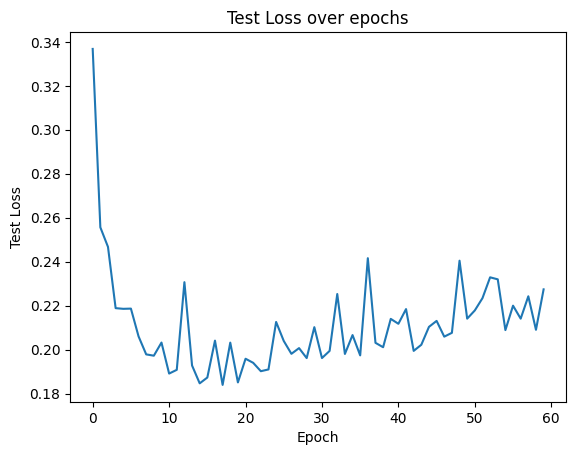

In [82]:
sns.lineplot(loss_ls)
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.title("Test Loss over epochs")
plt.show();

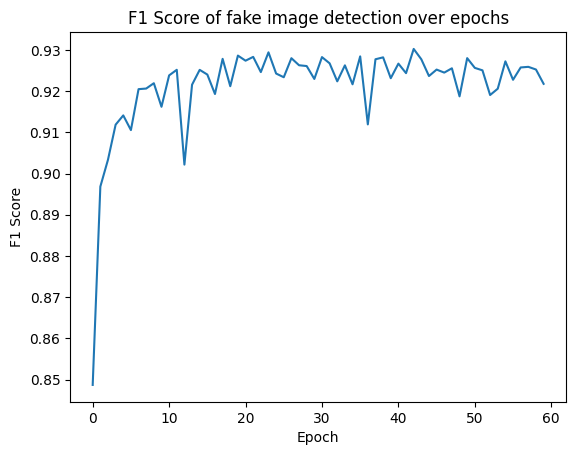

In [83]:
# f1 score; test precision
sns.lineplot(f1_ls)
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Score of fake image detection over epochs")
plt.show();

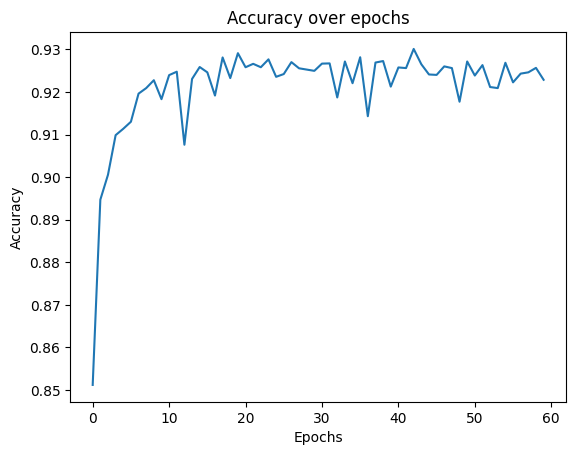

In [84]:
# test accuracy
sns.lineplot(accuracy_score_ls)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over epochs")
plt.show();

### Get predictions of test set (with confusion matrix and classification report)

[[9362  638]
 [ 915 9085]]


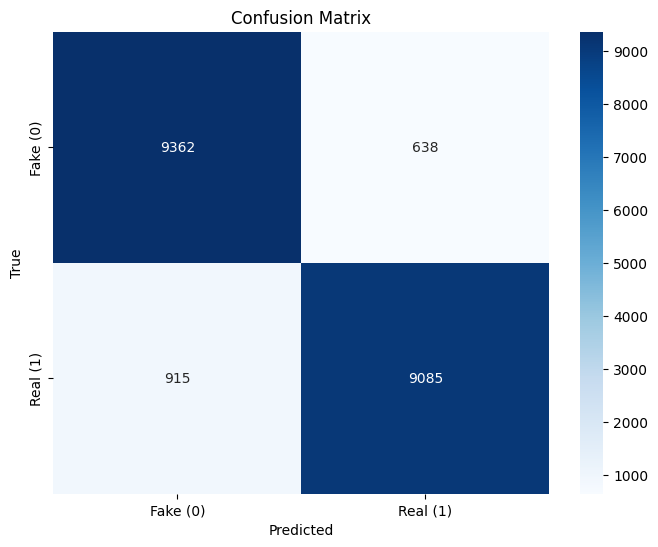

              precision    recall  f1-score   support

    Fake (0)       0.91      0.94      0.92     10000
    Real (1)       0.93      0.91      0.92     10000

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000



In [85]:
model.eval()

# Get the predictions for the test set
y_true = []
y_pred = []
for features, target in test_loader:
	features, target = features.to(device), target.to(device)
	output = model(features)
	label_out = torch.argmax(output, dim=1) #argmax returns the index of the maximum value in the tensor
	y_true.extend(target.cpu().numpy())
	y_pred.extend(label_out.cpu().numpy())


# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake (0)", "Real (1)"], yticklabels=["Fake (0)", "Real (1)"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Get the classification report
report = classification_report(y_true, y_pred, target_names=["Fake (0)", "Real (1)"])
print(report)


### Save model to device

In [89]:
# save the model
code=random.randint(100000,999999)

# Ensure the "saved_models" directory exists
os.makedirs("saved_models", exist_ok=True)
torch.save(model.state_dict(), f"saved_models/model.pth")

#check if model saved correctly
if os.path.exists(f"saved_models/model.pth"):
	print("Model saved as:", f"model.pth")
else:
	print("Model not saved")

Model saved as: model.pth


In [90]:
#load the model
model = CNN(dropout_rate).to(device)

## Use CAM to visualise CNN layer activation
### Initialise torchCAM

In [100]:
def display_cam(index, target_layer):
	image_tensor = test_images[index]
	real_class=image_tensor[1]
	image=image_tensor[0].permute(1, 2, 0)
	image_tensor = image_tensor[0].unsqueeze(0)

	#load the model
	model = CNN(dropout_rate)
	model.load_state_dict(torch.load("saved_models/model.pth"))
	#load the model to the same device as before
	model = model.to(device)
	model.eval()

	#get the cam extractor
	cam_extractor = SmoothGradCAMpp(model, target_layer=target_layer)

	#load the model
	model = CNN(dropout_rate)
	model.load_state_dict(torch.load("saved_models/model.pth"))
	#load the model to the same device as before
	model = model.to(device)
	model.eval()

	output = model(image_tensor.to(device))

	with SmoothGradCAMpp(model, target_layer=target_layer) as cam_extractor:
		output = model(image_tensor.to(device)) #move the image tensor to the same device as the model
		activation_map = cam_extractor(output.squeeze(0).argmax().item(), output)


	#print actual vs prediction
	predicted_class = output.argmax(dim=1).item()# # Set your CAM extractor
	print(f"Index: {index}\nActual class: {'Fake (0)' if real_class==0 else 'Real (1)'}, Predicted class: {'Fake (0)' if predicted_class==0 else 'Real (1)'}")

	#overlay the CAM on the image
	result = overlay_mask(to_pil_image(image_tensor[0]), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)

	#plot
	#print n images in train_data starting from starting_index
	return result

def display_all_cams(index):
    # Display CAMs for all images in the test set
    image_tensor = test_images[index]
    image = image_tensor[0].permute(1, 2, 0)

    # Plot original image
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis('off')

    # Plot Conv1 CAM
    plt.subplot(1, 3, 2)
    plt.title("Conv1 CAM")
    plt.imshow(display_cam(index, target_layer="conv1"))
    plt.axis('off')

    # Plot Conv2 CAM
    plt.subplot(1, 3, 3)
    plt.title("Conv2 CAM")
    plt.imshow(display_cam(index, target_layer="conv2"))
    plt.axis('off')

    plt.show()


In [103]:
# Get a random image by index, as an image tensor
index=random.randint(0, len(test_images)) #randomly select an index from the test data

Index: 5098
Actual class: Fake (0), Predicted class: Fake (0)
Index: 5098
Actual class: Fake (0), Predicted class: Fake (0)


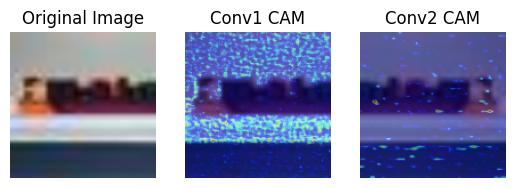

In [104]:
display_all_cams(index)